In [ ]:
%pip install pydiffmap

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from pydiffmap import diffusion_map
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, fowlkes_mallows_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
from zipfile import ZipFile
file_name = '/content/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Data Preprocessing
Preprocess the dataset

In [ ]:
# Define the image dimensions
IMG_WIDTH, IMG_HEIGHT = 128, 128

# Define the path to the dataset
dataset_path = 'Dataset'

# Define a dictionary to map folder names to class labels
class_labels = {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}

# Function to load and preprocess images
def load_and_preprocess_images(dataset_path, img_width, img_height):
    images = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_folder = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))
                images.append(img.flatten())
                labels.append(class_label)
    return np.array(images), np.array(labels)

# Load and preprocess the images
X, y = load_and_preprocess_images(dataset_path, IMG_WIDTH, IMG_HEIGHT)

# Print the shape of the processed data
print(f'Processed data shape: {X.shape}')
print(f'Processed labels shape: {y.shape}')

Processed data shape: (6400, 16384)
Processed labels shape: (6400,)


Visualise the data

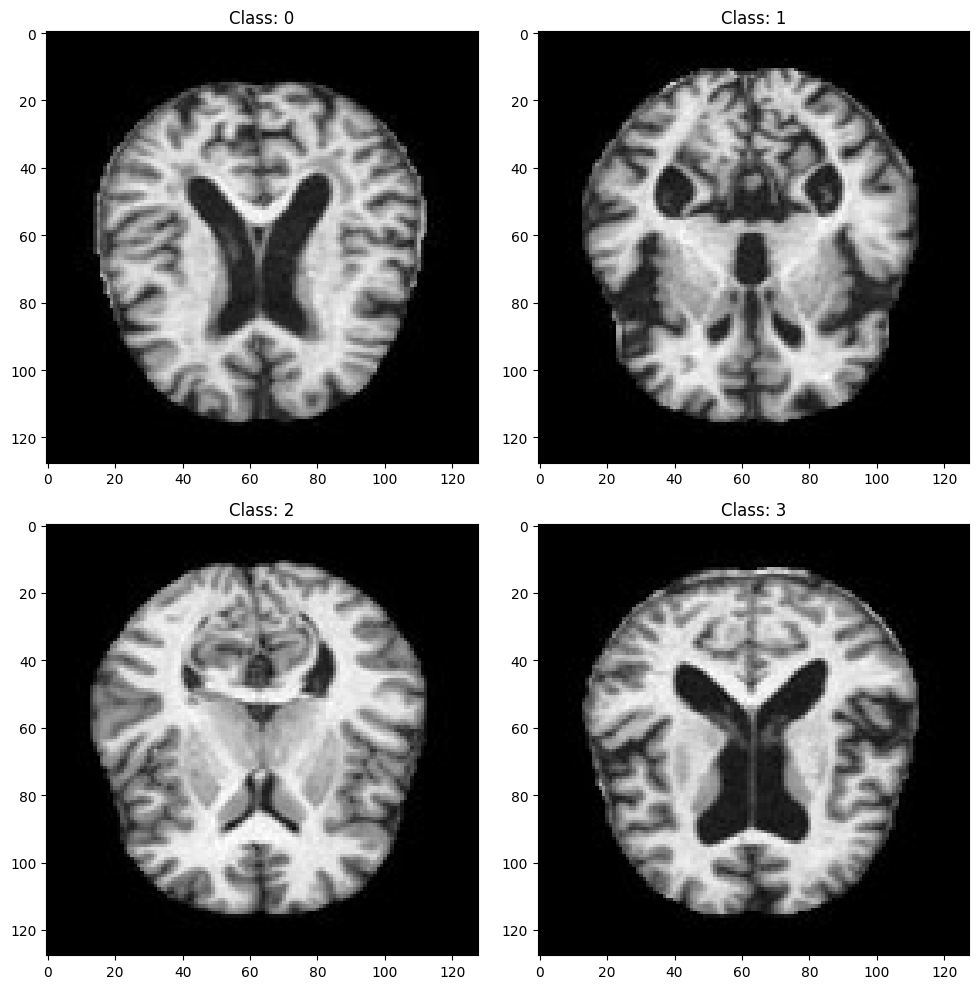

In [ ]:
# Select the indices of the images you want to visualize
image_indices = [0, 897, 961, 4161]

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the image indices and display each image
for i, ax in enumerate(axes.flat):
    # Extract the vector and reshape it to 128x128
    image_index = image_indices[i]
    image_vector = X[image_index]
    image_2d = image_vector.reshape(128, 128)

    # Display the image
    ax.imshow(image_2d, cmap='gray')
    ax.set_title(f'Class: {y[image_index]}')

# Adjust layout and display
plt.tight_layout()
plt.show()

# NLDR Functions
Create functions to apply NLDR algorithms to reduce our data to n components

In [ ]:
# Function for applying ISOMAP
def isomap_embedding(X, n_components):
    # Initialize ISOMAP
    isomap = Isomap(n_components = n_components)

    # Fit ISOMAP to the preprocessed data
    X_isomap = isomap.fit_transform(X)

    return X_isomap

# Function for applying LLE
def lle_embedding(X, n_components):
    # Initialize LLE
    lle = LocallyLinearEmbedding(n_components = n_components)

    # Fit LLE to the preprocessed data
    X_lle = lle.fit_transform(X)

    return X_lle

# Function for applying Diffusion Map
def diffusion_map_embedding(X, n_components):
    # Initialize Diffusion Map
    diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = n_components)

    # fit to data and return the diffusion map.
    X_diffusion_map = diffmap.fit_transform(X)

    return X_diffusion_map

# Function for applying t-SNE
def tsne_embedding(X, n_components):
    # Initialize t-SNE
    tsne = TSNE(n_components = n_components, method = 'exact', learning_rate = 200, init = 'random', random_state = 42)

    # Fit t-SNE to the preprocessed data
    X_tsne = tsne.fit_transform(X)

    return X_tsne

# Function for dimension exploration
Create a function that reduces our data to the desired number of dimensions

In [ ]:
# Create a dictionary with the NLDR functions
functions = {
    isomap_embedding: isomap_embedding,
    lle_embedding: lle_embedding,
    diffusion_map_embedding: diffusion_map_embedding,
    tsne_embedding: tsne_embedding
}

# Function for dimensionality reduction
def reduce_dimensions(data, dimensions, NLDR_algorithm):
    # Initialize array for the reduced data
    X_reduced = []

    # Reduce to n dimensions
    for n in dimensions:
        X_reduced.append(functions[NLDR_algorithm](data, n))

    return X_reduced

# Function for computing the popular metrics
Compute the following metrics: the Calinski-Harabasz Index, the Davies-Bouldin Index, the Fowlkes-Mallows Index and the Silhouette Score

In [ ]:
# Function that computes the metrics
def compute_metrics(X, y, X_reduced, dimensions):
    # Initialize lists to store the results
    results_ch = []
    results_db = []
    results_fm = []
    results_sil = []

    # Compute metrics for the base case
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X)
    y_pred = kmeans.labels_

    ch_score = calinski_harabasz_score(X, y)
    db_score = davies_bouldin_score(X, y)
    fm_score = fowlkes_mallows_score(y, y_pred)
    sil_score = silhouette_score(X, y)

    results_ch.append(['Base', ch_score])
    results_db.append(['Base', db_score])
    results_fm.append(['Base', fm_score])
    results_sil.append(['Base', sil_score])

    # Compute metrics for each dimensionality-reduced dataset
    for i, data in enumerate(X_reduced):
        name = str(dimensions[i]) + "D"

        kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(data)
        y_pred = kmeans.labels_

        ch_score = calinski_harabasz_score(data, y)
        db_score = davies_bouldin_score(data, y)
        fm_score = fowlkes_mallows_score(y, y_pred)
        sil_score = silhouette_score(data, y)

        results_ch.append([name, ch_score])
        results_db.append([name, db_score])
        results_fm.append([name, fm_score])
        results_sil.append([name, sil_score])

    # Convert results to DataFrames
    df_ch = pd.DataFrame(results_ch, columns=['Dimension', 'Calinski-Harabasz Index'])
    df_db = pd.DataFrame(results_db, columns=['Dimension', 'Davies-Bouldin Index'])
    df_fm = pd.DataFrame(results_fm, columns=['Dimension', 'Fowlkes-Mallows Index'])
    df_sil = pd.DataFrame(results_sil, columns=['Dimension', 'Silhouette Score'])

    return df_ch, df_db, df_fm, df_sil

# Function for computing Classification Algorithm metrics
Create a function that classifies the data and computes the popular metrics (accuracy, precision, recall and F1-score)

In [ ]:
# Function that computes the metrics for the classification
def evaluate_classification(X, y, dimension):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the classifier
    clf = RandomForestClassifier(random_state=42)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Return the results as a dictionary
    return {
        'Dimensions': dimension,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

# Function that compares the classification results
def compare_classification(X, y, X_reduced, dimensions):
    # Initialize a list to store the results
    classification_results = []

    result = evaluate_classification(X, y, 'Base')
    classification_results.append(result)

    # Evaluate the classification performance on each dataset
    for i,data in enumerate(X_reduced):
        name = str(dimensions[i]) + "D"
        result = evaluate_classification(data, y, name)
        classification_results.append(result)

    # Convert the results to a DataFrame for better visualization and return it
    return pd.DataFrame(classification_results)

# Functions for Parameter Tuning
Create functions that classifies the data and computes the popular metrics to compare the parameters

In [ ]:
# Function that computes the metrics for the classification
def evaluate_classification_param(X, y, param):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the classifier
    clf = RandomForestClassifier(random_state=42)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Return the results as a dictionary
    return {
        'Parameter': param,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

# Function that compares the classification results
def compare_classification_param(X, y, X_reduced, params):
    # Initialize a list to store the results
    classification_results = []

    result = evaluate_classification_param(X, y, 'Base')
    classification_results.append(result)

    # Evaluate the classification performance on each dataset
    for i,data in enumerate(X_reduced):
        name = params[i]
        result = evaluate_classification_param(data, y, name)
        classification_results.append(result)

    # Convert the results to a DataFrame for better visualization and return it
    return pd.DataFrame(classification_results)

# Plotting Functions
Create functions to plot the different metrics

In [ ]:
# Function for plotting the metrics
def plot_metrics(df, metric, title):
    plt.figure(figsize=(10, 6))
    plt.bar(df['Dimension'], df[metric], color='skyblue')
    plt.xlabel('Dimension')
    plt.ylabel(metric)
    plt.title(f'{title}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function for plotting the classification metrics
def plot_classification_results(df, metric, title):
    plt.figure(figsize=(10, 6))
    plt.bar(df['Dimensions'], df[metric], color='skyblue')
    plt.xlabel('Dimensions')
    plt.ylabel(metric)
    plt.title(f'{title}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ISOMAP Results

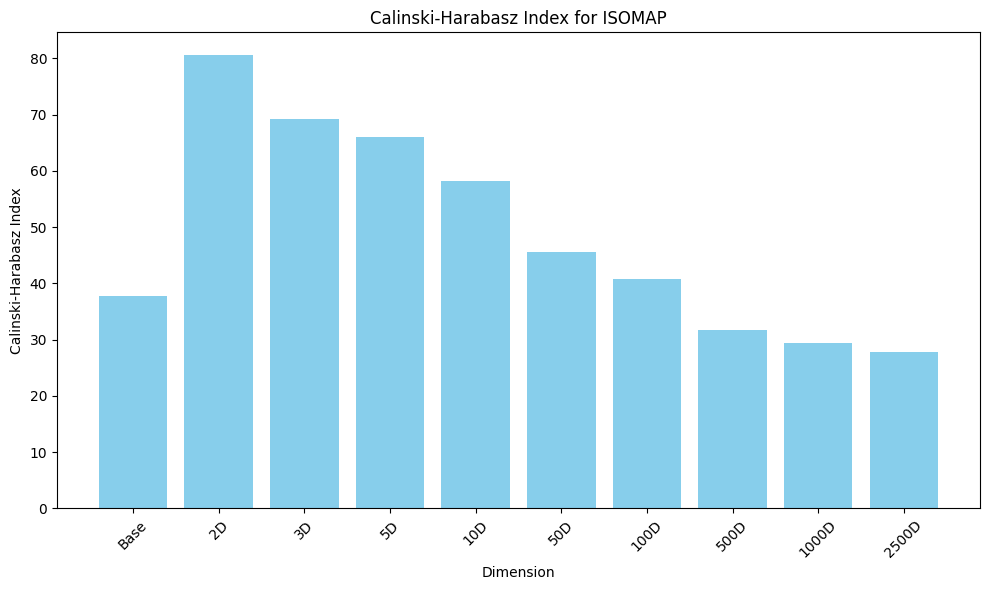

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1        2D                80.615847
2        3D                69.167175
3        5D                66.114738
4       10D                58.266335
5       50D                45.588840
6      100D                40.725958
7      500D                31.770648
8     1000D                29.469473
9     2500D                27.834631


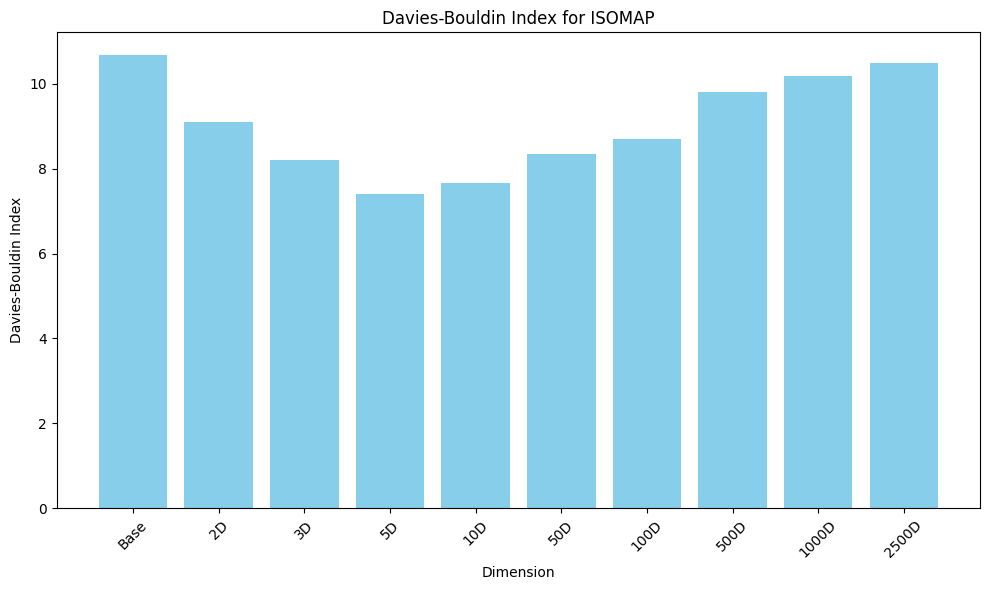

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1        2D              9.104496
2        3D              8.199793
3        5D              7.401076
4       10D              7.658705
5       50D              8.335643
6      100D              8.703795
7      500D              9.815117
8     1000D             10.191125
9     2500D             10.487446


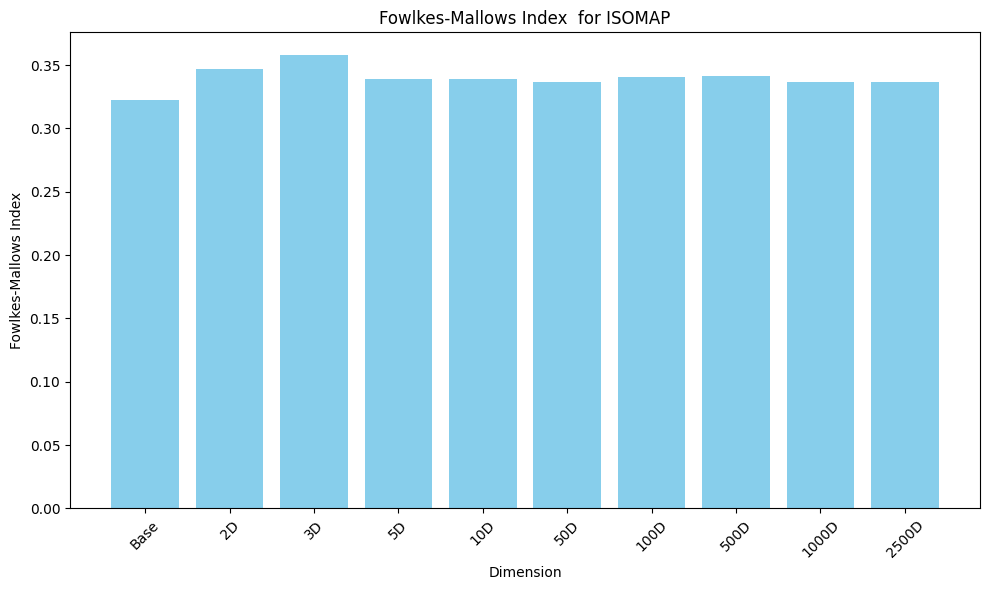

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1        2D               0.346763
2        3D               0.357981
3        5D               0.339324
4       10D               0.339423
5       50D               0.336586
6      100D               0.340655
7      500D               0.341029
8     1000D               0.336533
9     2500D               0.336482


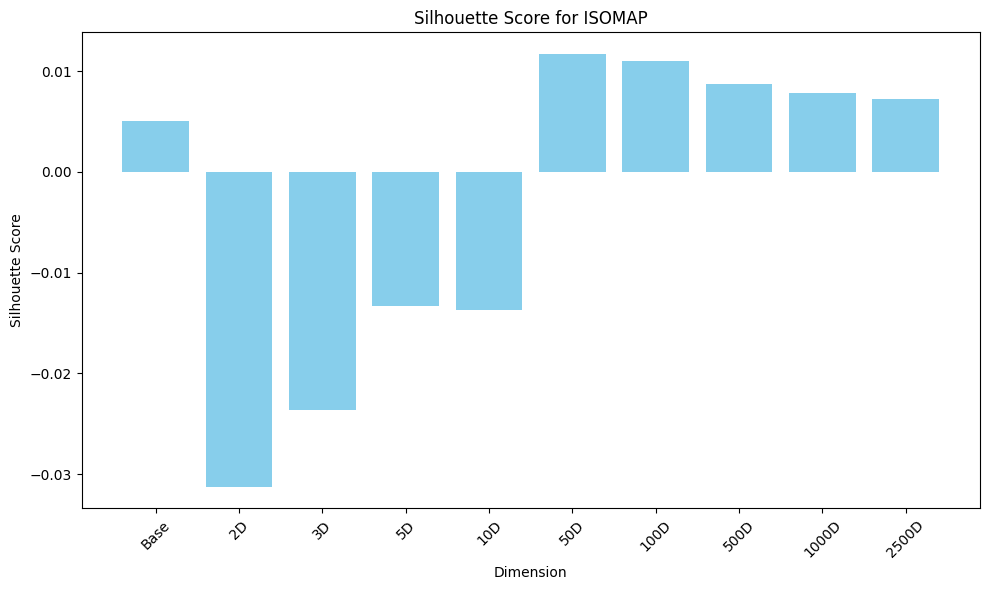

  Dimension  Silhouette Score
0      Base          0.005043
1        2D         -0.031247
2        3D         -0.023651
3        5D         -0.013348
4       10D         -0.013727
5       50D          0.011702
6      100D          0.011047
7      500D          0.008673
8     1000D          0.007861
9     2500D          0.007238


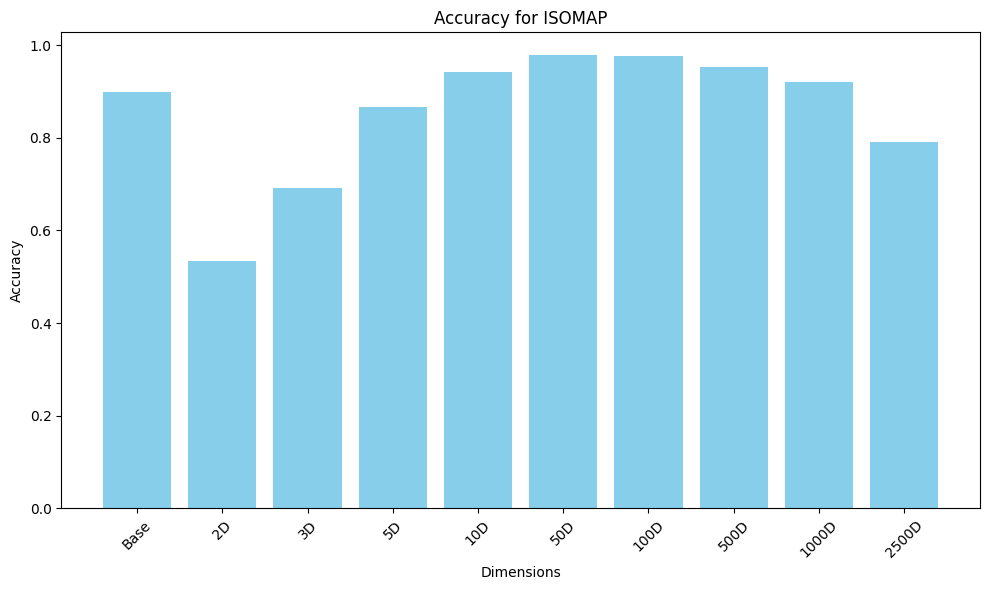

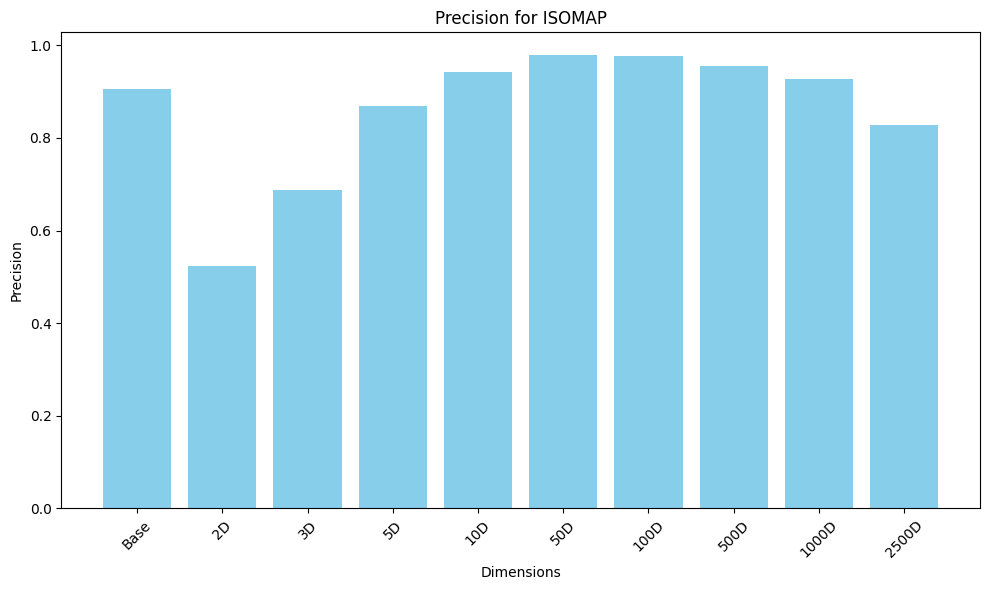

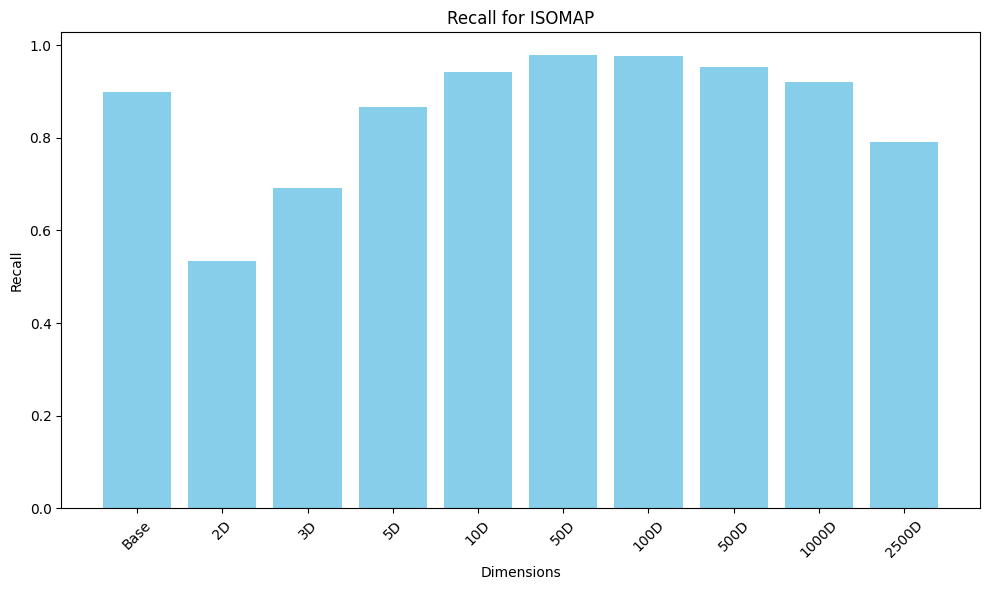

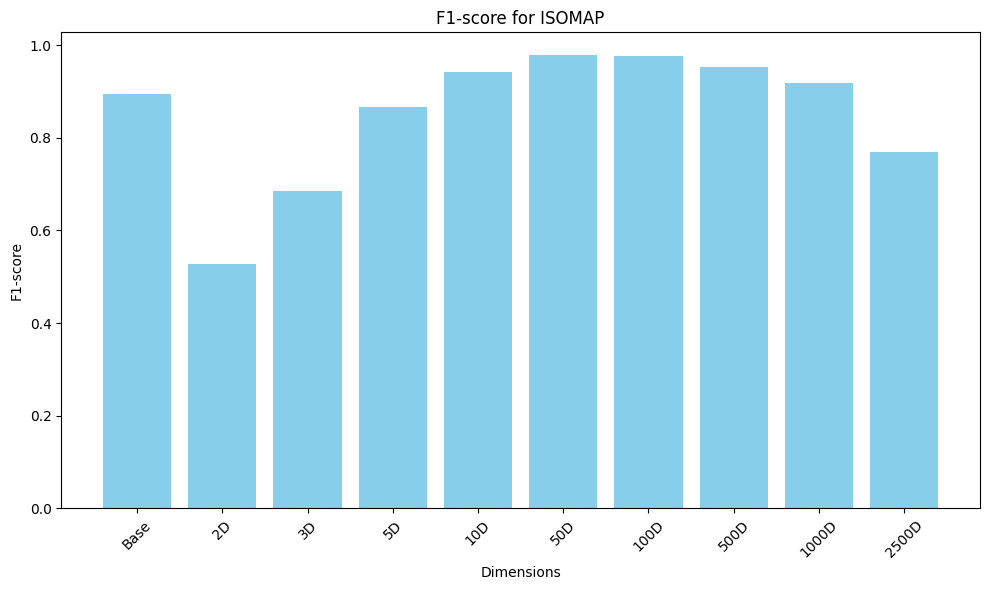

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1         2D  0.533854   0.523933  0.533854  0.528168
2         3D  0.691146   0.688373  0.691146  0.686034
3         5D  0.866667   0.868030  0.866667  0.865681
4        10D  0.941667   0.942438  0.941667  0.941255
5        50D  0.978646   0.978971  0.978646  0.978599
6       100D  0.976562   0.977042  0.976562  0.976473
7       500D  0.952604   0.955212  0.952604  0.951937
8      1000D  0.920312   0.926986  0.920312  0.918005
9      2500D  0.791667   0.828580  0.791667  0.769264


In [ ]:
# Array with the dimensions we want to explore
dimensions = [2, 3, 5, 10, 50, 100, 500, 1000, 2500]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, isomap_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for ISOMAP')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for ISOMAP')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for ISOMAP')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for ISOMAP')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for ISOMAP')
plot_classification_results(df_results, 'Precision', 'Precision for ISOMAP')
plot_classification_results(df_results, 'Recall', 'Recall for ISOMAP')
plot_classification_results(df_results, 'F1-score', 'F1-score for ISOMAP')
print(df_results)

Check dimensions in the vecinity of the best result

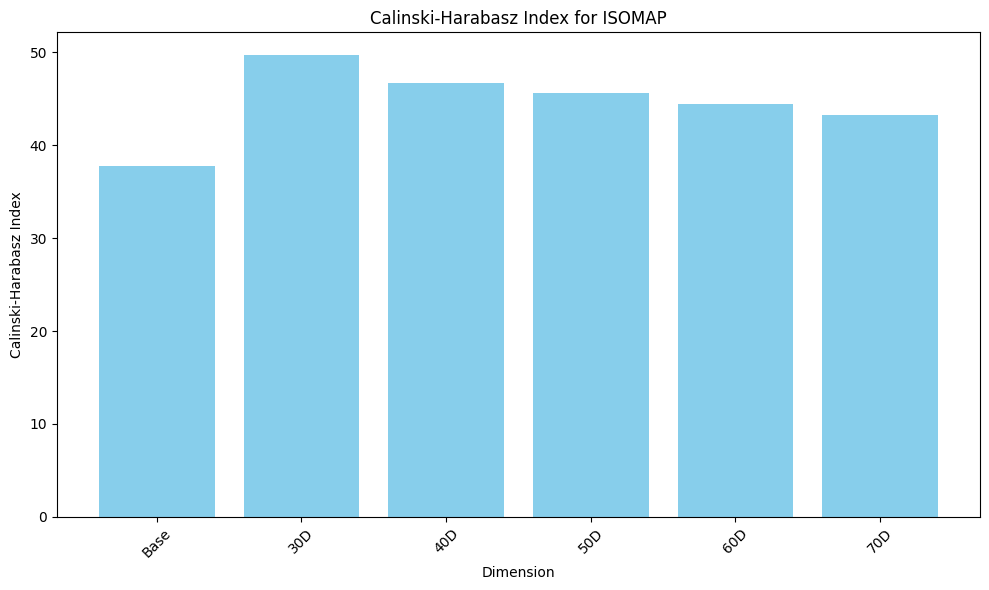

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1       30D                49.665462
2       40D                46.714482
3       50D                45.588840
4       60D                44.407710
5       70D                43.305350


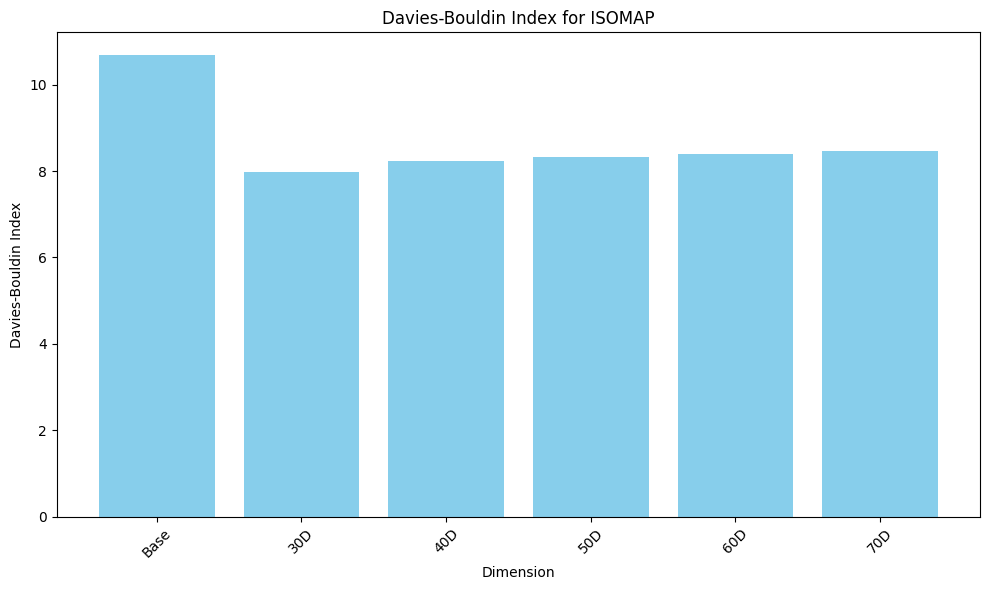

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1       30D              7.974641
2       40D              8.236927
3       50D              8.335643
4       60D              8.399100
5       70D              8.471352


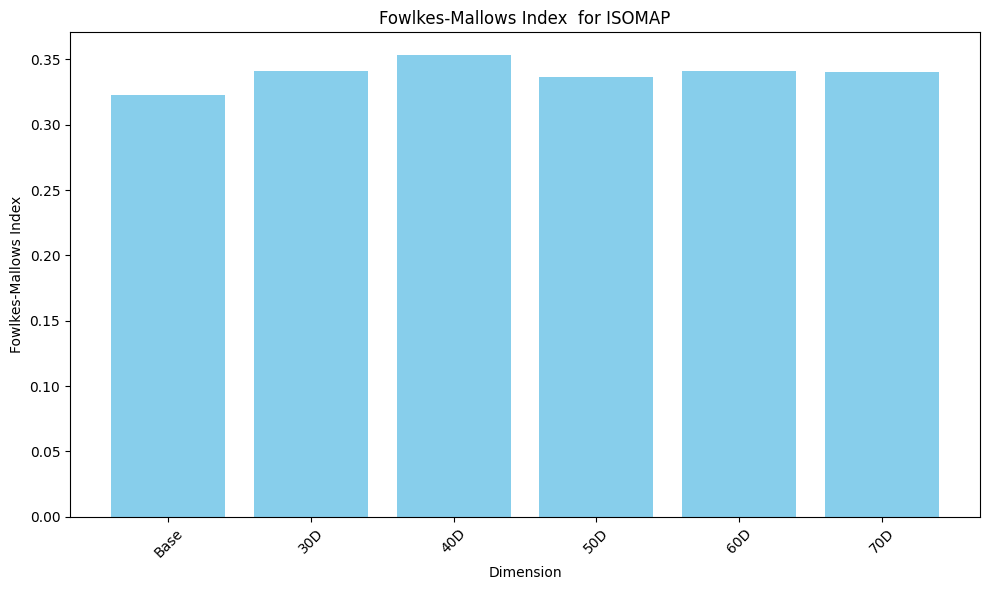

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1       30D               0.341227
2       40D               0.352962
3       50D               0.336586
4       60D               0.340873
5       70D               0.340600


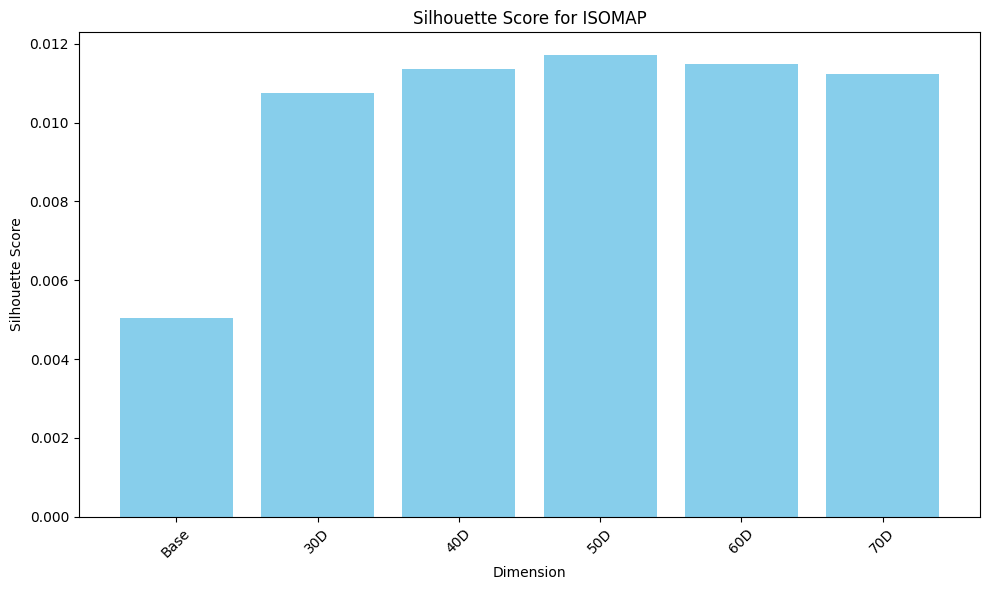

  Dimension  Silhouette Score
0      Base          0.005043
1       30D          0.010737
2       40D          0.011366
3       50D          0.011702
4       60D          0.011490
5       70D          0.011225


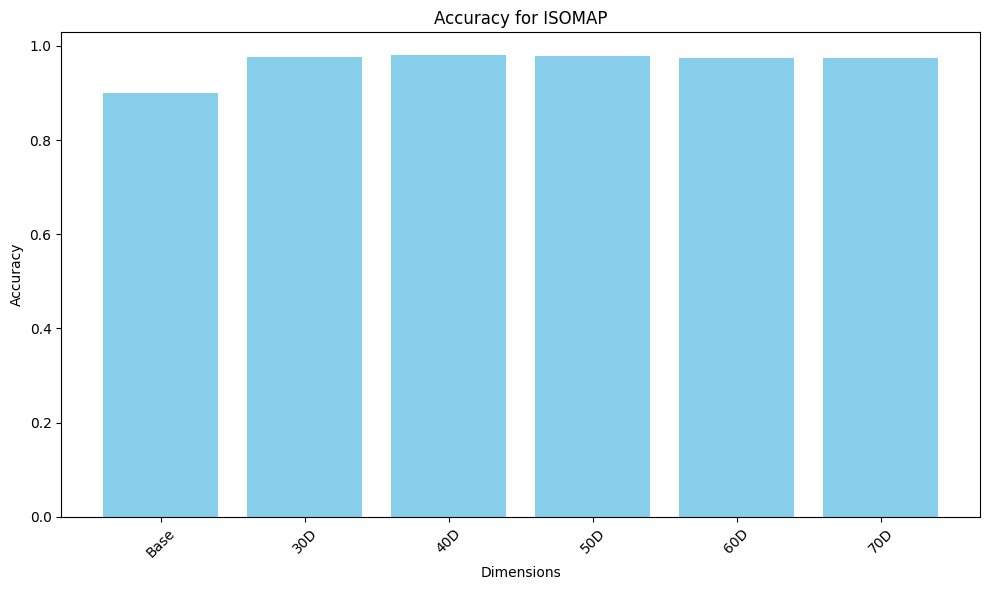

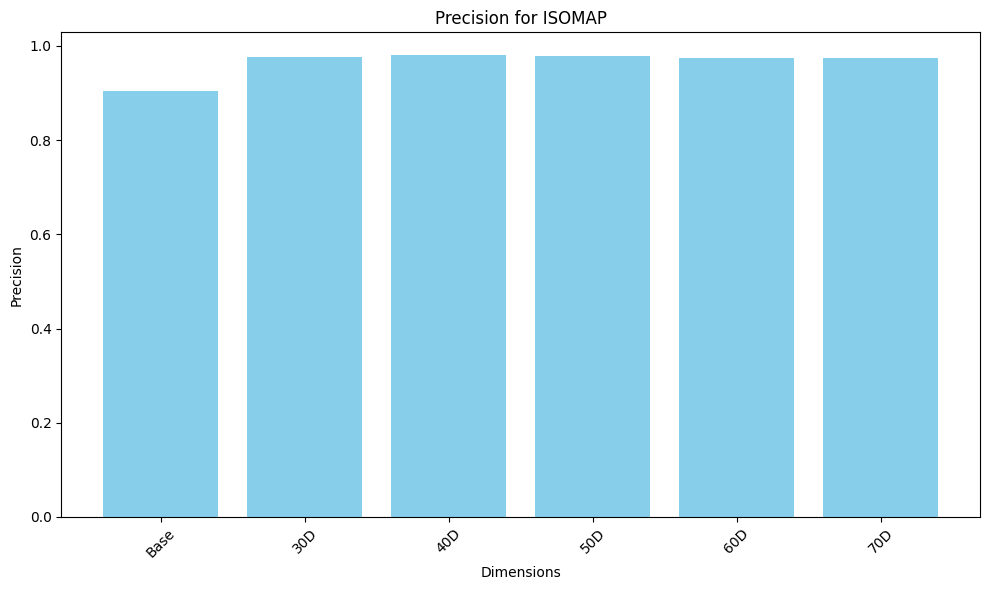

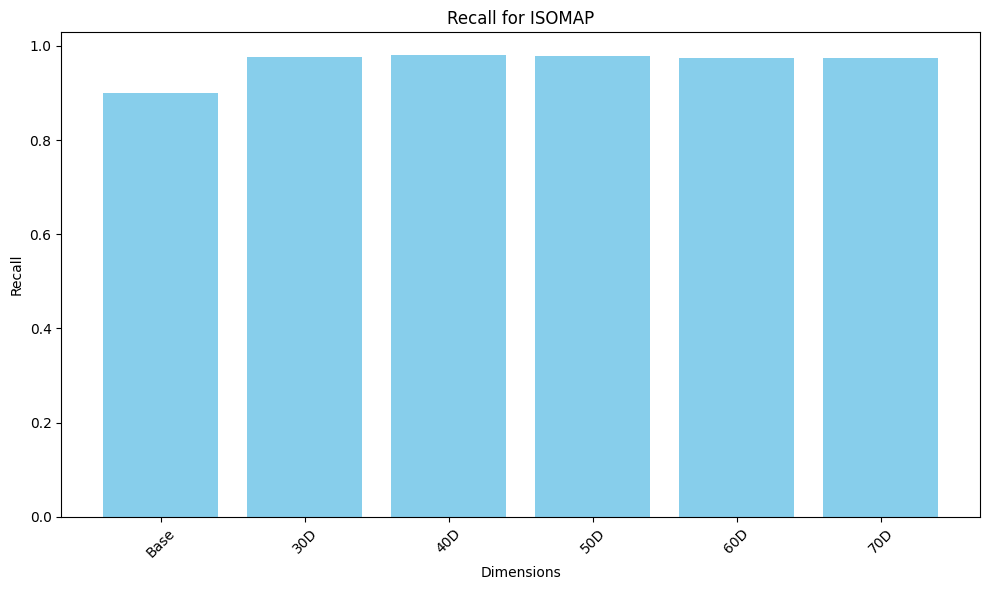

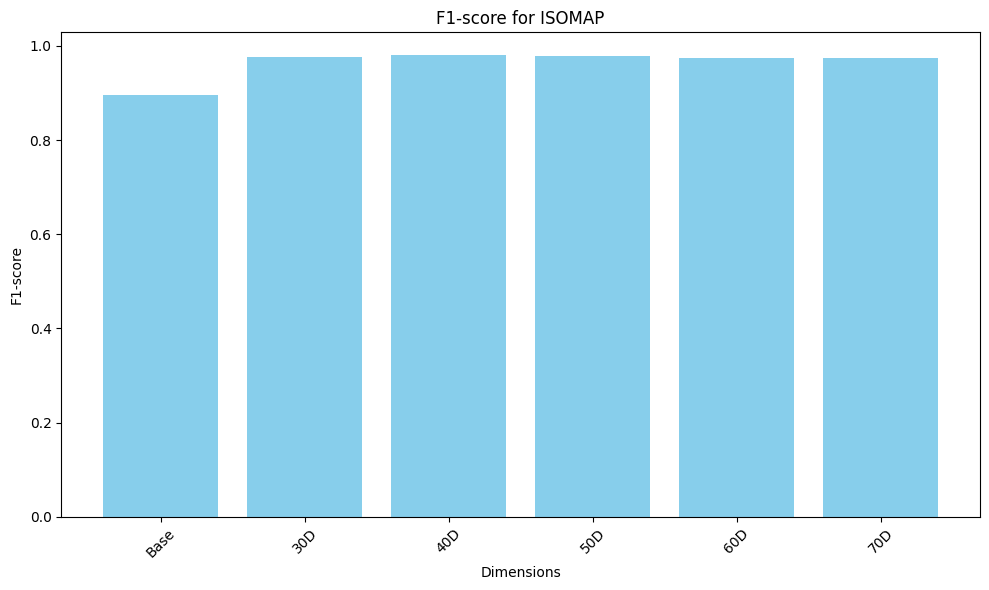

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1        30D  0.976562   0.976765  0.976562  0.976506
2        40D  0.979688   0.979925  0.979688  0.979642
3        50D  0.978646   0.978971  0.978646  0.978599
4        60D  0.974479   0.974914  0.974479  0.974405
5        70D  0.975000   0.975380  0.975000  0.974910


In [ ]:
# Array with the dimensions we want to explore
dimensions = [30, 40, 50, 60, 70]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, isomap_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for ISOMAP')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for ISOMAP')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for ISOMAP')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for ISOMAP')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for ISOMAP')
plot_classification_results(df_results, 'Precision', 'Precision for ISOMAP')
plot_classification_results(df_results, 'Recall', 'Recall for ISOMAP')
plot_classification_results(df_results, 'F1-score', 'F1-score for ISOMAP')
print(df_results)

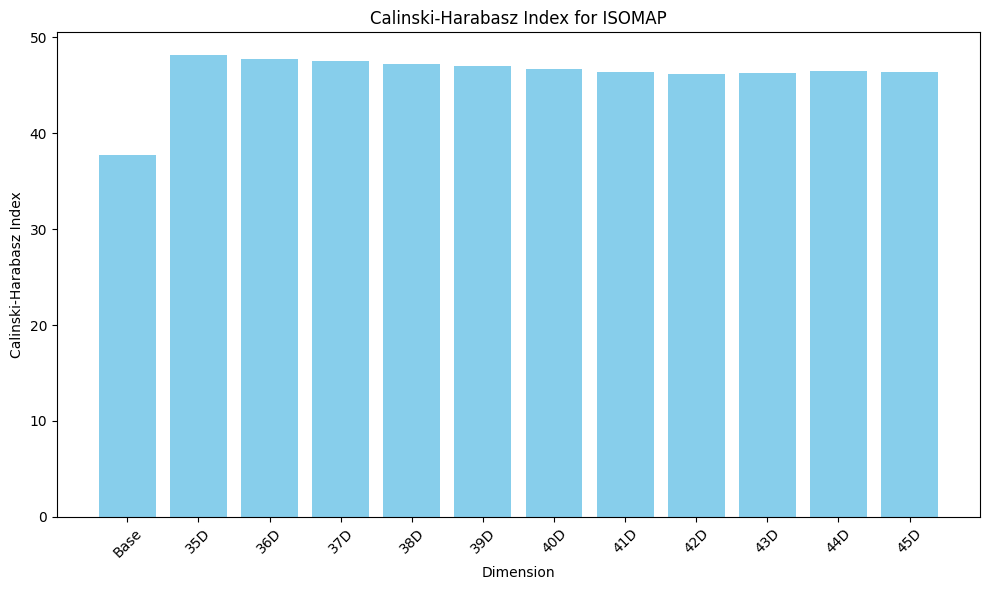

   Dimension  Calinski-Harabasz Index
0       Base                37.762006
1        35D                48.113710
2        36D                47.789362
3        37D                47.542695
4        38D                47.240304
5        39D                47.000752
6        40D                46.714482
7        41D                46.417531
8        42D                46.206465
9        43D                46.321725
10       44D                46.466613
11       45D                46.380647


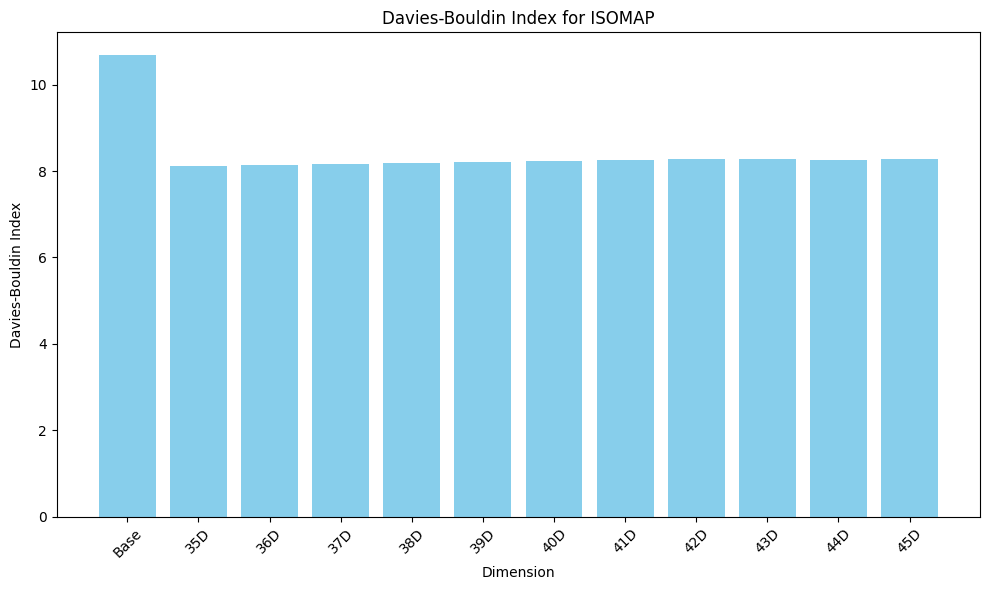

   Dimension  Davies-Bouldin Index
0       Base             10.674452
1        35D              8.115187
2        36D              8.142222
3        37D              8.161560
4        38D              8.187679
5        39D              8.208860
6        40D              8.236927
7        41D              8.263777
8        42D              8.286264
9        43D              8.276995
10       44D              8.258601
11       45D              8.270305


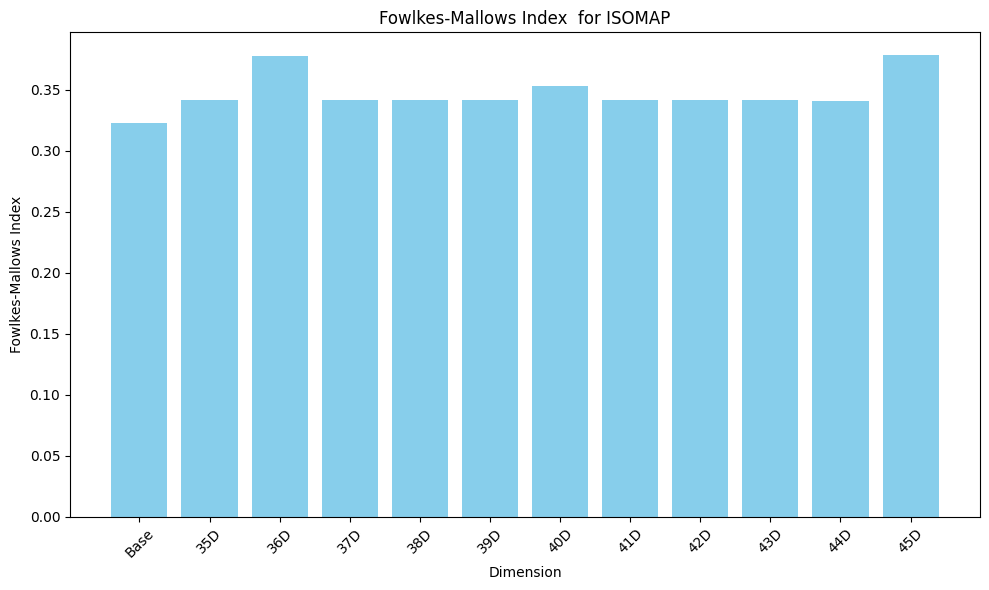

   Dimension  Fowlkes-Mallows Index
0       Base               0.322841
1        35D               0.341233
2        36D               0.377178
3        37D               0.341171
4        38D               0.341171
5        39D               0.341344
6        40D               0.352962
7        41D               0.341416
8        42D               0.341411
9        43D               0.341317
10       44D               0.340750
11       45D               0.378005


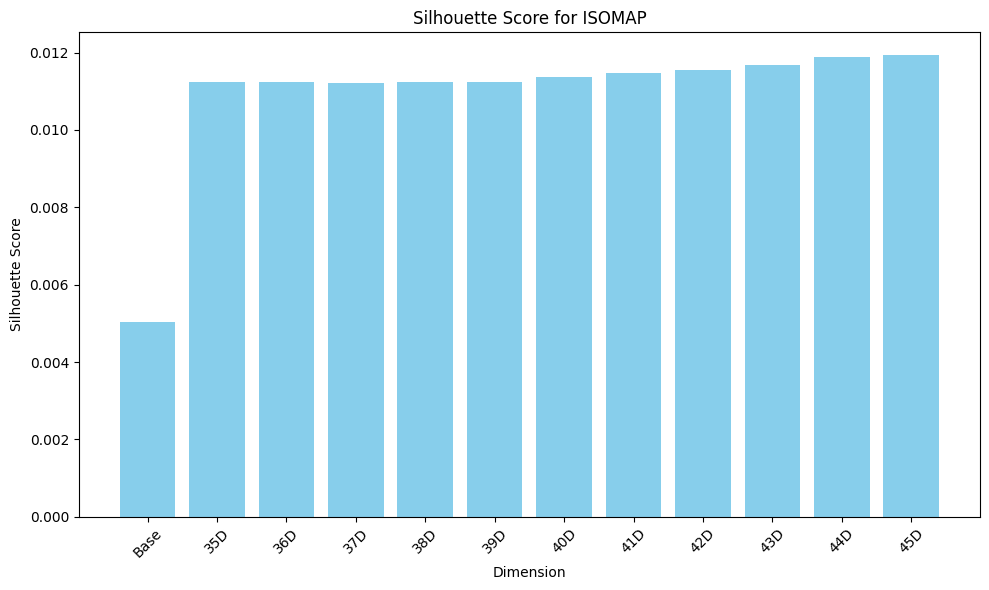

   Dimension  Silhouette Score
0       Base          0.005043
1        35D          0.011247
2        36D          0.011252
3        37D          0.011203
4        38D          0.011233
5        39D          0.011239
6        40D          0.011366
7        41D          0.011461
8        42D          0.011541
9        43D          0.011689
10       44D          0.011886
11       45D          0.011926


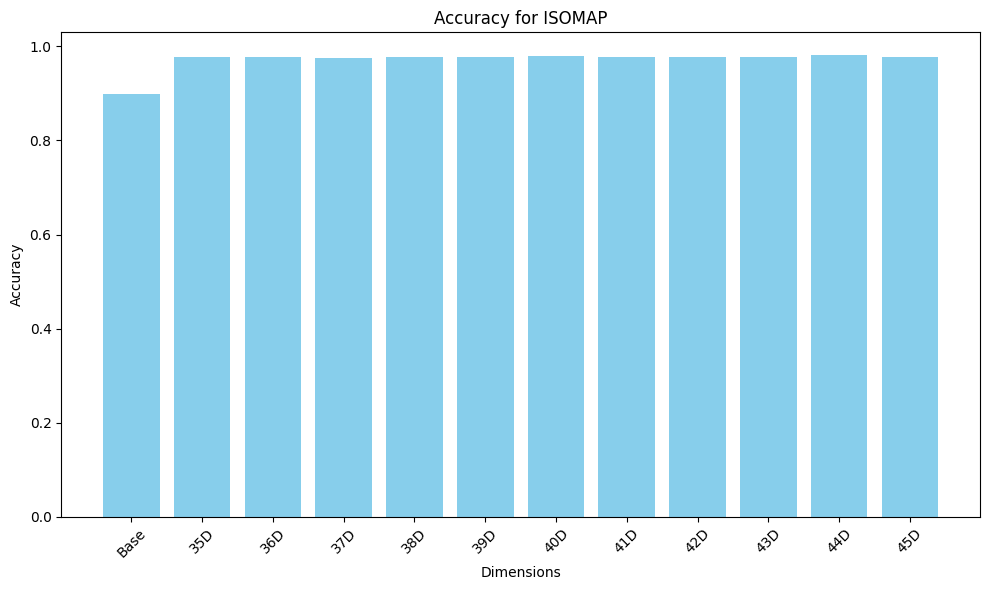

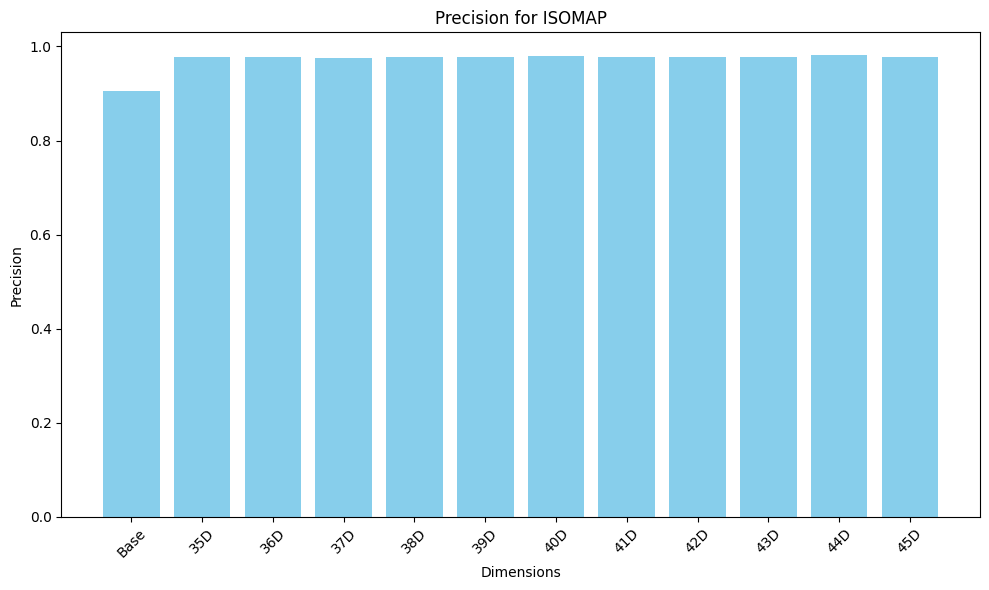

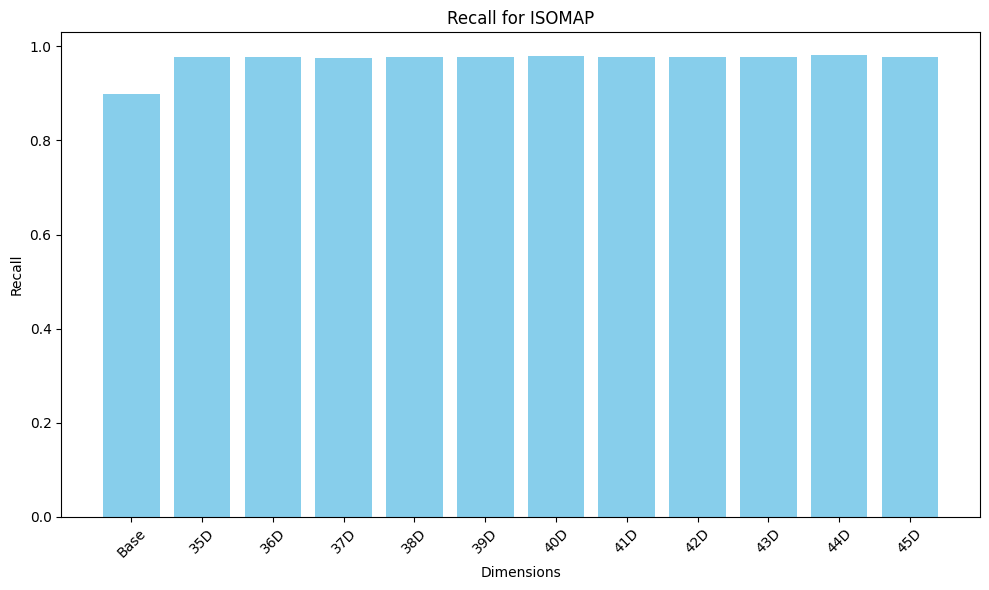

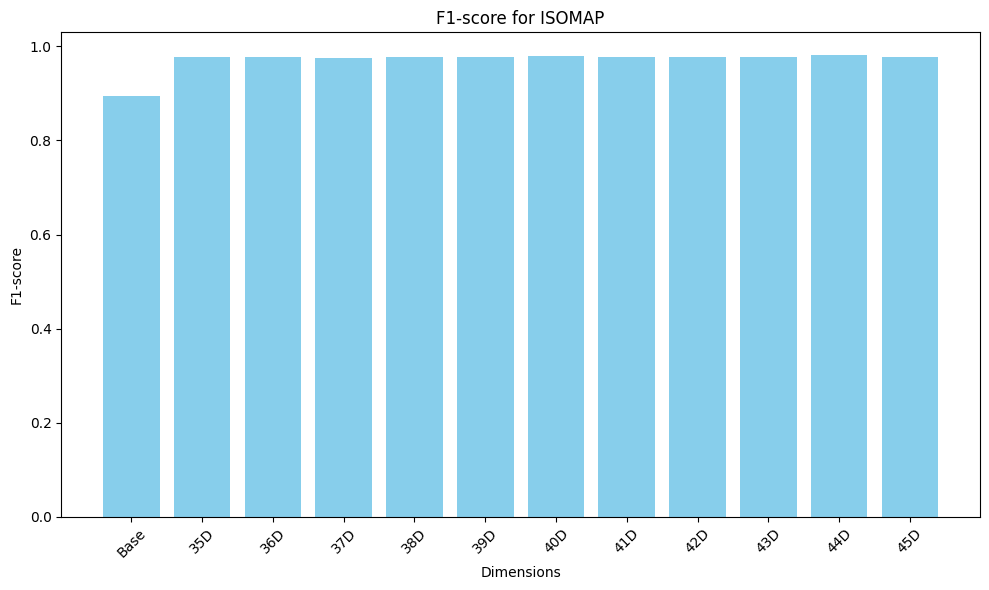

   Dimensions  Accuracy  Precision    Recall  F1-score
0        Base  0.898958   0.904731  0.898958  0.894862
1         35D  0.977604   0.978022  0.977604  0.977546
2         36D  0.976562   0.976793  0.976562  0.976472
3         37D  0.975521   0.975871  0.975521  0.975464
4         38D  0.976562   0.976823  0.976562  0.976496
5         39D  0.978125   0.978379  0.978125  0.978064
6         40D  0.979688   0.979925  0.979688  0.979642
7         41D  0.977083   0.977367  0.977083  0.977049
8         42D  0.976562   0.976950  0.976562  0.976513
9         43D  0.977604   0.977966  0.977604  0.977552
10        44D  0.980729   0.981056  0.980729  0.980695
11        45D  0.977083   0.977339  0.977083  0.977023


In [ ]:
# Array with the dimensions we want to explore
dimensions = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, isomap_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for ISOMAP')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for ISOMAP')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for ISOMAP')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for ISOMAP')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for ISOMAP')
plot_classification_results(df_results, 'Precision', 'Precision for ISOMAP')
plot_classification_results(df_results, 'Recall', 'Recall for ISOMAP')
plot_classification_results(df_results, 'F1-score', 'F1-score for ISOMAP')
print(df_results)

# Isomap Parameter Tuning

In [ ]:
params = ['default', 'n_neighbors = 10',  'n_neighbors = 15',  'n_neighbors = 20']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize ISOMAP default n_neighbors = 5
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP n_neighbors = 10
isomap = Isomap(n_components = 44, n_neighbors = 10)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP n_neighbors = 15
isomap = Isomap(n_components = 44, n_neighbors = 15)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP n_neighbors = 20
isomap = Isomap(n_components = 44, n_neighbors = 20)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

          Parameter  Accuracy  Precision    Recall  F1-score
0              Base  0.898958   0.904731  0.898958  0.894862
1           default  0.980729   0.981056  0.980729  0.980695
2  n_neighbors = 10  0.925000   0.927452  0.925000  0.923856
3  n_neighbors = 15  0.908854   0.911579  0.908854  0.907373
4  n_neighbors = 20  0.890104   0.895466  0.890104  0.886901


In [ ]:
params = ['default', 'eigen_solver = arpack',  'eigen_solver = dense']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize ISOMAP default eigen_solver = 'auto'
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP eigen_solver = 'arpack'
isomap = Isomap(n_components = 44, eigen_solver = 'arpack')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP eigen_solver = 'dense'
isomap = Isomap(n_components = 44, eigen_solver = 'dense')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

               Parameter  Accuracy  Precision    Recall  F1-score
0                   Base  0.898958   0.904731  0.898958  0.894862
1                default  0.980729   0.981056  0.980729  0.980695
2  eigen_solver = arpack  0.980729   0.981056  0.980729  0.980695
3   eigen_solver = dense  0.980729   0.981056  0.980729  0.980695


In [ ]:
params = ['default', 'path_method = FW',  'path_method = D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize ISOMAP default path_method = 'auto'
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP path_method = 'FW'
isomap = Isomap(n_components = 44, path_method = 'FW')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP path_method = 'D'
isomap = Isomap(n_components = 44, path_method = 'D')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

          Parameter  Accuracy  Precision    Recall  F1-score
0              Base  0.898958   0.904731  0.898958  0.894862
1           default  0.980729   0.981056  0.980729  0.980695
2  path_method = FW  0.980729   0.981056  0.980729  0.980695
3   path_method = D  0.980729   0.981056  0.980729  0.980695


In [ ]:
params = ['default', 'neighbors_algorithm = brute',  'neighbors_algorithm = kd_tree', 'neighbors_algorithm = ball_tree']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize ISOMAP default neighbors_algorithm = 'auto'
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP neighbors_algorithm = 'brute'
isomap = Isomap(n_components = 44, neighbors_algorithm = 'brute')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP neighbors_algorithm = 'kd_tree'
isomap = Isomap(n_components = 44, neighbors_algorithm = 'kd_tree')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Initialize ISOMAP neighbors_algorithm = 'ball_tree'
isomap = Isomap(n_components = 44, neighbors_algorithm = 'ball_tree')

# Fit ISOMAP to the preprocessed data
X_isomap = isomap.fit_transform(X)

# Append to array
X_reduced.append(X_isomap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

                         Parameter  Accuracy  Precision    Recall  F1-score
0                             Base  0.898958   0.904731  0.898958  0.894862
1                          default  0.980729   0.981056  0.980729  0.980695
2      neighbors_algorithm = brute  0.980729   0.981056  0.980729  0.980695
3    neighbors_algorithm = kd_tree  0.980729   0.981056  0.980729  0.980695
4  neighbors_algorithm = ball_tree  0.980729   0.981056  0.980729  0.980695


# Best Isomap Results

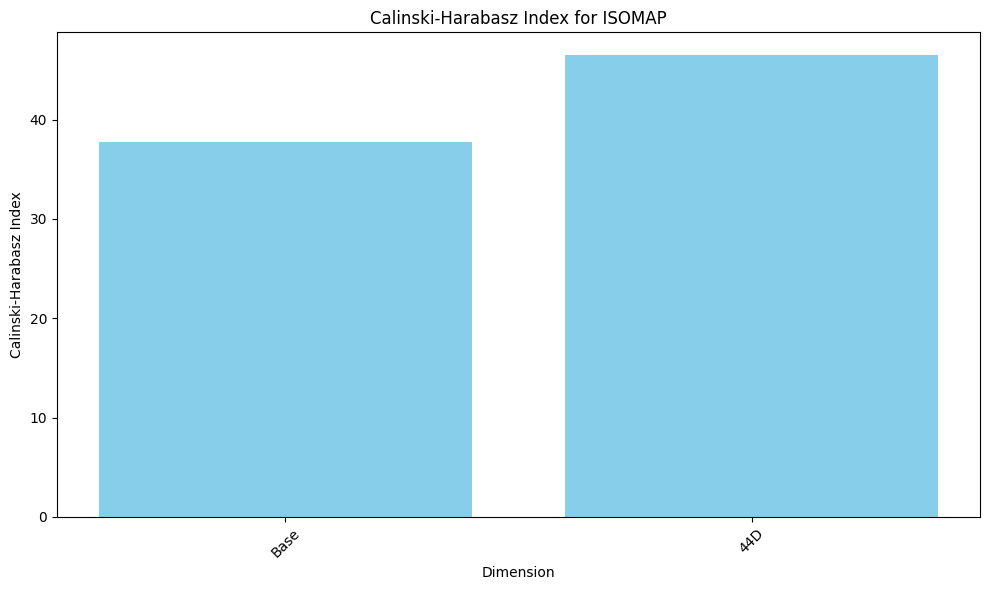

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1       44D                46.466613


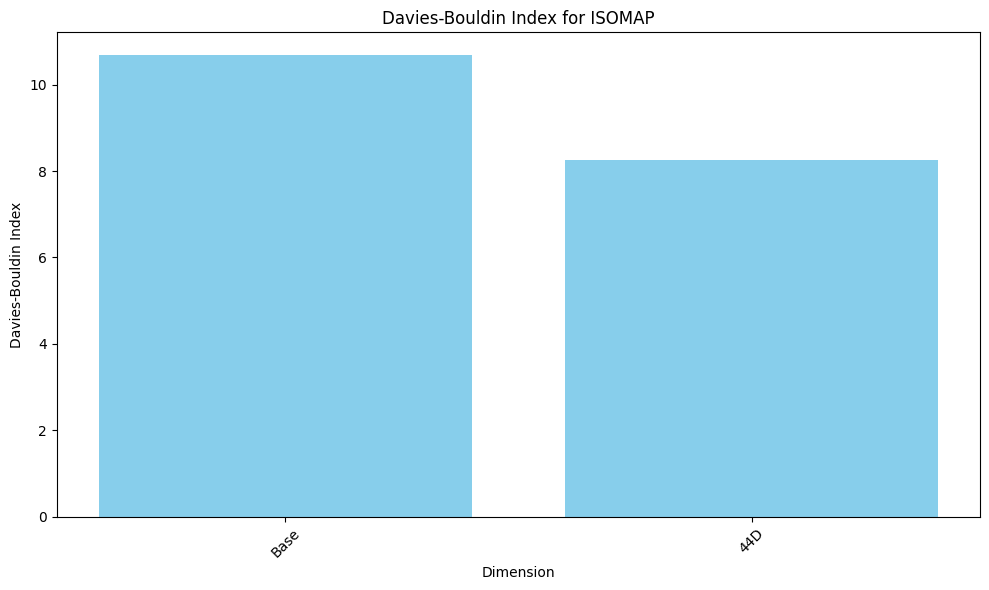

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1       44D              8.258601


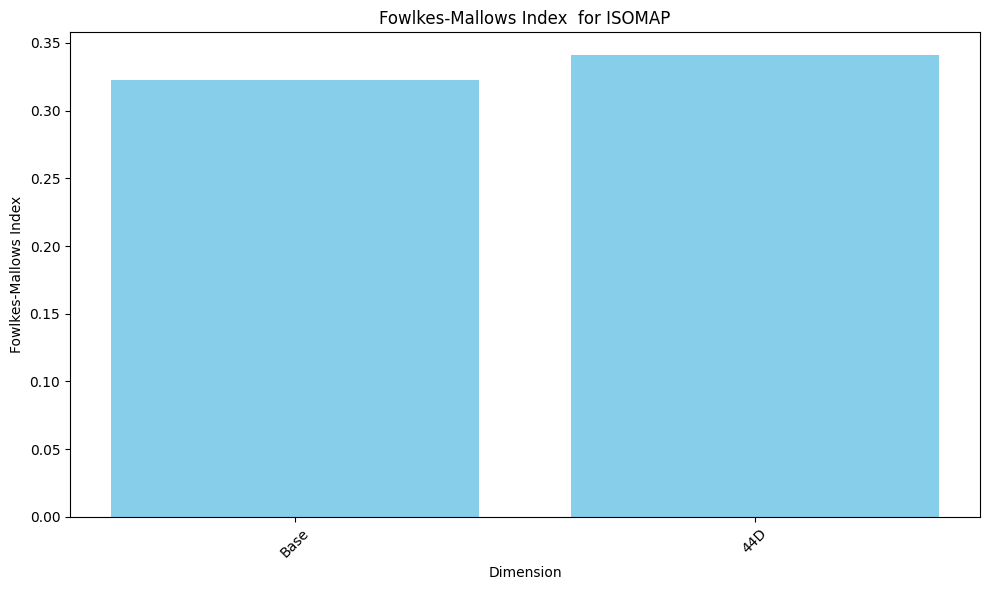

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1       44D               0.340750


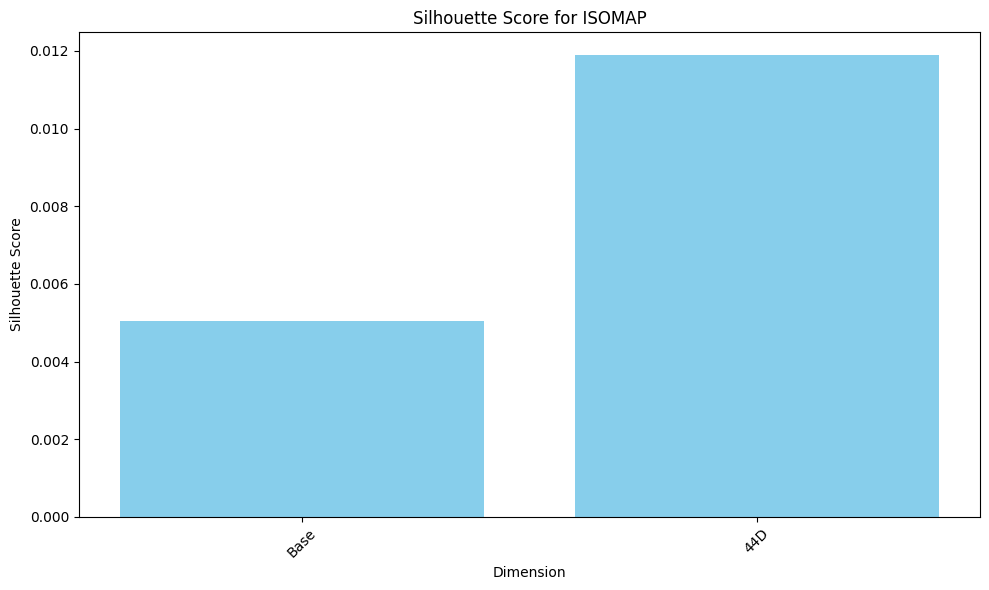

  Dimension  Silhouette Score
0      Base          0.005043
1       44D          0.011886


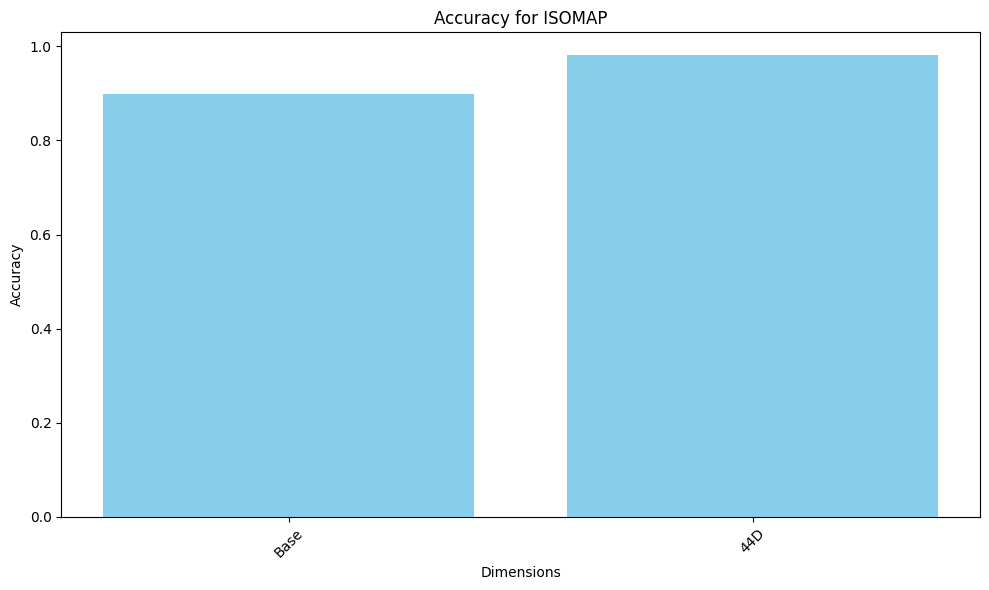

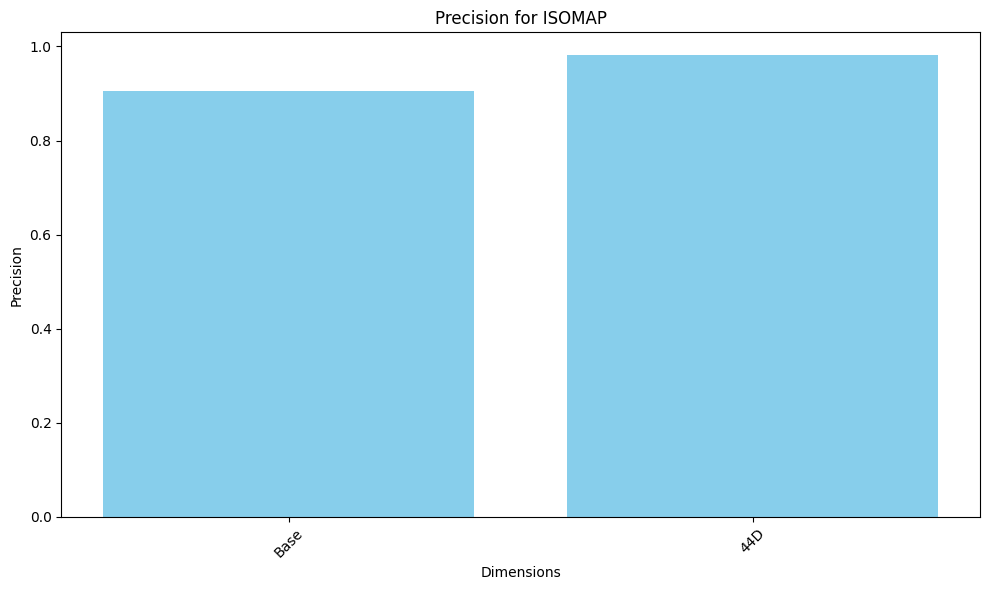

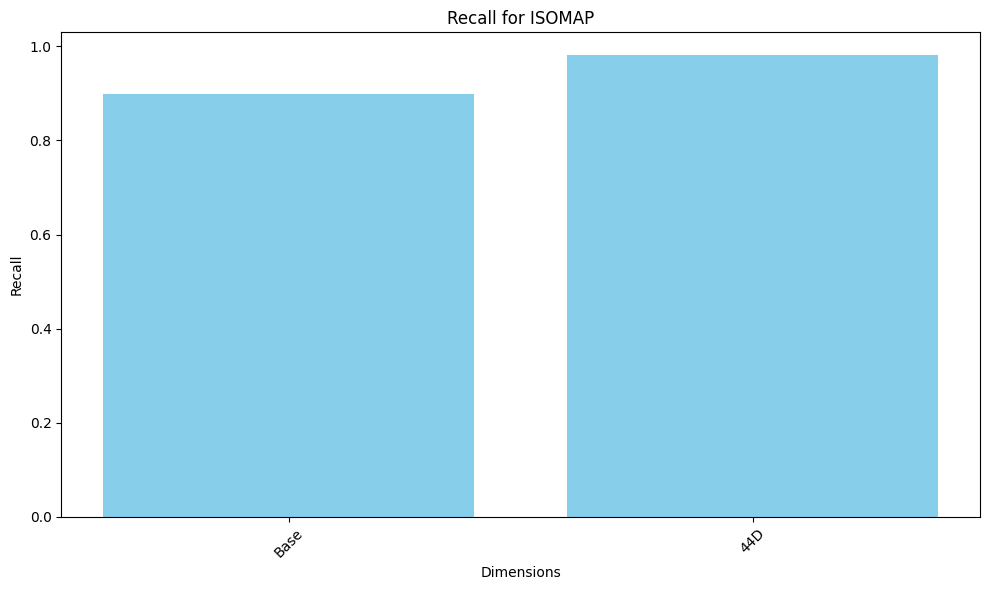

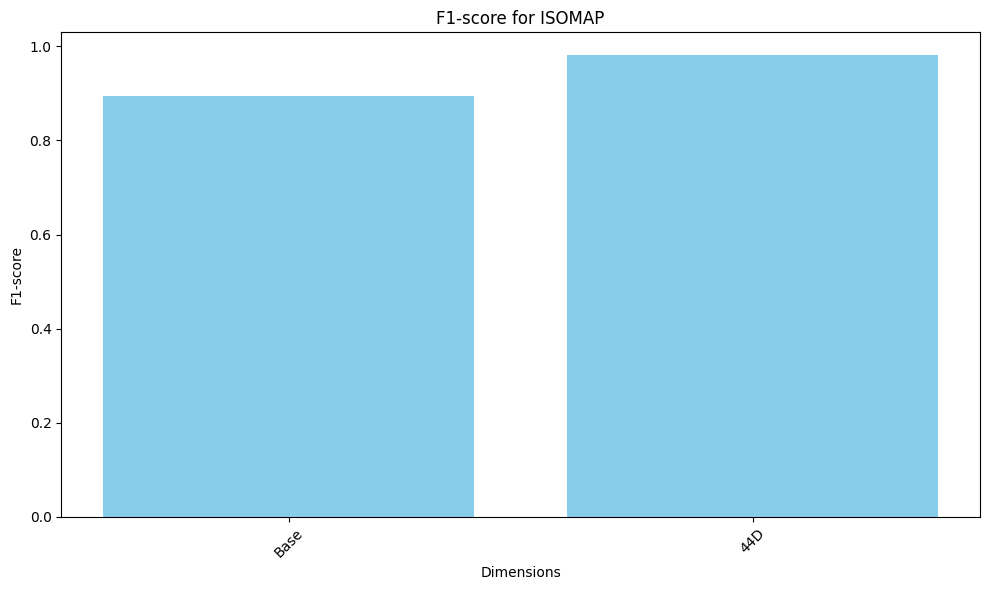

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1        44D  0.980729   0.981056  0.980729  0.980695


In [ ]:
# Initialize ISOMAP with best parameters
isomap = Isomap(n_components = 44)

# Fit ISOMAP to the preprocessed data
X_reduced = isomap.fit_transform(X)

# Compute the popular metrics
# Initialize lists to store the results
results_ch = []
results_db = []
results_fm = []
results_sil = []

# Compute metrics for the base case
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X, y)
db_score = davies_bouldin_score(X, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X, y)

results_ch.append(['Base', ch_score])
results_db.append(['Base', db_score])
results_fm.append(['Base', fm_score])
results_sil.append(['Base', sil_score])

name = "44D"
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X_reduced)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X_reduced, y)
db_score = davies_bouldin_score(X_reduced, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X_reduced, y)

results_ch.append([name, ch_score])
results_db.append([name, db_score])
results_fm.append([name, fm_score])
results_sil.append([name, sil_score])

# Convert results to DataFrames
df_ch = pd.DataFrame(results_ch, columns=['Dimension', 'Calinski-Harabasz Index'])
df_db = pd.DataFrame(results_db, columns=['Dimension', 'Davies-Bouldin Index'])
df_fm = pd.DataFrame(results_fm, columns=['Dimension', 'Fowlkes-Mallows Index'])
df_sil = pd.DataFrame(results_sil, columns=['Dimension', 'Silhouette Score'])

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for ISOMAP')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for ISOMAP')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for ISOMAP')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for ISOMAP')
print(df_sil)

# Initialize a list to store the results
classification_results = []

result = evaluate_classification(X, y, 'Base')
classification_results.append(result)

# Evaluate the classification performance on Isomap
name = "44D"
result = evaluate_classification(X_reduced, y, name)
classification_results.append(result)

df_results = pd.DataFrame(classification_results)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for ISOMAP')
plot_classification_results(df_results, 'Precision', 'Precision for ISOMAP')
plot_classification_results(df_results, 'Recall', 'Recall for ISOMAP')
plot_classification_results(df_results, 'F1-score', 'F1-score for ISOMAP')
print(df_results)

#  LLE Results

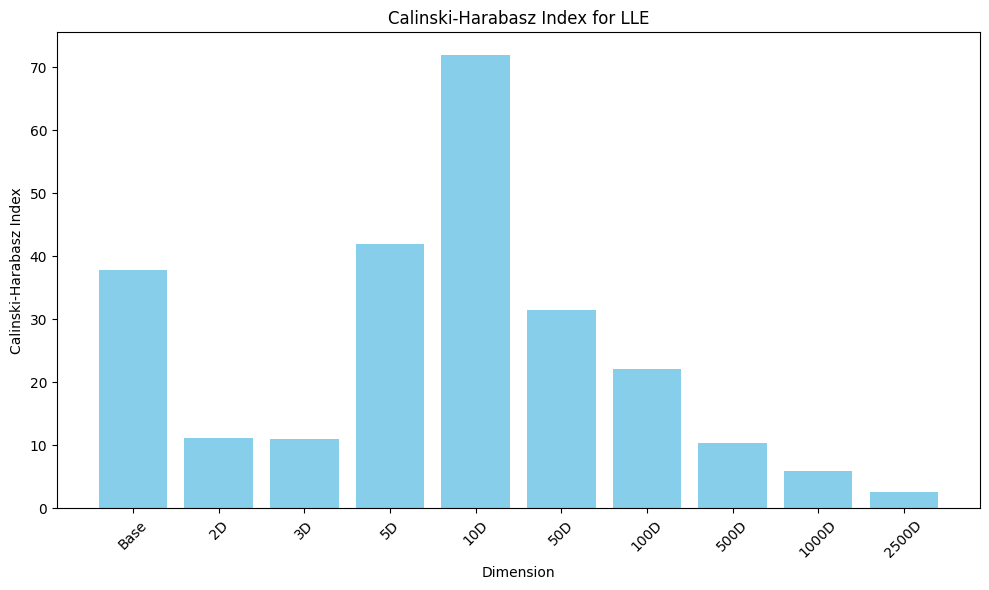

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1        2D                11.098939
2        3D                10.996907
3        5D                41.979907
4       10D                71.964853
5       50D                31.519094
6      100D                22.183690
7      500D                10.418134
8     1000D                 6.009674
9     2500D                 2.554173


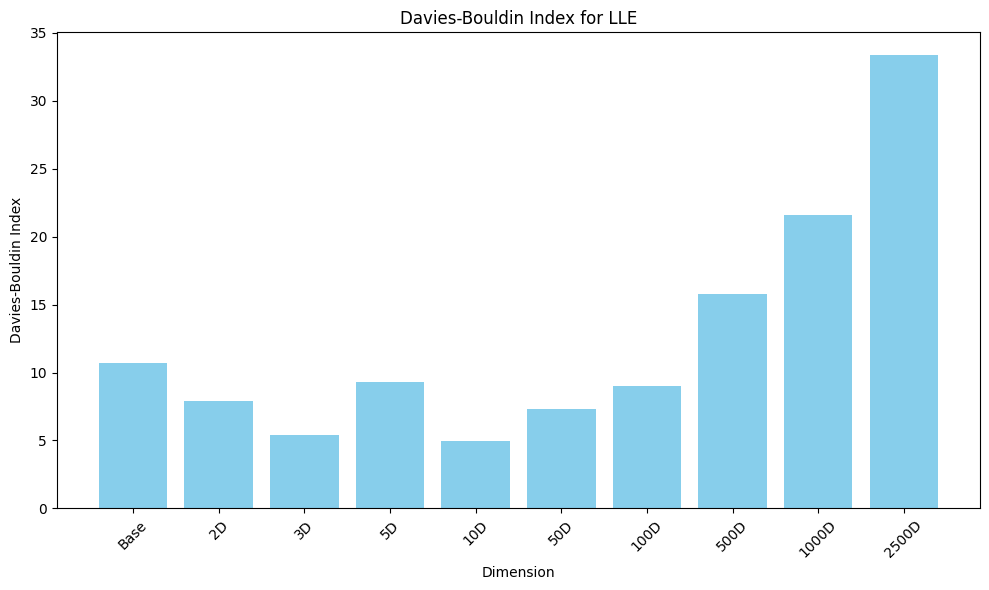

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1        2D              7.923320
2        3D              5.403527
3        5D              9.311034
4       10D              4.987164
5       50D              7.289250
6      100D              8.990363
7      500D             15.745918
8     1000D             21.582661
9     2500D             33.372621


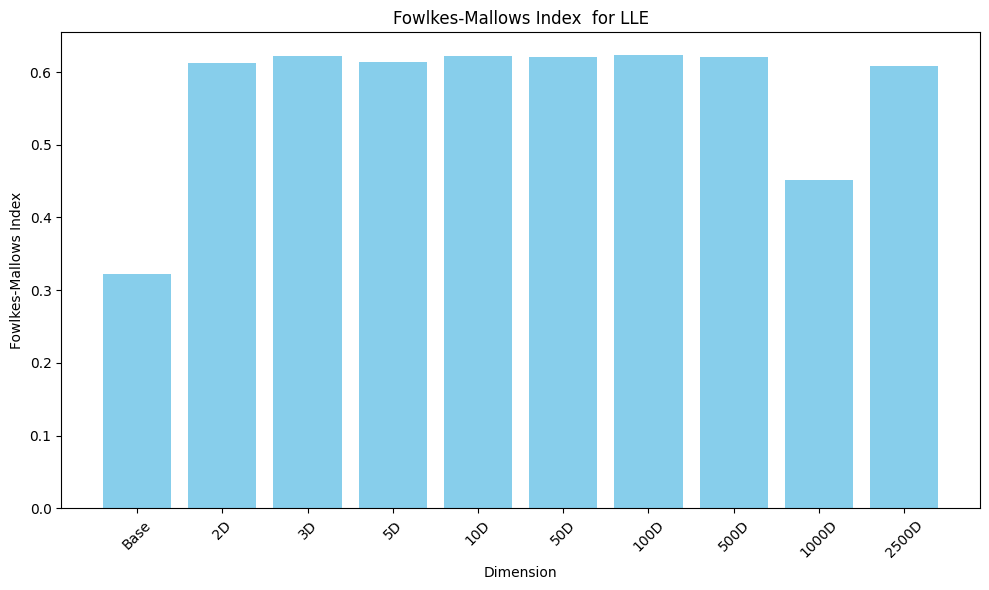

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1        2D               0.612111
2        3D               0.622544
3        5D               0.613313
4       10D               0.621440
5       50D               0.620522
6      100D               0.623418
7      500D               0.620212
8     1000D               0.451388
9     2500D               0.608843


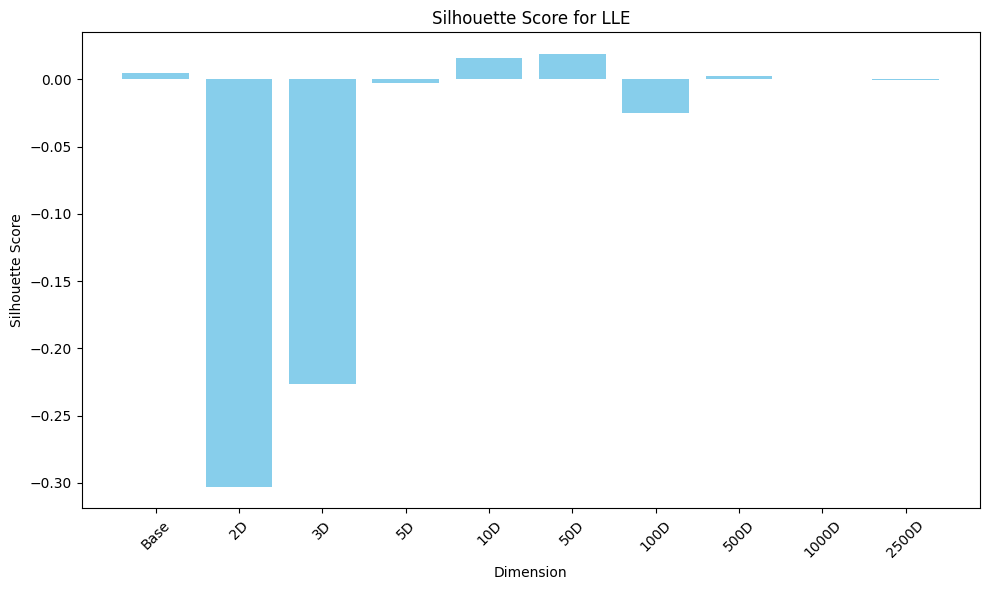

  Dimension  Silhouette Score
0      Base          0.005043
1        2D         -0.302786
2        3D         -0.226642
3        5D         -0.002410
4       10D          0.015897
5       50D          0.018977
6      100D         -0.024832
7      500D          0.002439
8     1000D          0.000463
9     2500D         -0.000595


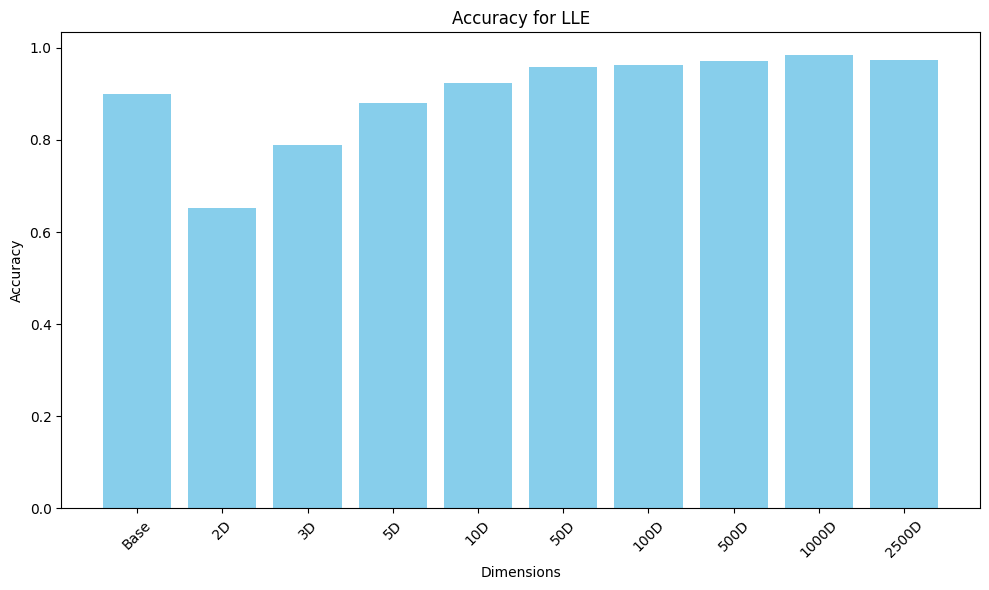

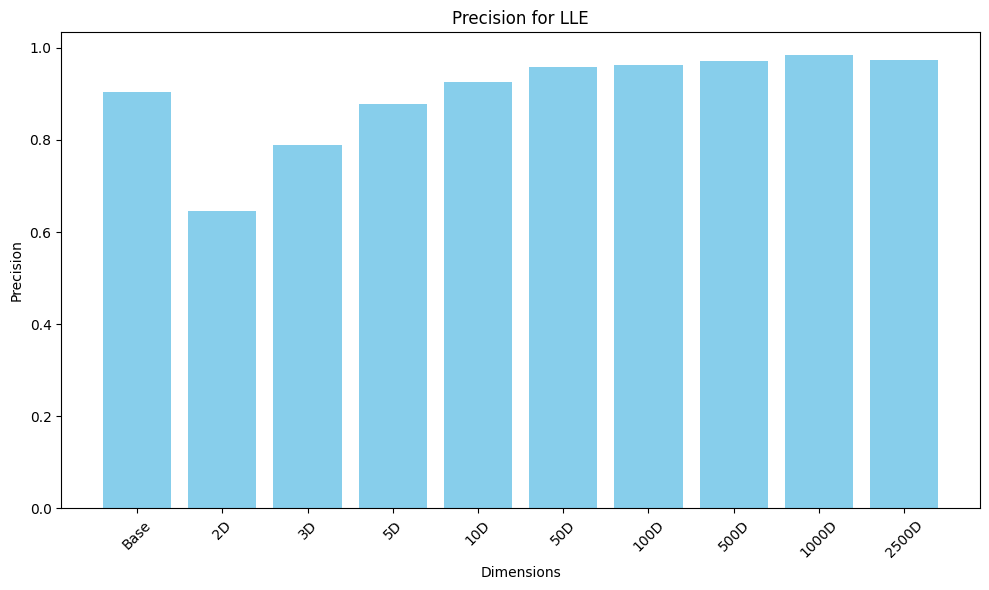

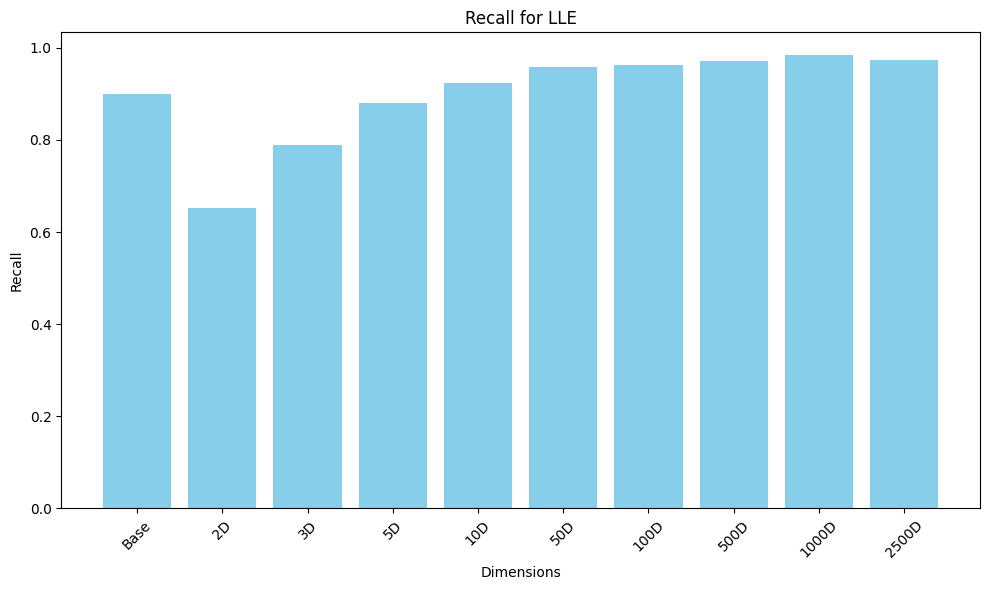

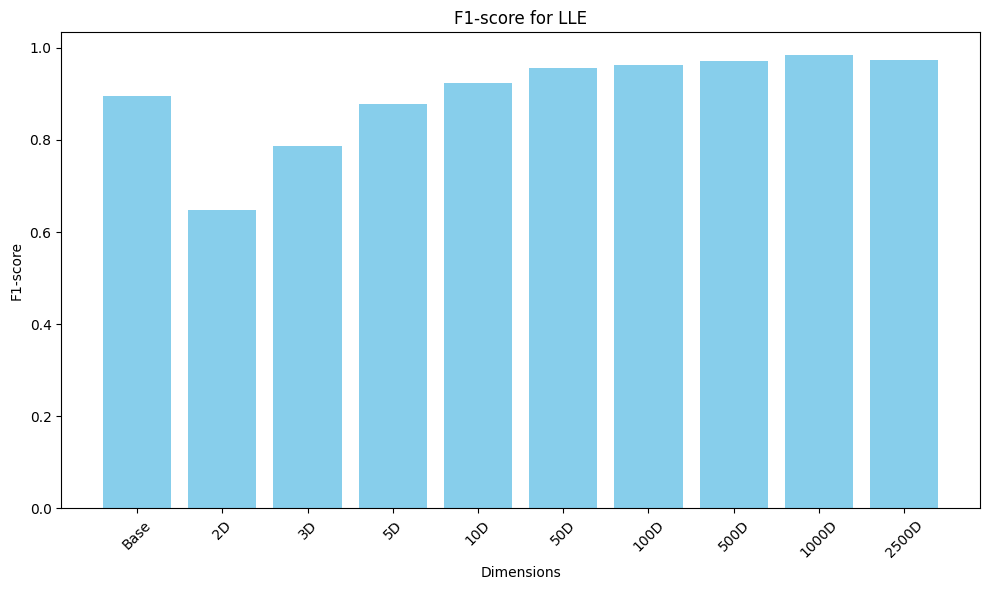

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1         2D  0.652604   0.646275  0.652604  0.647132
2         3D  0.789583   0.789417  0.789583  0.786355
3         5D  0.879167   0.878991  0.879167  0.878256
4        10D  0.924479   0.925498  0.924479  0.923845
5        50D  0.957292   0.957947  0.957292  0.957061
6       100D  0.963542   0.963784  0.963542  0.963399
7       500D  0.971354   0.971531  0.971354  0.971254
8      1000D  0.984375   0.984537  0.984375  0.984296
9      2500D  0.973437   0.974379  0.973437  0.973234


In [ ]:
# Array with the dimensions we want to explore
dimensions = [2, 3, 5, 10, 50, 100, 500, 1000, 2500]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, lle_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for LLE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for LLE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for LLE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for LLE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for LLE')
plot_classification_results(df_results, 'Precision', 'Precision for LLE')
plot_classification_results(df_results, 'Recall', 'Recall for LLE')
plot_classification_results(df_results, 'F1-score', 'F1-score for LLE')
print(df_results)

Check dimensions in the vecinity of the best result

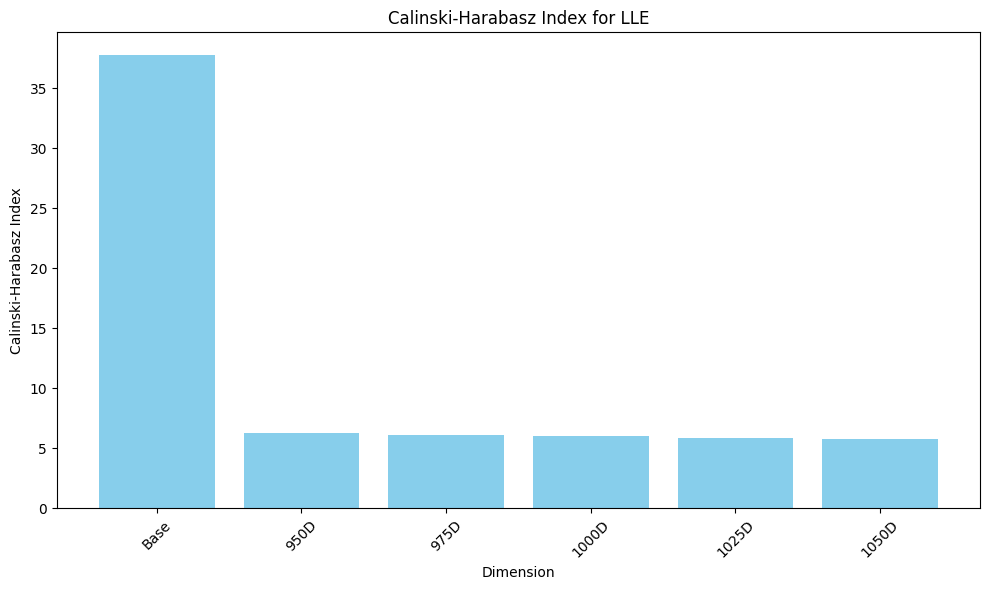

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1      950D                 6.280096
2      975D                 6.142077
3     1000D                 6.009674
4     1025D                 5.872796
5     1050D                 5.744545


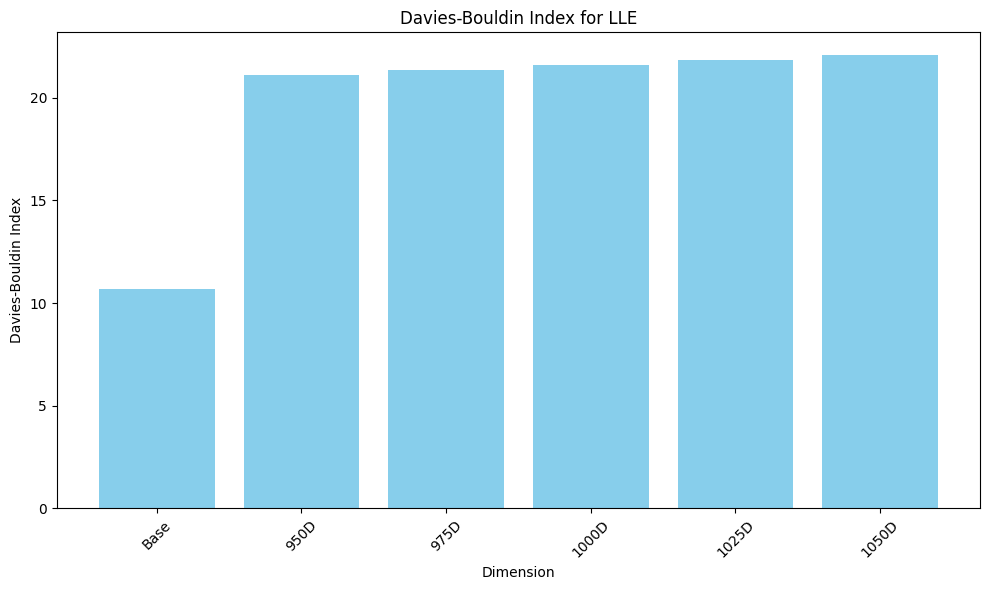

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1      950D             21.113633
2      975D             21.349458
3     1000D             21.582661
4     1025D             21.836619
5     1050D             22.078533


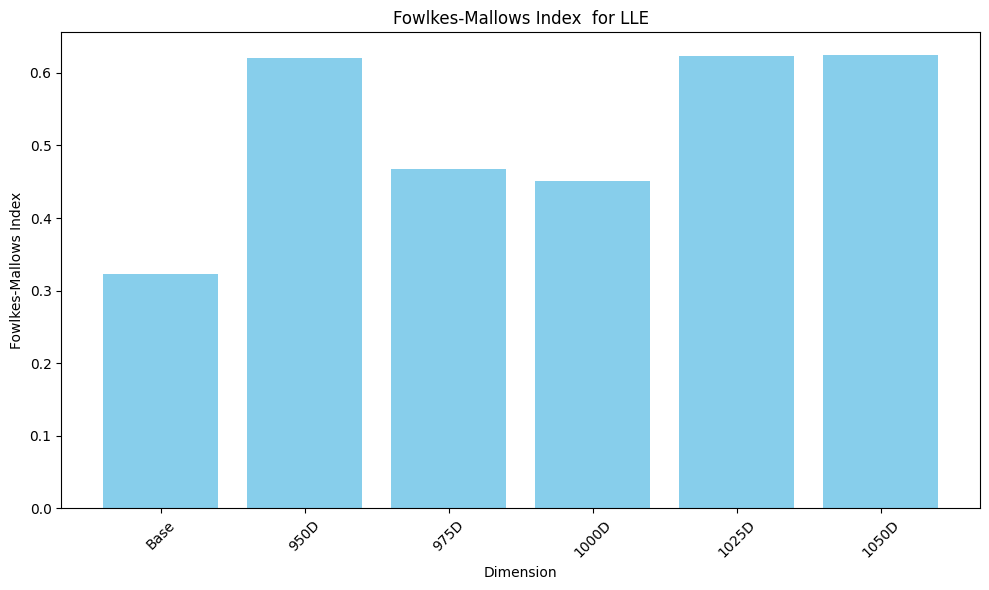

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1      950D               0.620944
2      975D               0.467128
3     1000D               0.451388
4     1025D               0.623375
5     1050D               0.624662


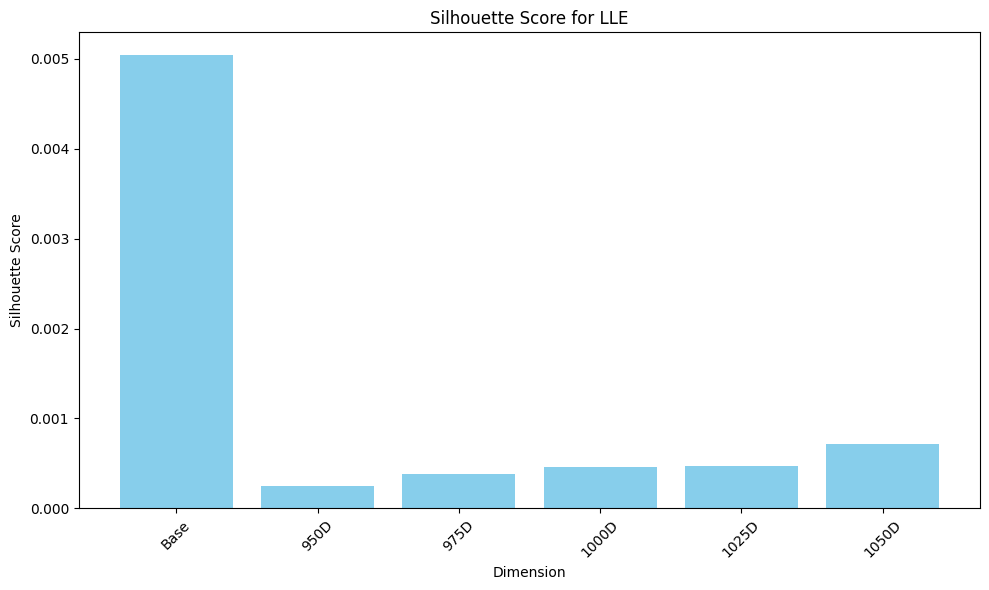

  Dimension  Silhouette Score
0      Base          0.005043
1      950D          0.000247
2      975D          0.000382
3     1000D          0.000463
4     1025D          0.000471
5     1050D          0.000718


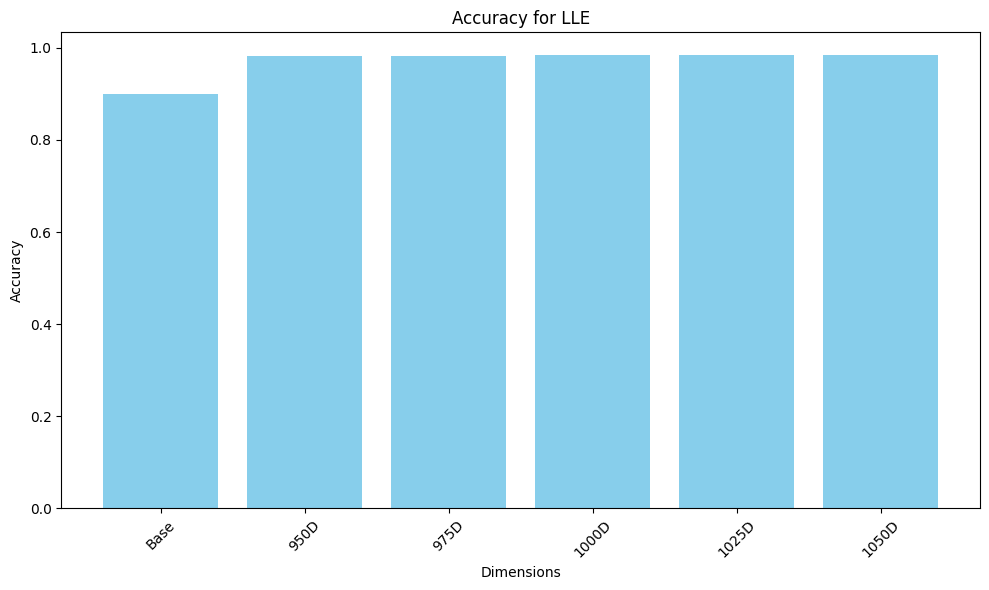

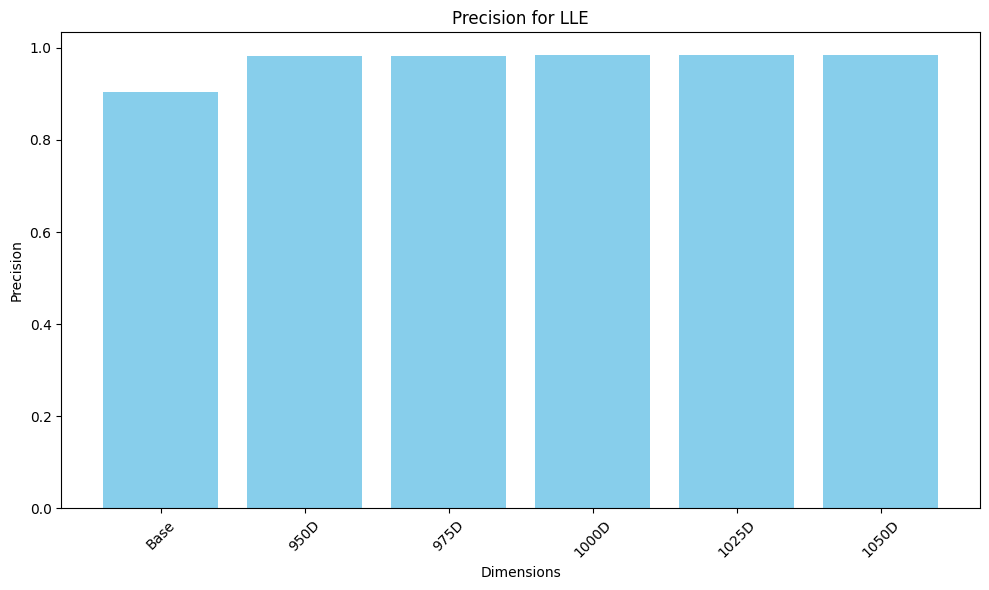

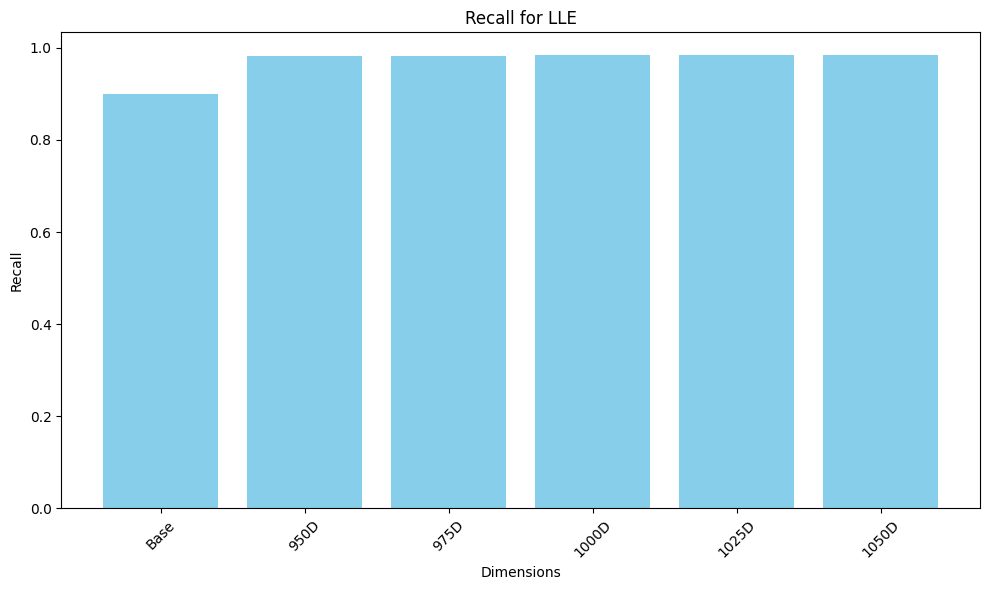

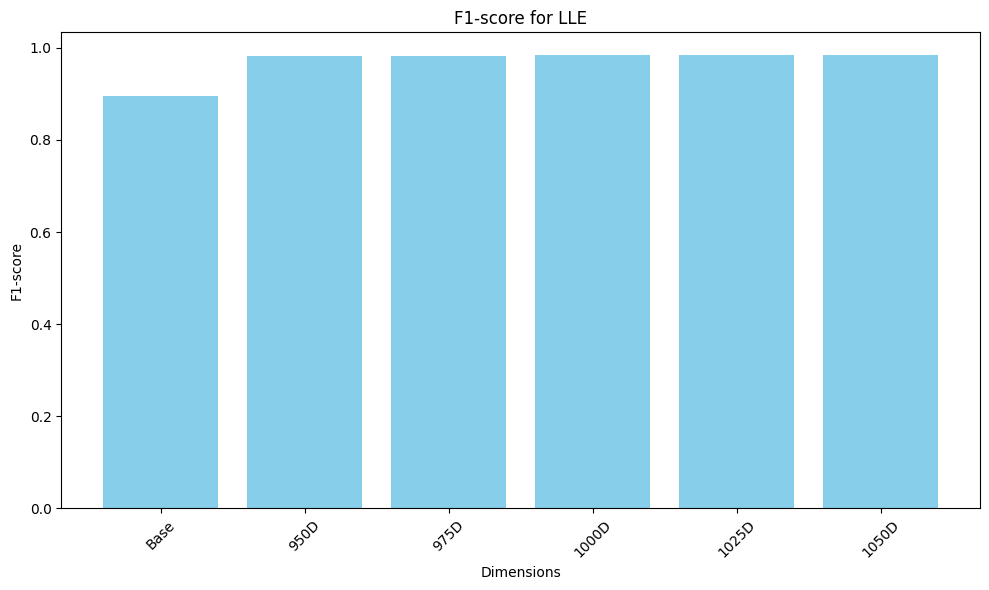

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1       950D  0.982812   0.982961  0.982812  0.982776
2       975D  0.982812   0.982941  0.982812  0.982759
3      1000D  0.984375   0.984537  0.984375  0.984296
4      1025D  0.984375   0.984534  0.984375  0.984307
5      1050D  0.983854   0.983974  0.983854  0.983785


In [ ]:
# Array with the dimensions we want to explore
dimensions = [950, 975, 1000, 1025, 1050]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, lle_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for LLE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for LLE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for LLE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for LLE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for LLE')
plot_classification_results(df_results, 'Precision', 'Precision for LLE')
plot_classification_results(df_results, 'Recall', 'Recall for LLE')
plot_classification_results(df_results, 'F1-score', 'F1-score for LLE')
print(df_results)

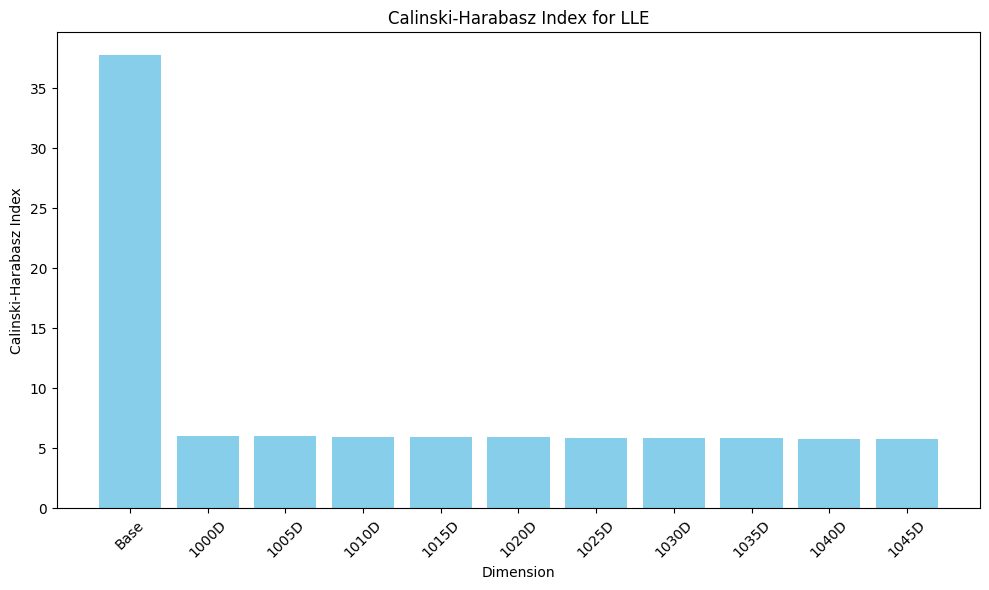

   Dimension  Calinski-Harabasz Index
0       Base                37.762006
1      1000D                 6.009674
2      1005D                 5.981949
3      1010D                 5.955439
4      1015D                 5.927310
5      1020D                 5.900278
6      1025D                 5.872796
7      1030D                 5.846198
8      1035D                 5.822233
9      1040D                 5.796172
10     1045D                 5.769951


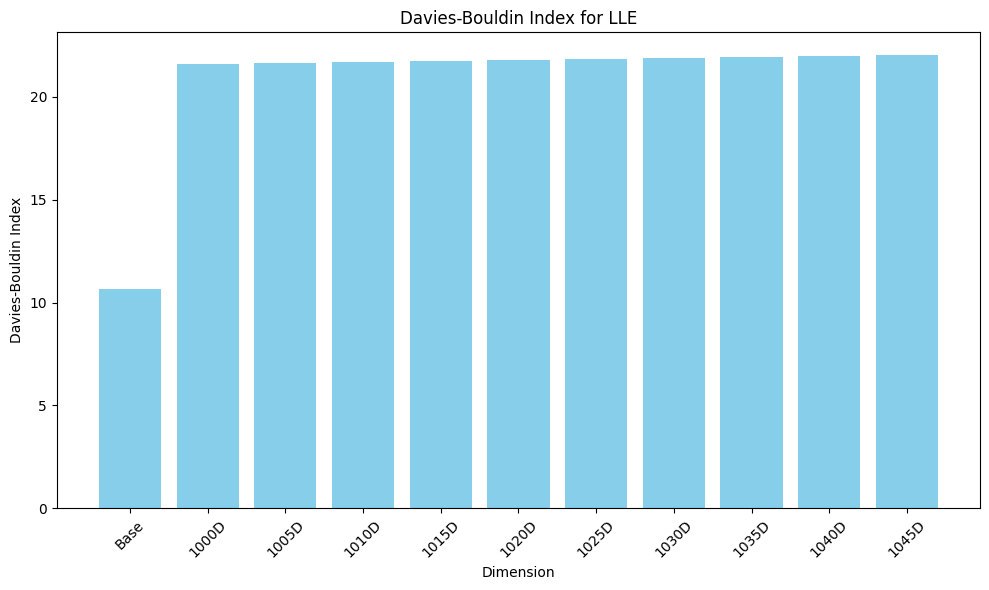

   Dimension  Davies-Bouldin Index
0       Base             10.674452
1      1000D             21.582661
2      1005D             21.632792
3      1010D             21.681640
4      1015D             21.735537
5      1020D             21.783789
6      1025D             21.836619
7      1030D             21.886142
8      1035D             21.928573
9      1040D             21.978519
10     1045D             22.030419


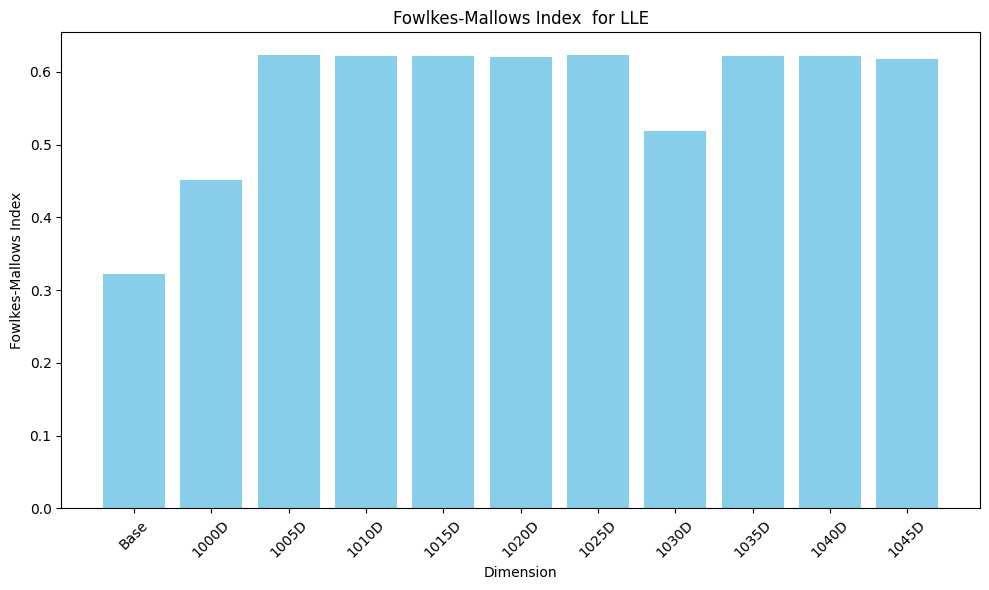

   Dimension  Fowlkes-Mallows Index
0       Base               0.322841
1      1000D               0.451388
2      1005D               0.622984
3      1010D               0.621635
4      1015D               0.622214
5      1020D               0.620799
6      1025D               0.623375
7      1030D               0.518607
8      1035D               0.622094
9      1040D               0.622094
10     1045D               0.617783


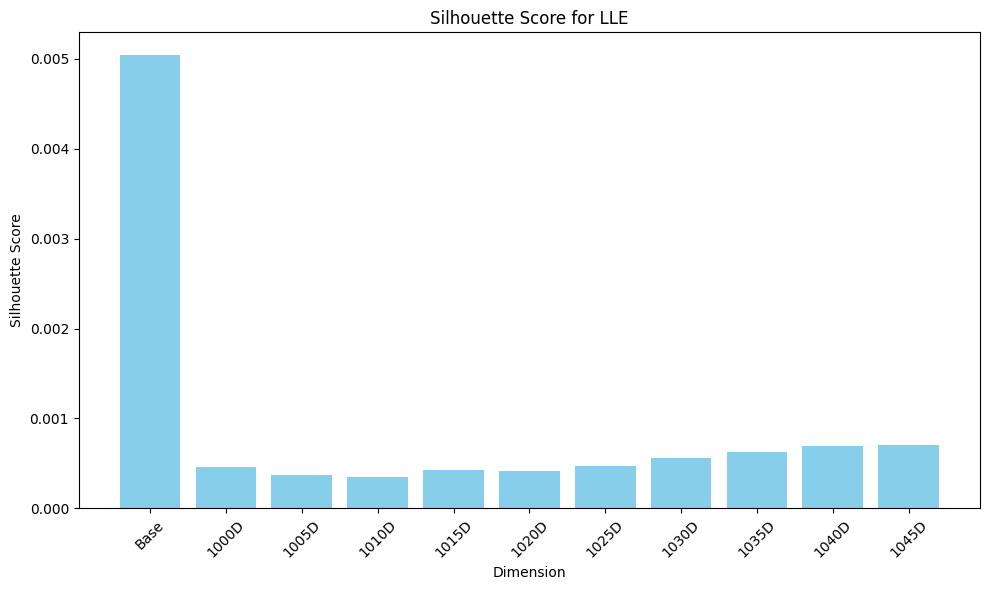

   Dimension  Silhouette Score
0       Base          0.005043
1      1000D          0.000463
2      1005D          0.000373
3      1010D          0.000347
4      1015D          0.000432
5      1020D          0.000411
6      1025D          0.000471
7      1030D          0.000554
8      1035D          0.000627
9      1040D          0.000689
10     1045D          0.000705


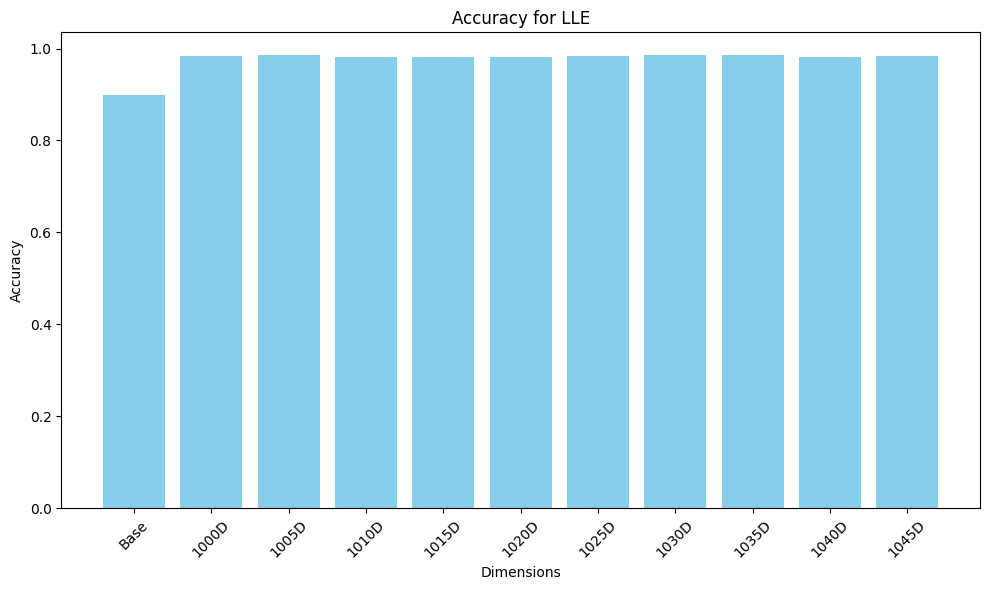

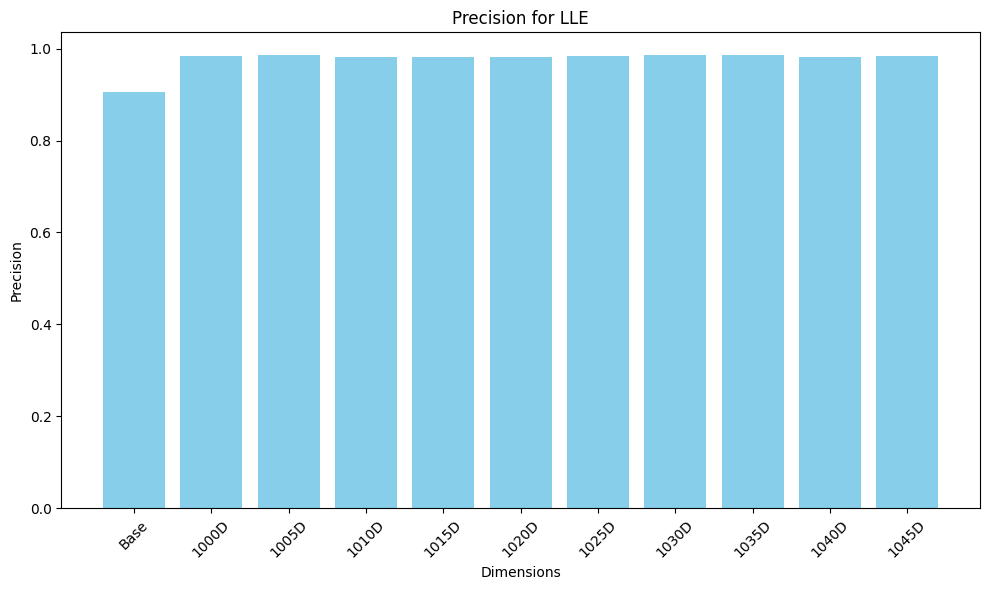

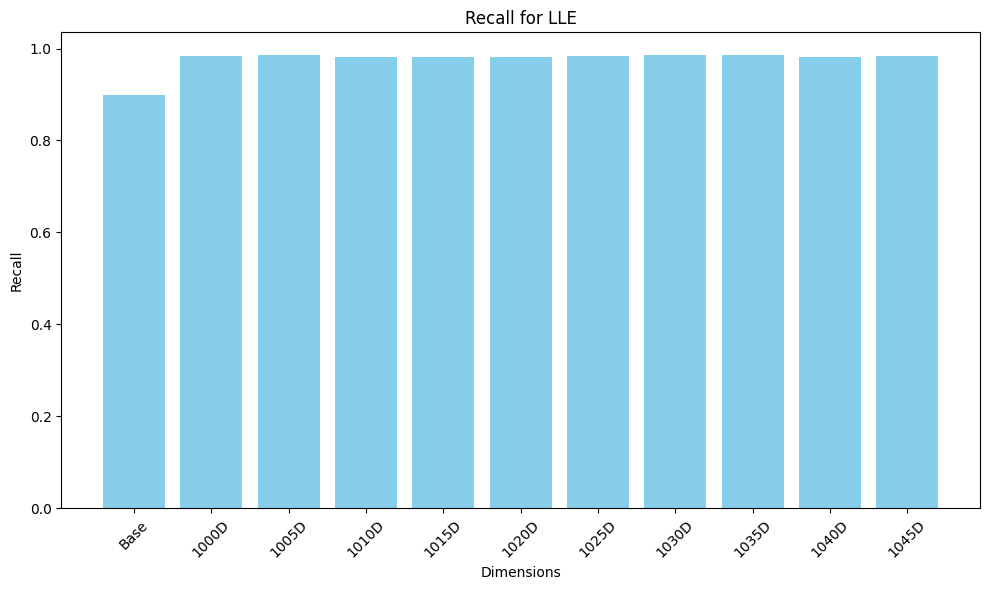

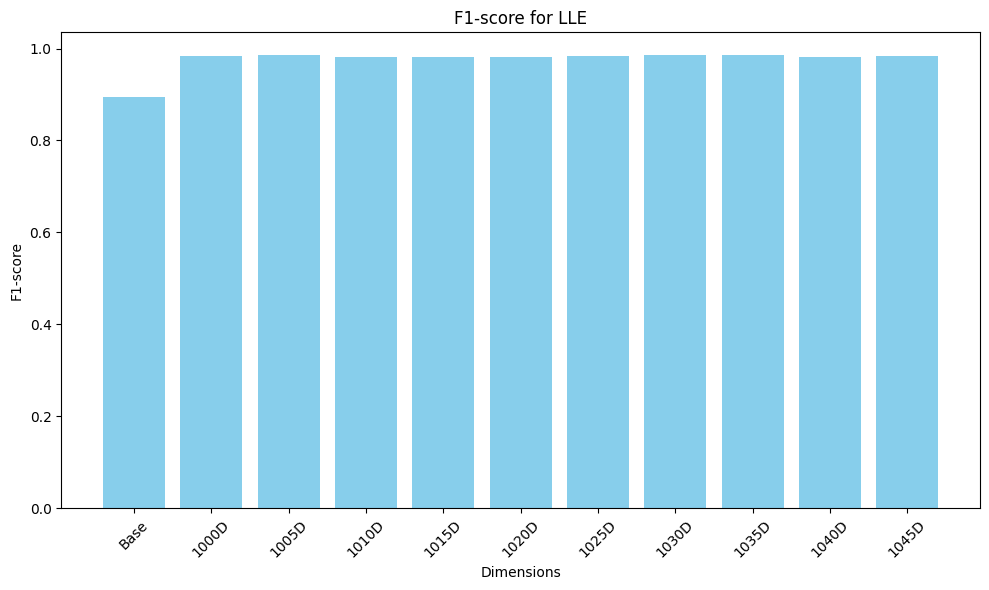

   Dimensions  Accuracy  Precision    Recall  F1-score
0        Base  0.898958   0.904731  0.898958  0.894862
1       1000D  0.984375   0.984537  0.984375  0.984296
2       1005D  0.985417   0.985550  0.985417  0.985365
3       1010D  0.981250   0.981453  0.981250  0.981214
4       1015D  0.982292   0.982490  0.982292  0.982205
5       1020D  0.982292   0.982497  0.982292  0.982206
6       1025D  0.984375   0.984534  0.984375  0.984307
7       1030D  0.985938   0.986053  0.985938  0.985899
8       1035D  0.985417   0.985569  0.985417  0.985371
9       1040D  0.981250   0.981447  0.981250  0.981184
10      1045D  0.983333   0.983516  0.983333  0.983244


In [ ]:
# Array with the dimensions we want to explore
dimensions = [1000, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, lle_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for LLE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for LLE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for LLE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for LLE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for LLE')
plot_classification_results(df_results, 'Precision', 'Precision for LLE')
plot_classification_results(df_results, 'Recall', 'Recall for LLE')
plot_classification_results(df_results, 'F1-score', 'F1-score for LLE')
print(df_results)

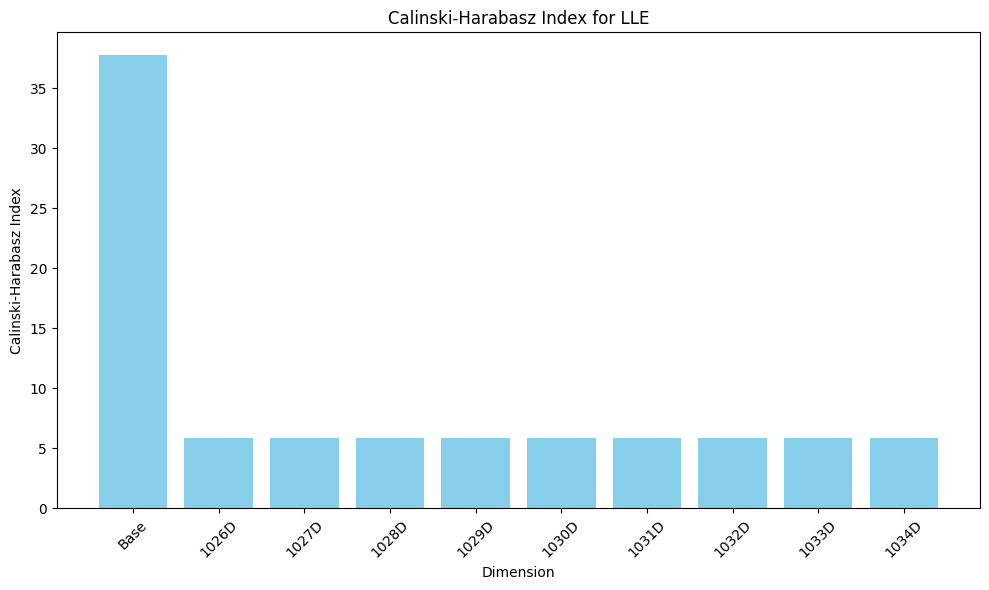

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1     1026D                 5.867480
2     1027D                 5.861857
3     1028D                 5.857503
4     1029D                 5.851871
5     1030D                 5.846198
6     1031D                 5.840803
7     1032D                 5.835838
8     1033D                 5.832840
9     1034D                 5.827834


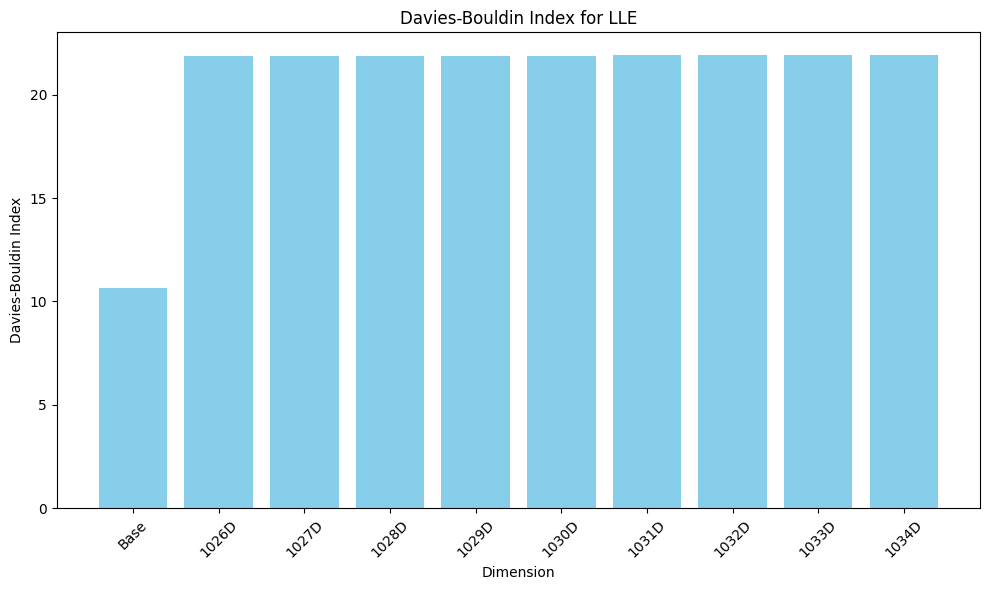

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1     1026D             21.846762
2     1027D             21.857675
3     1028D             21.863803
4     1029D             21.874955
5     1030D             21.886142
6     1031D             21.897156
7     1032D             21.905480
8     1033D             21.908489
9     1034D             21.917245


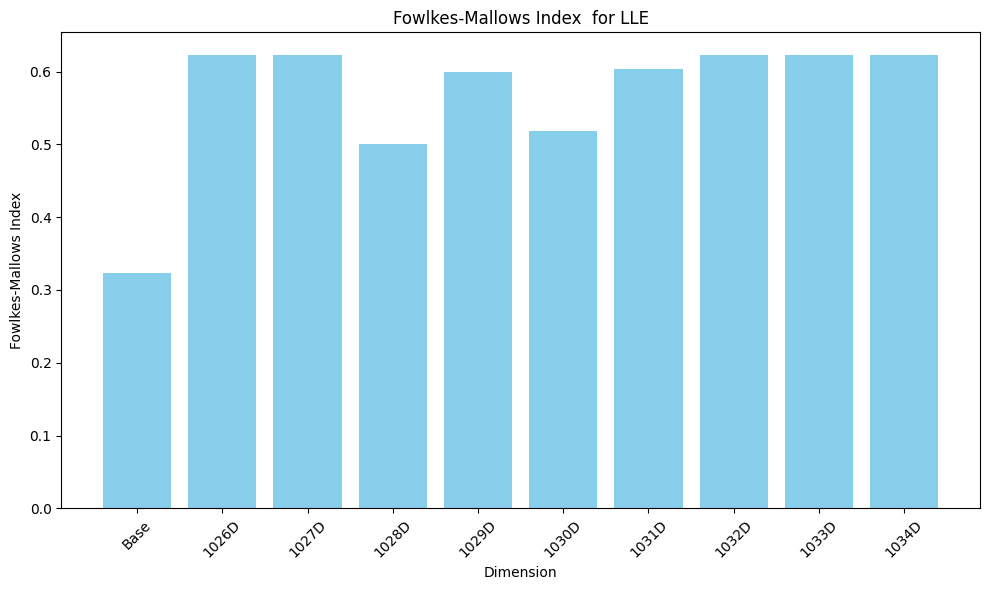

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1     1026D               0.622557
2     1027D               0.622557
3     1028D               0.501227
4     1029D               0.598798
5     1030D               0.518607
6     1031D               0.603900
7     1032D               0.622833
8     1033D               0.622833
9     1034D               0.622244


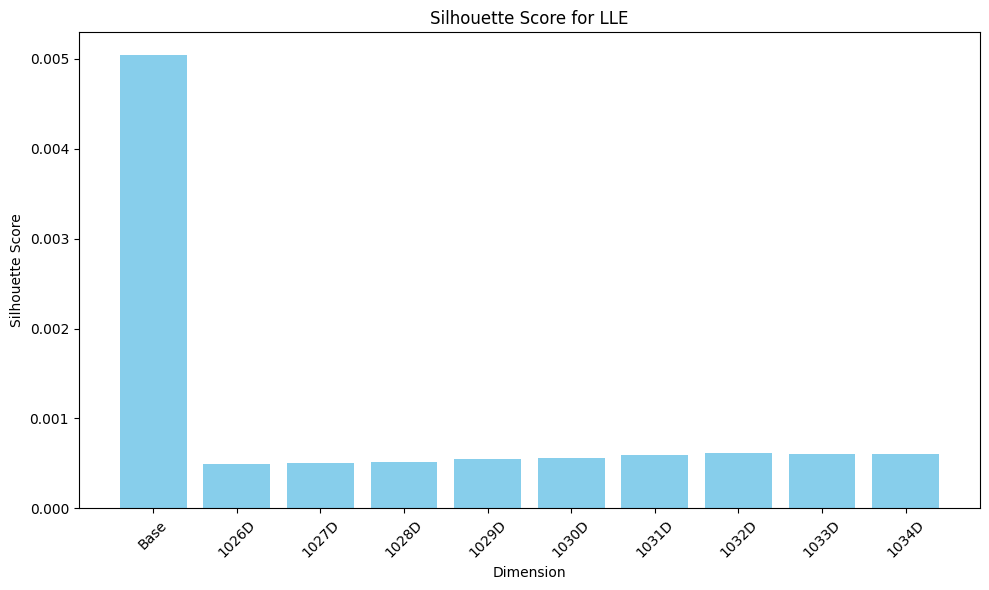

  Dimension  Silhouette Score
0      Base          0.005043
1     1026D          0.000497
2     1027D          0.000508
3     1028D          0.000514
4     1029D          0.000551
5     1030D          0.000554
6     1031D          0.000589
7     1032D          0.000617
8     1033D          0.000607
9     1034D          0.000608


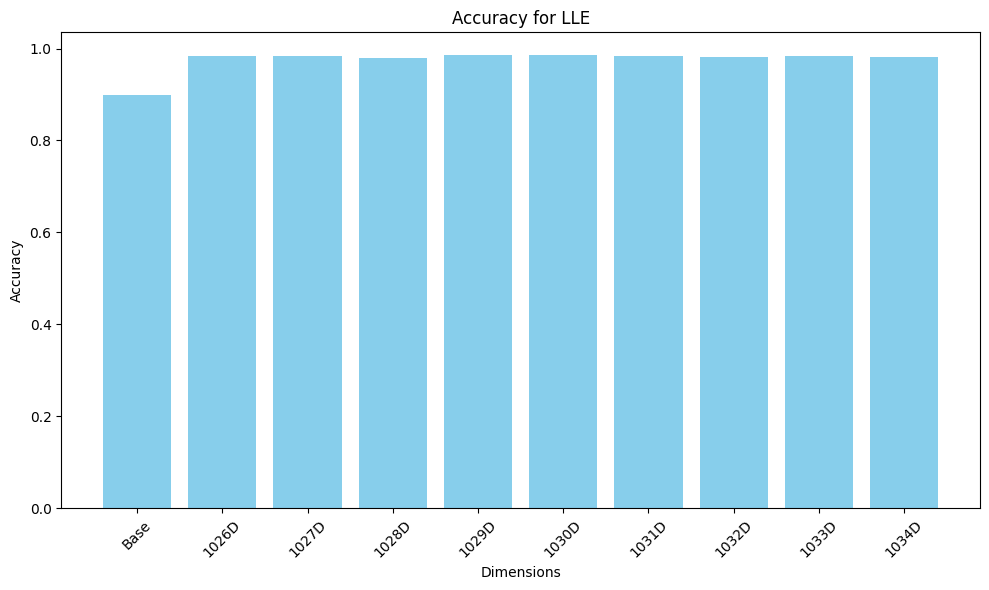

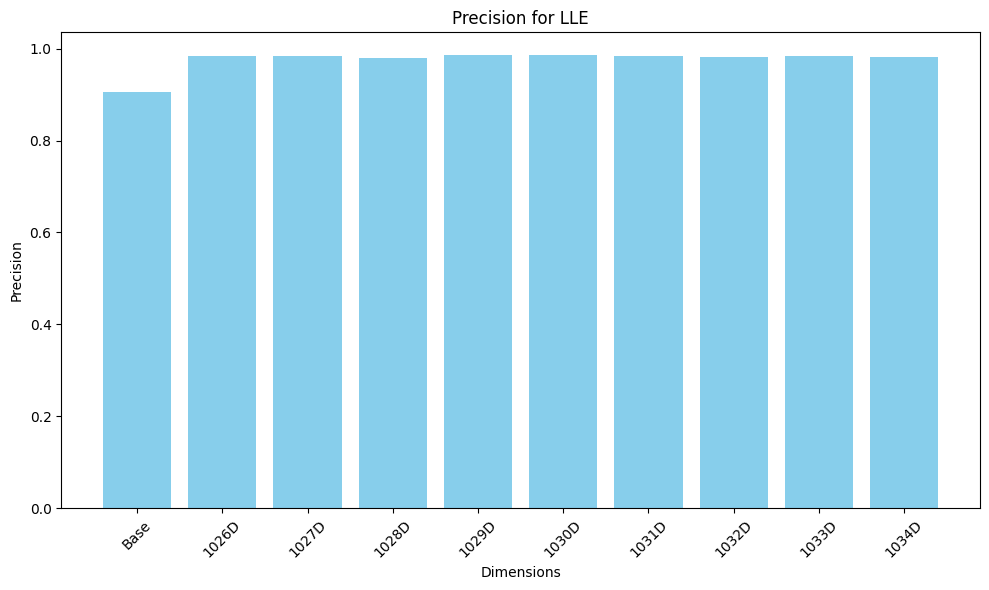

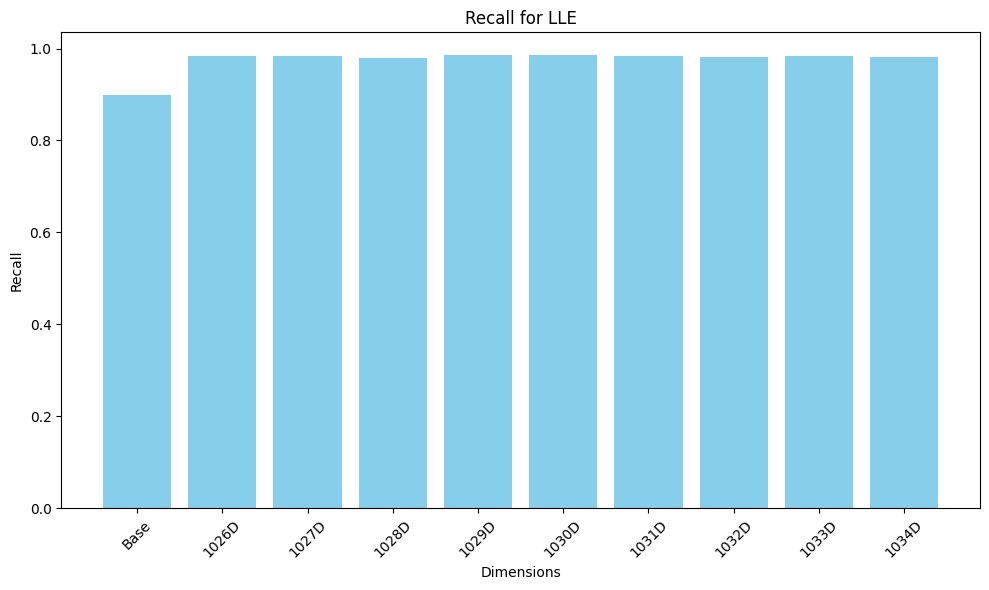

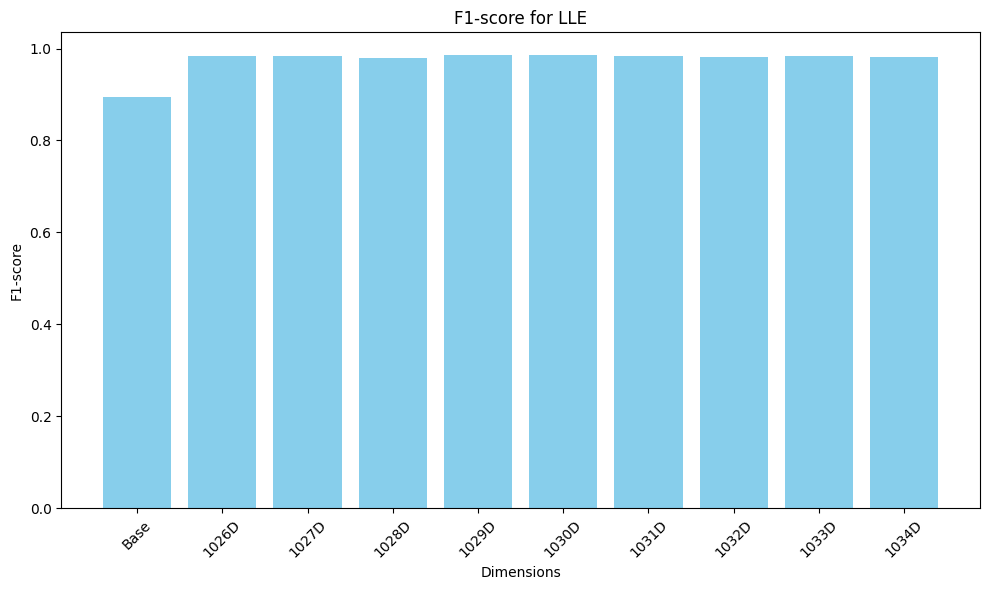

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1      1026D  0.982812   0.983012  0.982812  0.982711
2      1027D  0.982812   0.982981  0.982812  0.982770
3      1028D  0.980208   0.980457  0.980208  0.980118
4      1029D  0.985417   0.985547  0.985417  0.985370
5      1030D  0.985938   0.986053  0.985938  0.985899
6      1031D  0.982812   0.983002  0.982812  0.982726
7      1032D  0.981250   0.981457  0.981250  0.981179
8      1033D  0.983854   0.984010  0.983854  0.983789
9      1034D  0.982292   0.982502  0.982292  0.982217


In [ ]:
# Array with the dimensions we want to explore
dimensions = [1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, lle_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for LLE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for LLE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for LLE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for LLE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for LLE')
plot_classification_results(df_results, 'Precision', 'Precision for LLE')
plot_classification_results(df_results, 'Recall', 'Recall for LLE')
plot_classification_results(df_results, 'F1-score', 'F1-score for LLE')
print(df_results)

# LLE Parameter Tuning

In [ ]:
params = ['default', 'n_neighbors = 10',  'n_neighbors = 15',  'n_neighbors = 20']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize LLE default neighbors_algorithm = 'auto'
lle = LocallyLinearEmbedding(n_components = 1030)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE n_neighbors = 10
lle = LocallyLinearEmbedding(n_components = 1030, n_neighbors = 10)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE n_neighbors = 15
lle = LocallyLinearEmbedding(n_components = 1030, n_neighbors = 15)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE n_neighbors = 20
lle = LocallyLinearEmbedding(n_components = 1030, n_neighbors = 20)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

          Parameter  Accuracy  Precision    Recall  F1-score
0              Base  0.898958   0.904731  0.898958  0.894862
1           default  0.985938   0.986053  0.985938  0.985899
2  n_neighbors = 10  0.963542   0.965164  0.963542  0.962911
3  n_neighbors = 15  0.964063   0.966040  0.964063  0.963254
4  n_neighbors = 20  0.956250   0.958537  0.956250  0.955497


In [ ]:
params = ['default', 'eigen_solver = arpack',  'eigen_solver = dense']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize LLE default eigen_solver = 'auto'
lle = LocallyLinearEmbedding(n_components = 1030)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE eigen_solver = 'arpack'
lle = LocallyLinearEmbedding(n_components = 1030, eigen_solver = 'arpack', random_state = 42)

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE eigen_solver = 'dense'
lle = LocallyLinearEmbedding(n_components = 1030, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

               Parameter  Accuracy  Precision    Recall  F1-score
0                   Base  0.898958   0.904731  0.898958  0.894862
1                default  0.985938   0.986053  0.985938  0.985899
2  eigen_solver = arpack  0.982292   0.982490  0.982292  0.982232
3   eigen_solver = dense  0.986458   0.986567  0.986458  0.986418


In [ ]:
params = ['default', 'method = hessian 2D', 'method = hessian 3D',  'method = modified 2D', 'method = modified 3D', 'method = ltsa 2D', 'method = ltsa 3D', 'method = ltsa 4D', 'method = ltsa 5D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize LLE default method = 'standard'
lle = LocallyLinearEmbedding(n_components = 1030, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# LLE with method = 'hessian' must have n_neighbors > n_components * (n_components + 3) / 2
# In the case of our best n_components = 985, n_neighbors = 486591 which is too large
# Let's test this method on lower dimensions of 2 and 3
lle = LocallyLinearEmbedding(n_components = 2, method = 'hessian', n_neighbors = 6, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

lle = LocallyLinearEmbedding(n_components = 3, method = 'hessian', n_neighbors = 10, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE method = 'modified' requires n_neighbors >= n_components which is too large
# MemoryError: Unable to allocate 46.3 GiB for an array with shape (6400, 985, 985) and data type float64
# Let's test this method on lower dimensions of 2 and 3
lle = LocallyLinearEmbedding(n_components = 2, method = 'modified', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

lle = LocallyLinearEmbedding(n_components = 3, method = 'modified', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Initialize LLE method = 'ltsa' only applicable for 2, 3, 4 and 5 dimensions
# Let's try for all dimensions possible
lle = LocallyLinearEmbedding(n_components = 2, method = 'ltsa', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

lle = LocallyLinearEmbedding(n_components = 3, method = 'ltsa', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

lle = LocallyLinearEmbedding(n_components = 4, method = 'ltsa', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

lle = LocallyLinearEmbedding(n_components = 5, method = 'ltsa', eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_lle = lle.fit_transform(X)

# Append to array
X_reduced.append(X_lle)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:371: RuntimeWarning: invalid value encountered in scalar divide
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_locally_linear.py:371: RuntimeWarning: invalid value encountered in scalar divide
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


              Parameter  Accuracy  Precision    Recall  F1-score
0                  Base  0.898958   0.904731  0.898958  0.894862
1               default  0.986458   0.986567  0.986458  0.986418
2   method = hessian 2D  0.626563   0.622798  0.626563  0.621971
3   method = hessian 3D  0.597917   0.591170  0.597917  0.584124
4  method = modified 2D  0.753646   0.752691  0.753646  0.752430
5  method = modified 3D  0.874479   0.873989  0.874479  0.873824
6      method = ltsa 2D  0.705729   0.703091  0.705729  0.702124
7      method = ltsa 3D  0.859375   0.860690  0.859375  0.858991
8      method = ltsa 4D  0.520312   0.495744  0.520312  0.423338
9      method = ltsa 5D  0.693229   0.688048  0.693229  0.685255


# Best LLE Results

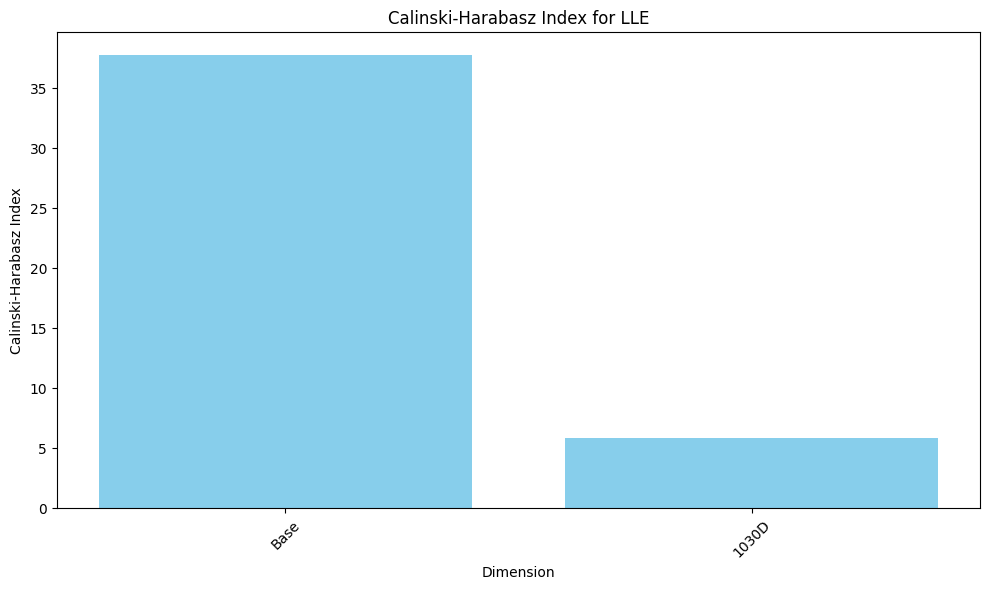

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1     1030D                 5.846198


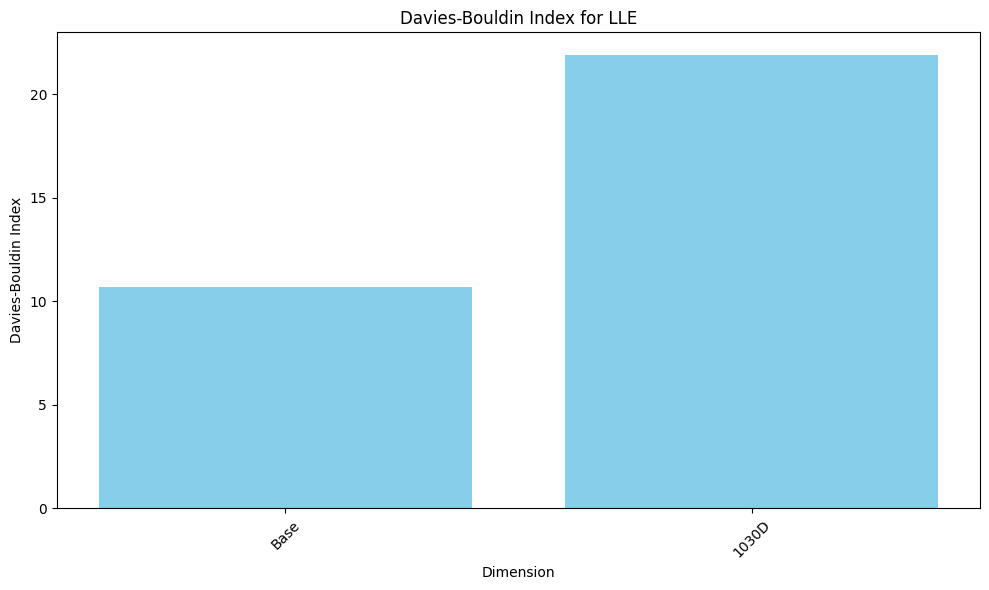

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1     1030D             21.886142


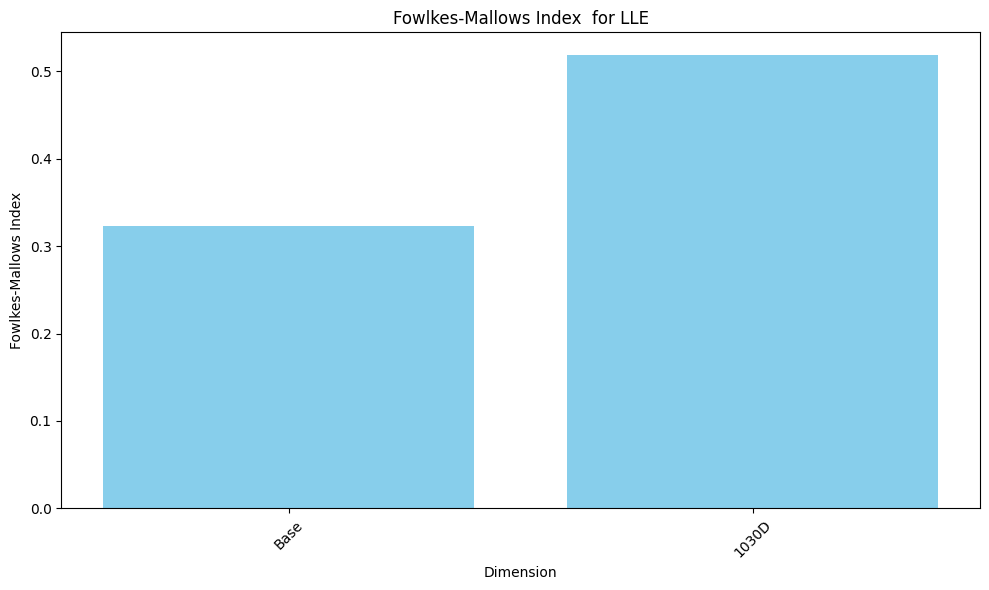

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1     1030D               0.518607


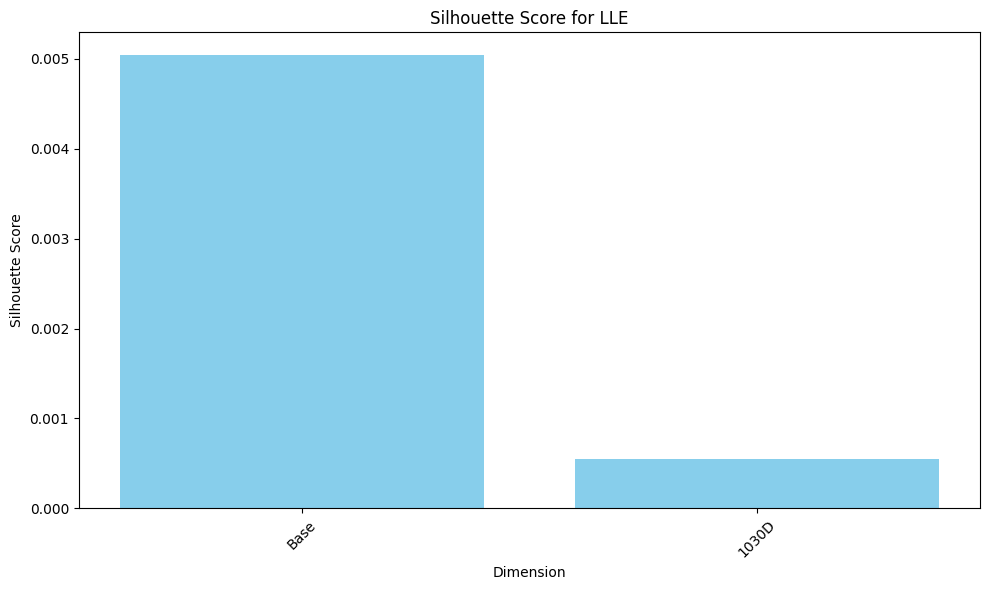

  Dimension  Silhouette Score
0      Base          0.005043
1     1030D          0.000554


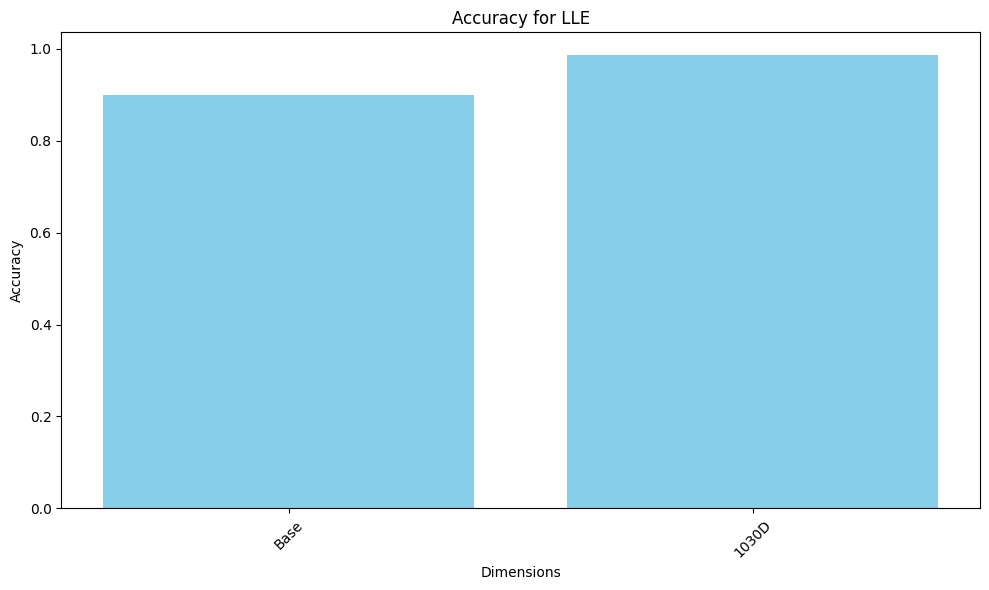

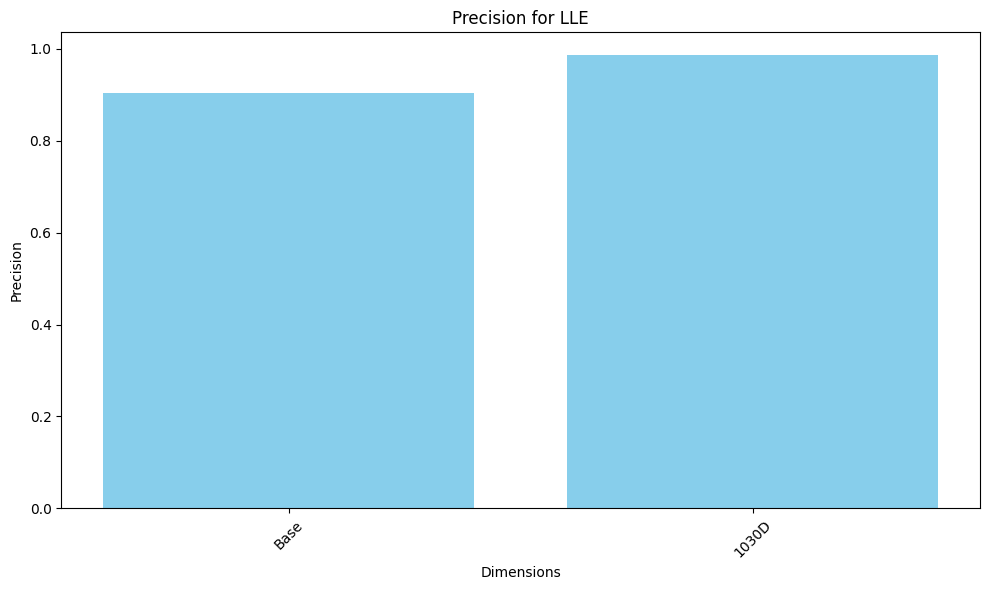

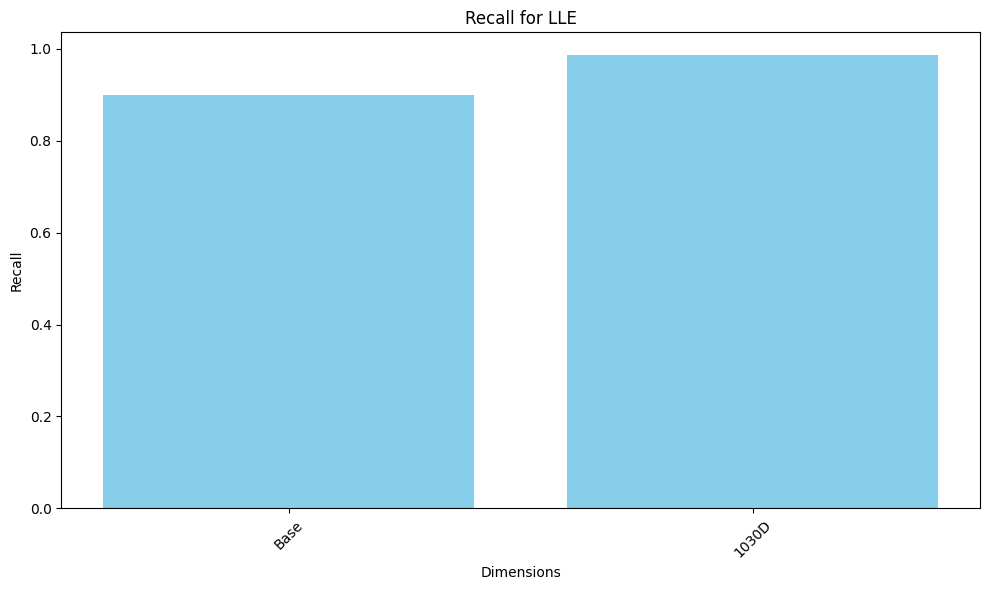

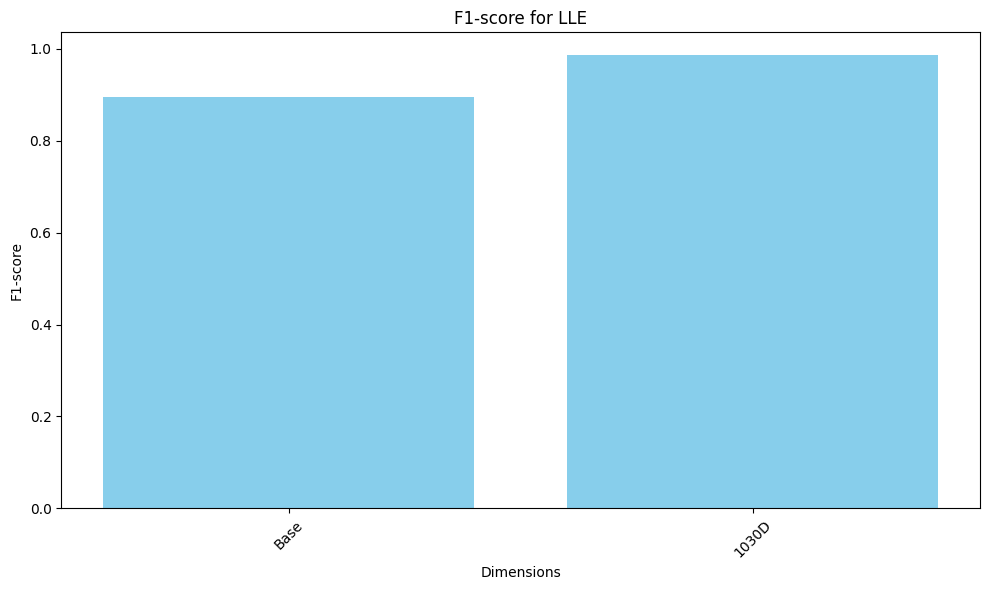

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1      1030D  0.986458   0.986567  0.986458  0.986418


In [ ]:
# Initialize LLE with best parameters
lle = LocallyLinearEmbedding(n_components = 1030, eigen_solver = 'dense')

# Fit LLE to the preprocessed data
X_reduced = lle.fit_transform(X)

# Compute the popular metrics
# Initialize lists to store the results
results_ch = []
results_db = []
results_fm = []
results_sil = []

# Compute metrics for the base case
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X, y)
db_score = davies_bouldin_score(X, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X, y)

results_ch.append(['Base', ch_score])
results_db.append(['Base', db_score])
results_fm.append(['Base', fm_score])
results_sil.append(['Base', sil_score])

name = "1030D"
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X_reduced)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X_reduced, y)
db_score = davies_bouldin_score(X_reduced, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X_reduced, y)

results_ch.append([name, ch_score])
results_db.append([name, db_score])
results_fm.append([name, fm_score])
results_sil.append([name, sil_score])

# Convert results to DataFrames
df_ch = pd.DataFrame(results_ch, columns=['Dimension', 'Calinski-Harabasz Index'])
df_db = pd.DataFrame(results_db, columns=['Dimension', 'Davies-Bouldin Index'])
df_fm = pd.DataFrame(results_fm, columns=['Dimension', 'Fowlkes-Mallows Index'])
df_sil = pd.DataFrame(results_sil, columns=['Dimension', 'Silhouette Score'])

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for LLE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for LLE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for LLE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for LLE')
print(df_sil)

# Initialize a list to store the results
classification_results = []

result = evaluate_classification(X, y, 'Base')
classification_results.append(result)

# Evaluate the classification performance on Isomap
name = "1030D"
result = evaluate_classification(X_reduced, y, name)
classification_results.append(result)

df_results = pd.DataFrame(classification_results)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for LLE')
plot_classification_results(df_results, 'Precision', 'Precision for LLE')
plot_classification_results(df_results, 'Recall', 'Recall for LLE')
plot_classification_results(df_results, 'F1-score', 'F1-score for LLE')
print(df_results)

# Diffusion Map Results

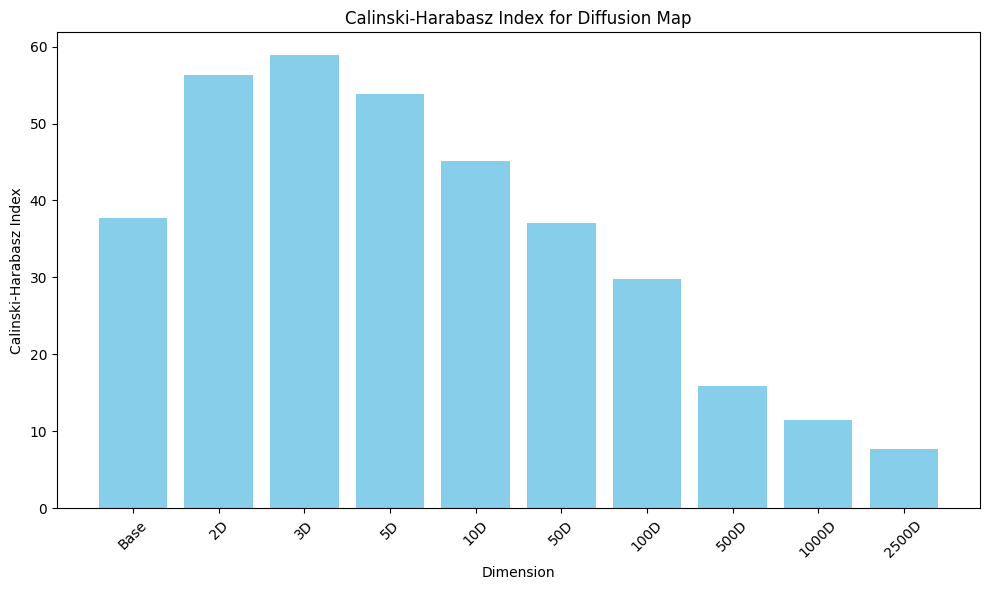

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1        2D                56.285000
2        3D                58.898597
3        5D                53.826512
4       10D                45.159721
5       50D                37.120442
6      100D                29.833678
7      500D                15.852789
8     1000D                11.476244
9     2500D                 7.726098


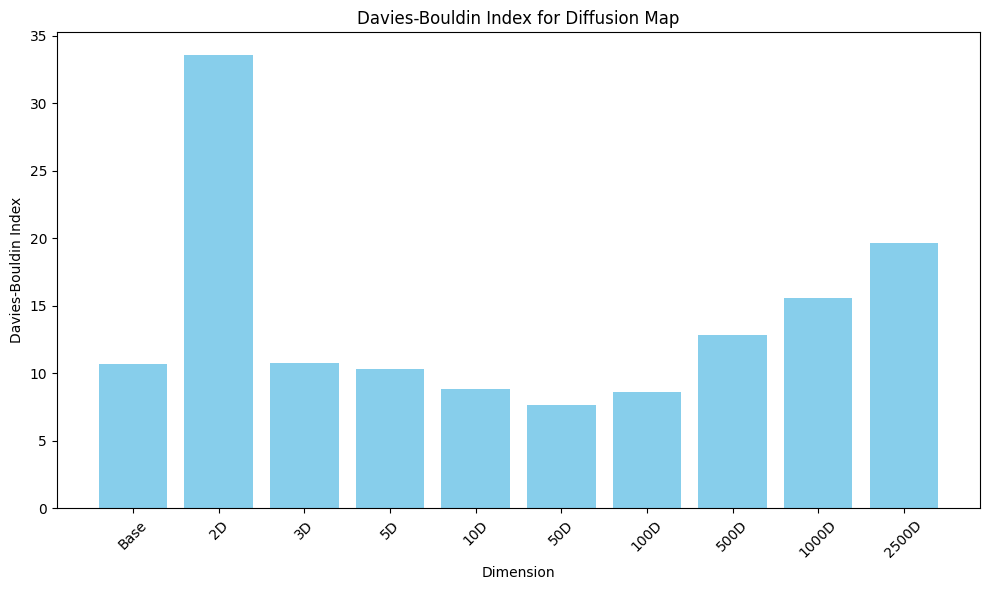

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1        2D             33.580014
2        3D             10.742808
3        5D             10.314414
4       10D              8.817952
5       50D              7.630271
6      100D              8.598554
7      500D             12.834621
8     1000D             15.587801
9     2500D             19.631896


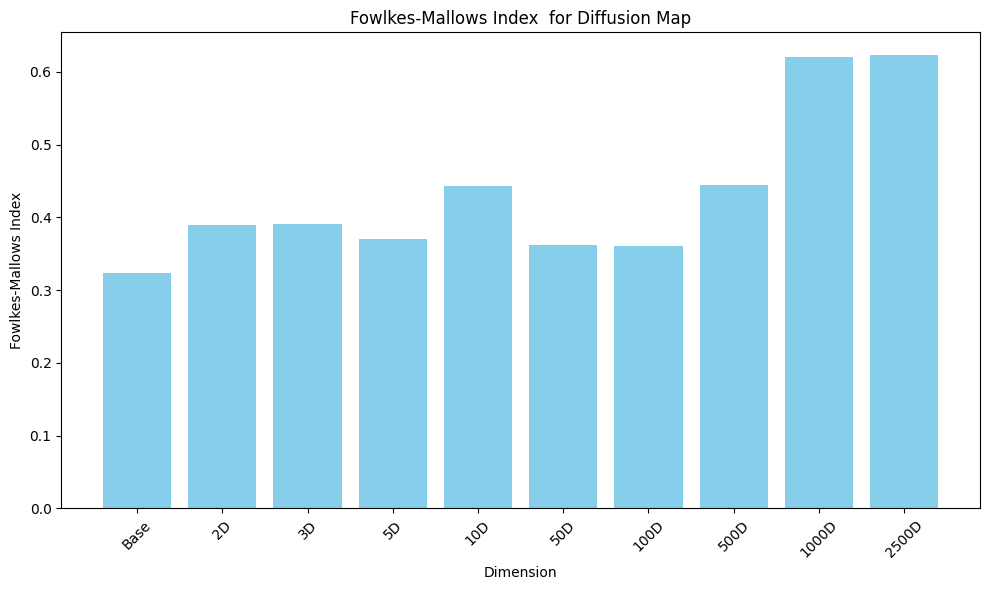

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1        2D               0.389779
2        3D               0.390151
3        5D               0.369969
4       10D               0.443535
5       50D               0.361381
6      100D               0.360618
7      500D               0.444210
8     1000D               0.620761
9     2500D               0.623092


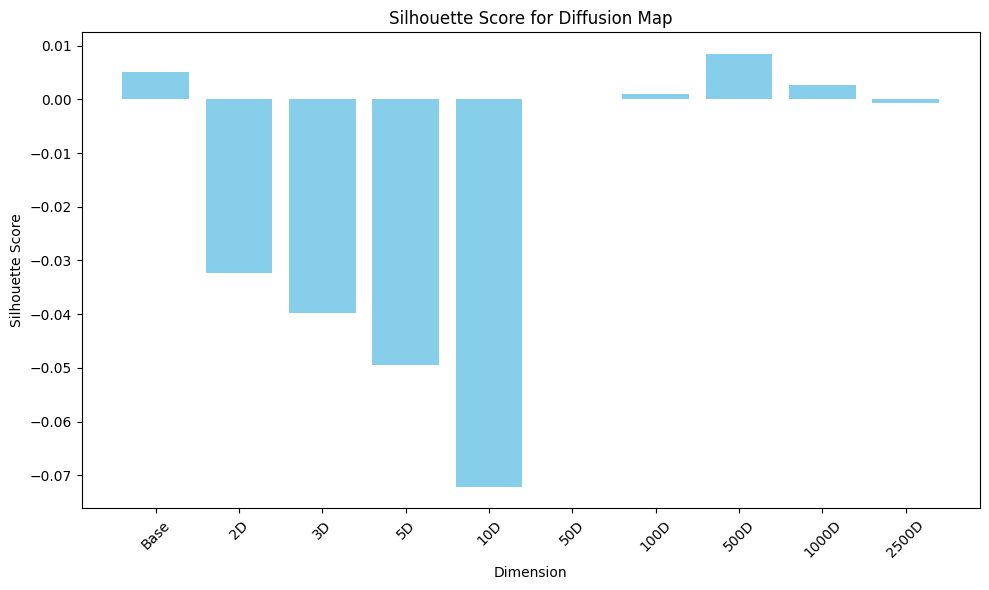

  Dimension  Silhouette Score
0      Base          0.005043
1        2D         -0.032359
2        3D         -0.039707
3        5D         -0.049404
4       10D         -0.072156
5       50D          0.000097
6      100D          0.001005
7      500D          0.008474
8     1000D          0.002757
9     2500D         -0.000725


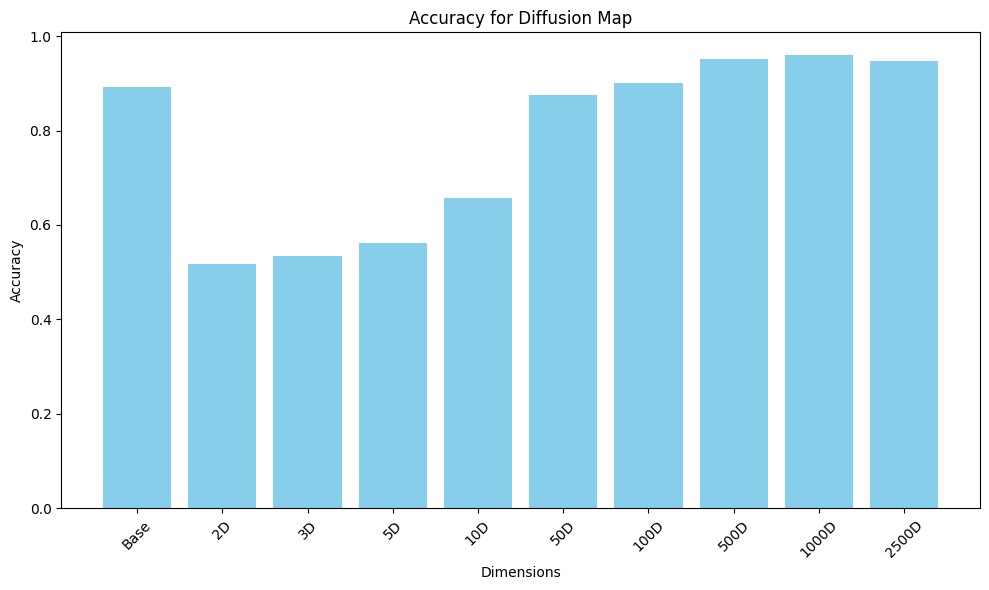

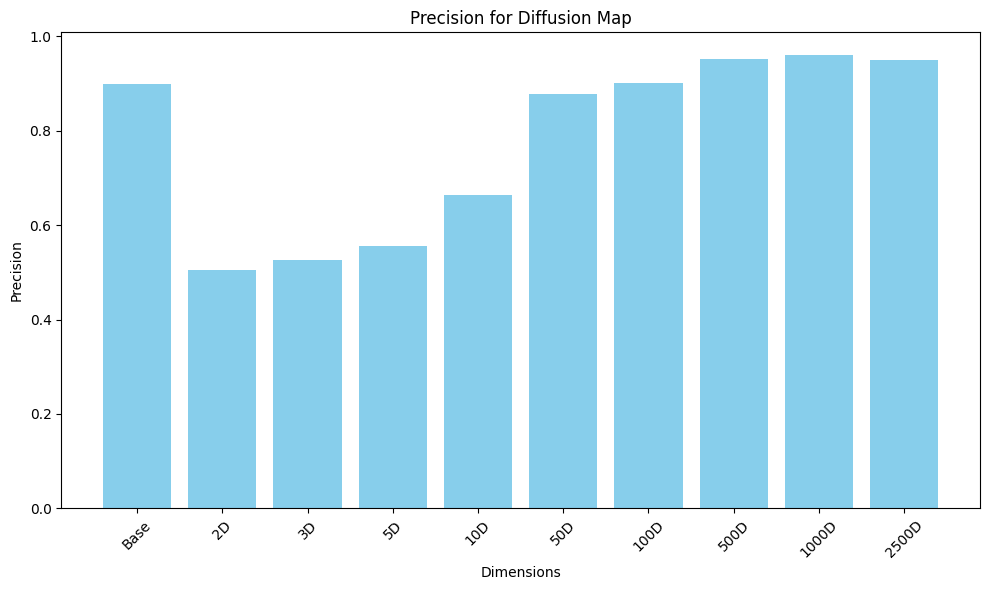

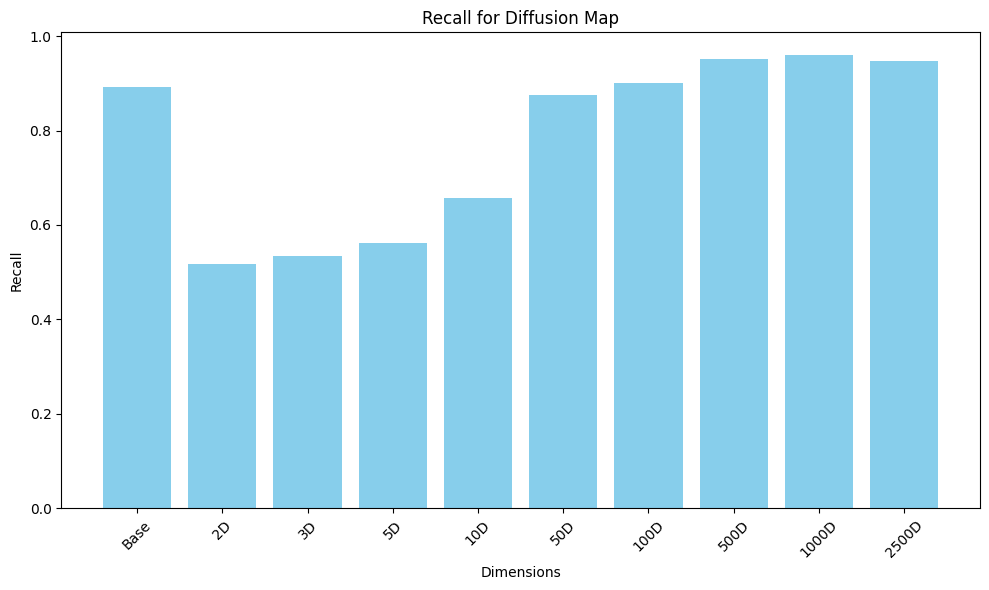

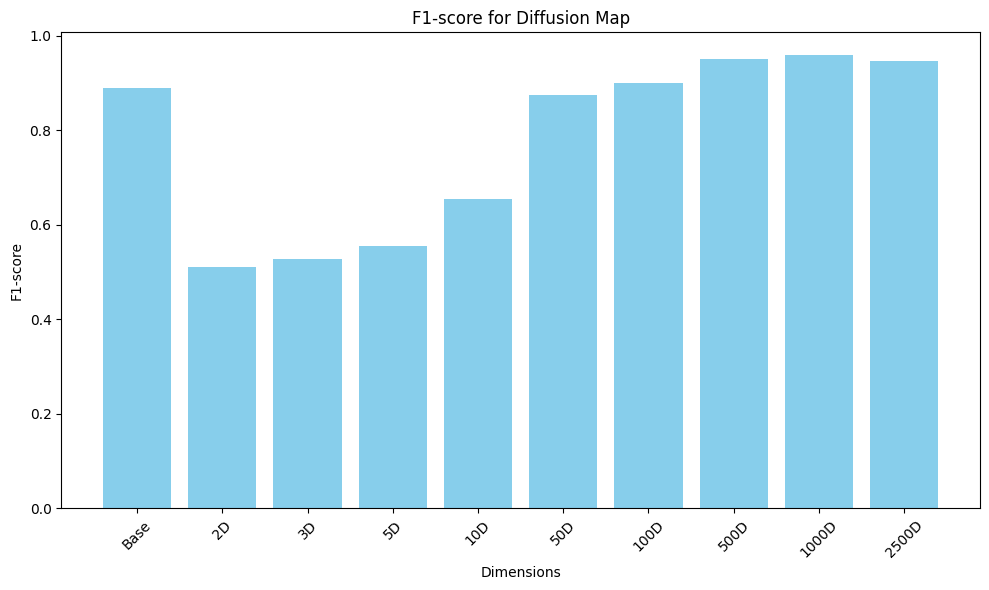

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.892708   0.898061  0.892708  0.889456
1         2D  0.516667   0.505610  0.516667  0.509935
2         3D  0.534375   0.526762  0.534375  0.527914
3         5D  0.560937   0.556105  0.560937  0.555058
4        10D  0.656771   0.663100  0.656771  0.655480
5        50D  0.876042   0.877024  0.876042  0.875888
6       100D  0.901042   0.902250  0.901042  0.900946
7       500D  0.950521   0.951462  0.950521  0.950306
8      1000D  0.959896   0.960509  0.959896  0.959679
9      2500D  0.947396   0.949536  0.947396  0.946672


In [ ]:
# Array with the dimensions we want to explore
dimensions = [2, 3, 5, 10, 50, 100, 500, 1000, 2500]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, diffusion_map_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for Diffusion Map')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for Diffusion Map')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for Diffusion Map')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for Diffusion Map')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for Diffusion Map')
plot_classification_results(df_results, 'Precision', 'Precision for Diffusion Map')
plot_classification_results(df_results, 'Recall', 'Recall for Diffusion Map')
plot_classification_results(df_results, 'F1-score', 'F1-score for Diffusion Map')
print(df_results)

Check dimensions in the vecinity of the best result

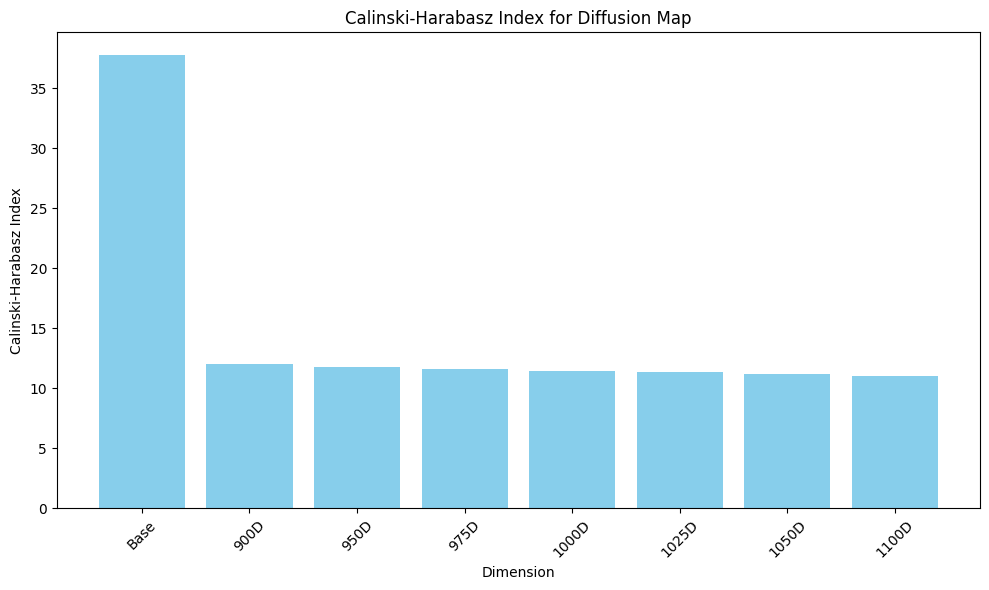

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1      900D                12.041760
2      950D                11.746918
3      975D                11.609596
4     1000D                11.476244
5     1025D                11.348500
6     1050D                11.223782
7     1100D                10.985274


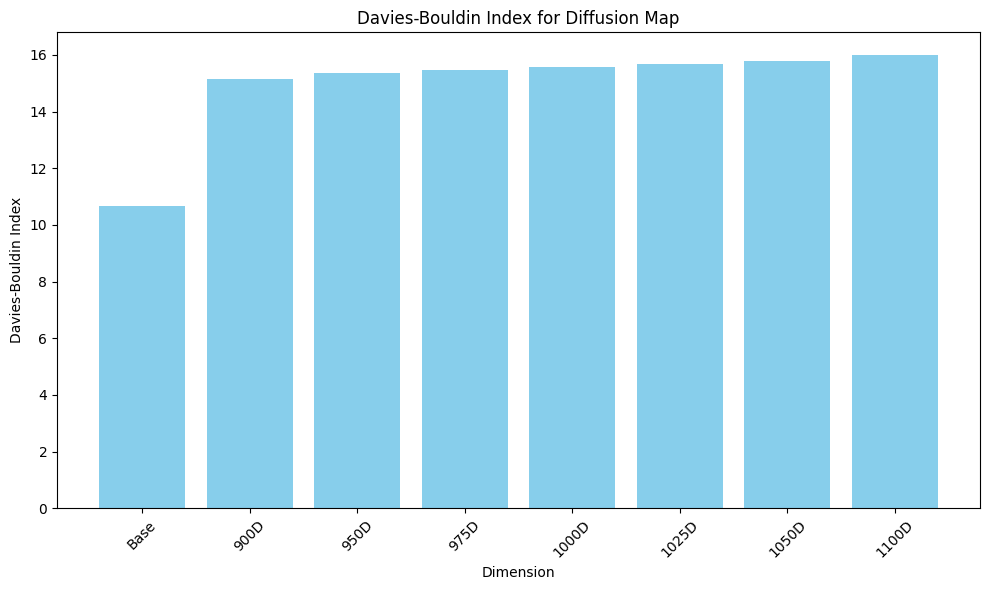

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1      900D             15.157578
2      950D             15.374839
3      975D             15.481250
4     1000D             15.587801
5     1025D             15.693156
6     1050D             15.794198
7     1100D             15.994498


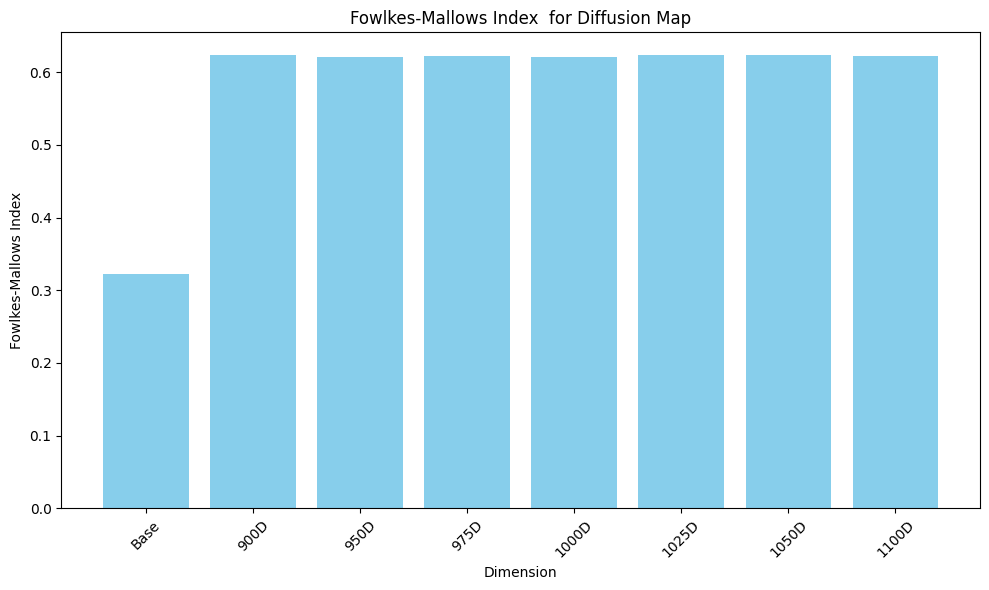

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1      900D               0.623543
2      950D               0.621348
3      975D               0.621860
4     1000D               0.620761
5     1025D               0.623655
6     1050D               0.623676
7     1100D               0.622904


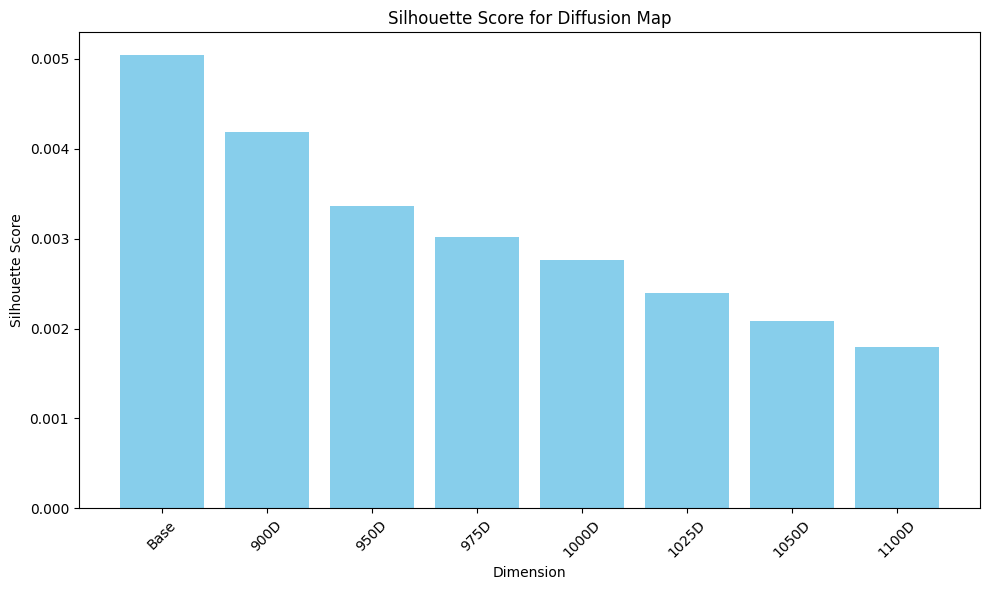

  Dimension  Silhouette Score
0      Base          0.005043
1      900D          0.004186
2      950D          0.003365
3      975D          0.003017
4     1000D          0.002757
5     1025D          0.002391
6     1050D          0.002086
7     1100D          0.001796


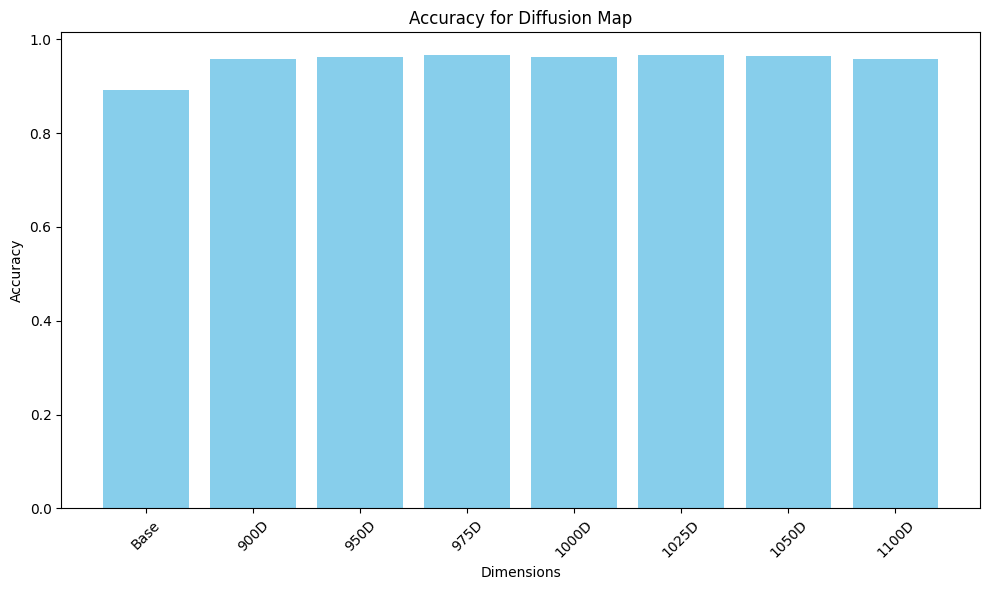

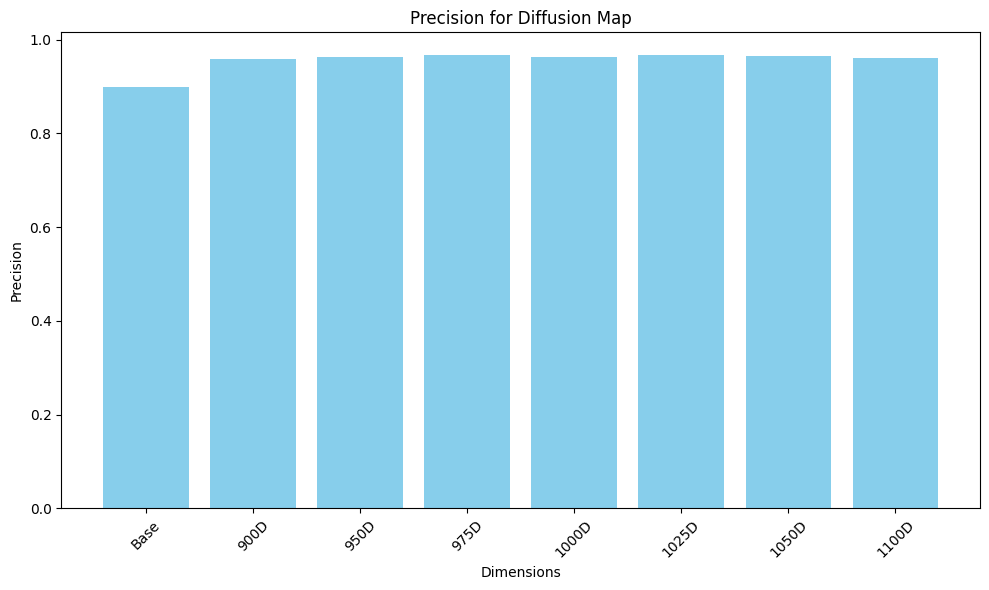

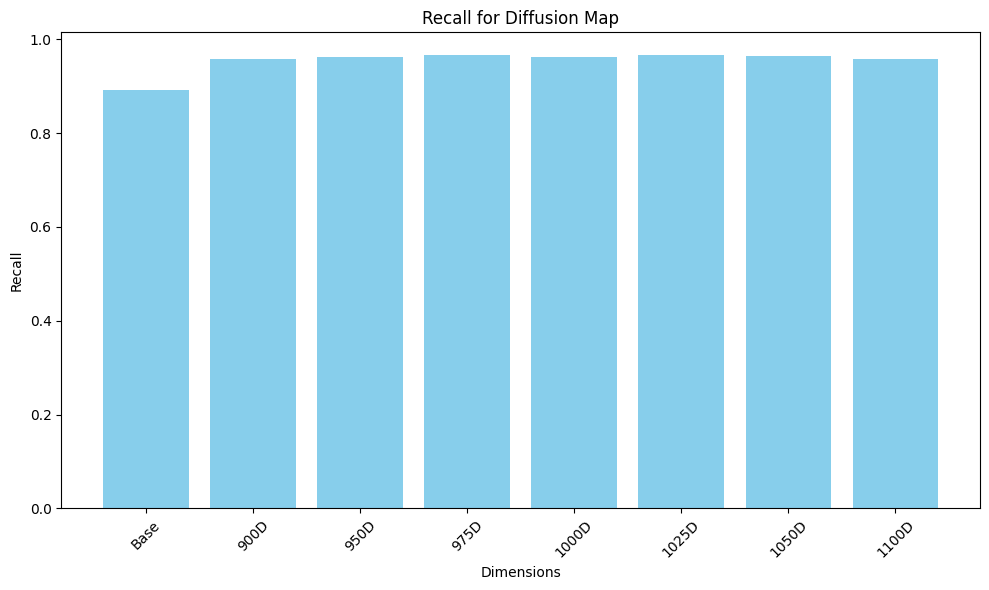

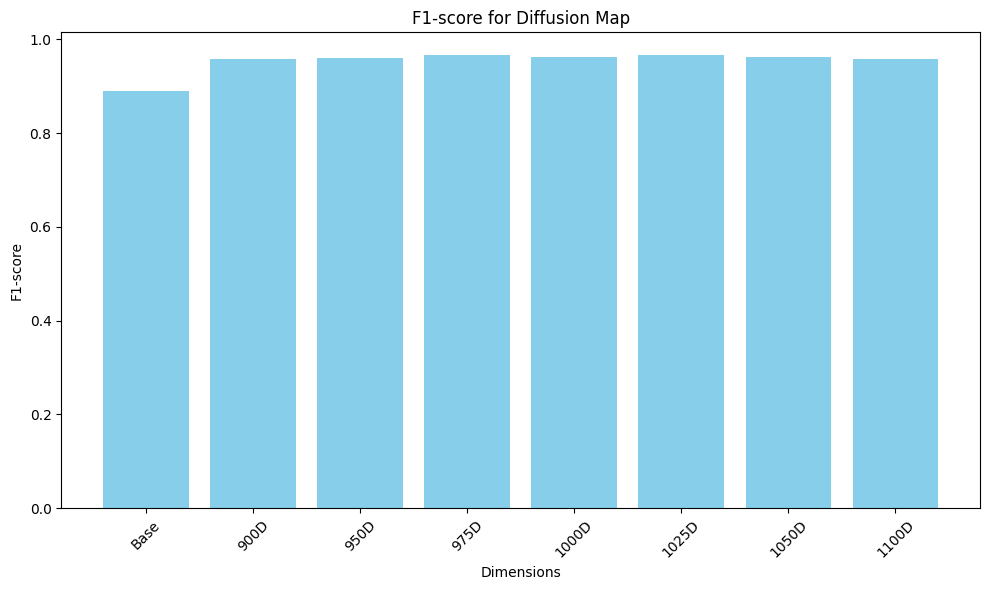

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.892708   0.898061  0.892708  0.889456
1       900D  0.957812   0.958598  0.957812  0.957526
2       950D  0.961458   0.962116  0.961458  0.961191
3       975D  0.966146   0.966699  0.966146  0.966012
4      1000D  0.961458   0.962199  0.961458  0.961220
5      1025D  0.966667   0.967131  0.966667  0.966531
6      1050D  0.963542   0.964309  0.963542  0.963312
7      1100D  0.958854   0.959678  0.958854  0.958582


In [ ]:
# Array with the dimensions we want to explore
dimensions = [900, 950, 975, 1000, 1025, 1050, 1100]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, diffusion_map_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for Diffusion Map')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for Diffusion Map')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for Diffusion Map')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for Diffusion Map')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for Diffusion Map')
plot_classification_results(df_results, 'Precision', 'Precision for Diffusion Map')
plot_classification_results(df_results, 'Recall', 'Recall for Diffusion Map')
plot_classification_results(df_results, 'F1-score', 'F1-score for Diffusion Map')
print(df_results)

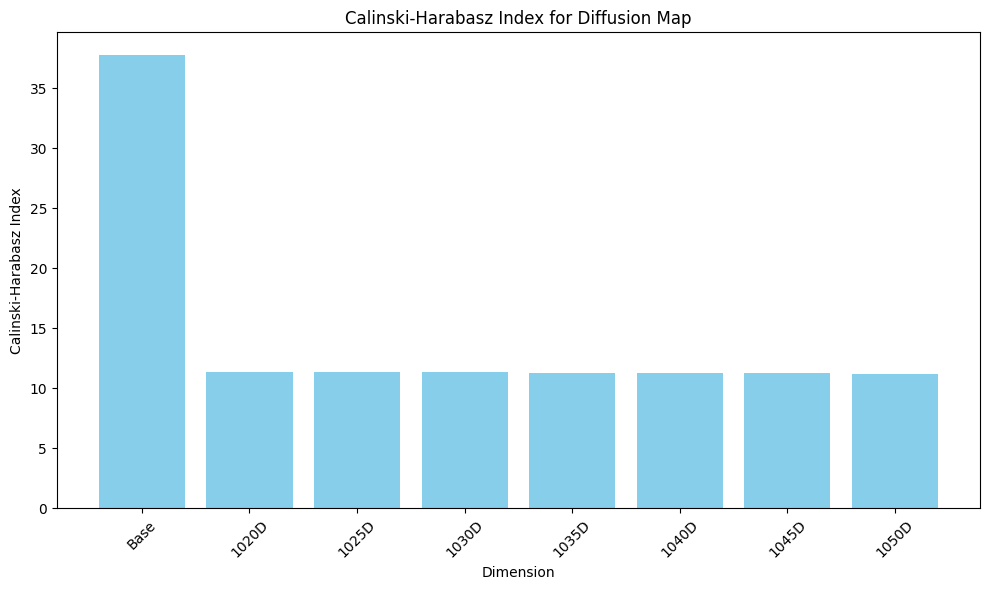

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1     1020D                11.373021
2     1025D                11.348500
3     1030D                11.322997
4     1035D                11.298344
5     1040D                11.273490
6     1045D                11.248566
7     1050D                11.223782


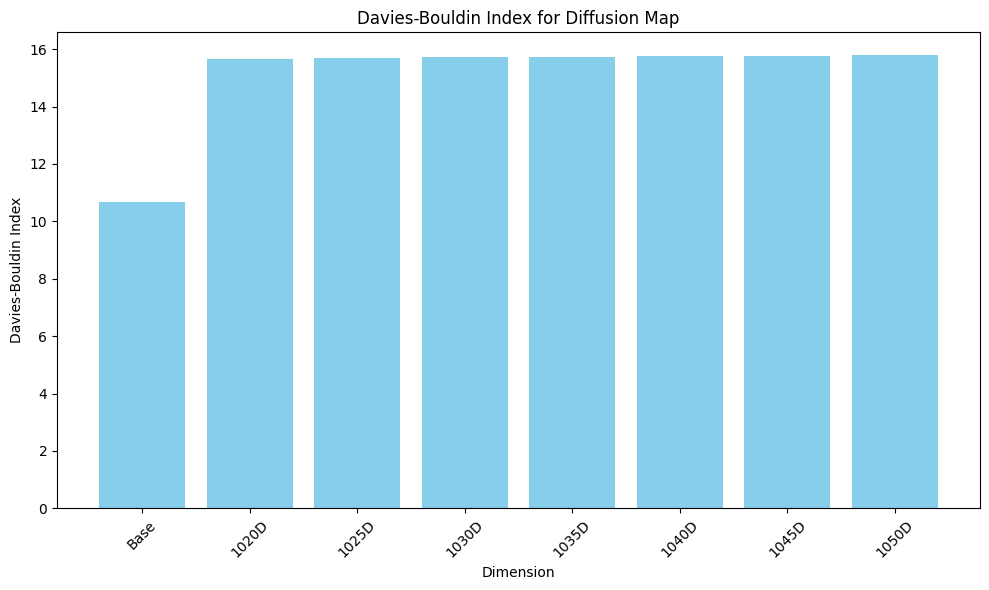

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1     1020D             15.671110
2     1025D             15.693156
3     1030D             15.713936
4     1035D             15.734240
5     1040D             15.753293
6     1045D             15.773325
7     1050D             15.794198


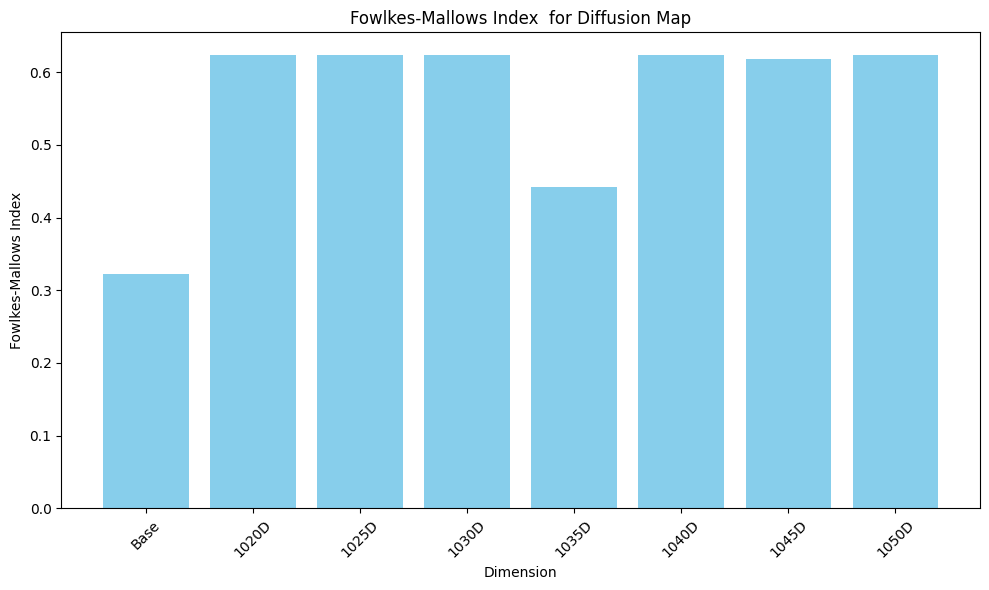

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1     1020D               0.623595
2     1025D               0.623655
3     1030D               0.623297
4     1035D               0.441741
5     1040D               0.623676
6     1045D               0.617890
7     1050D               0.623676


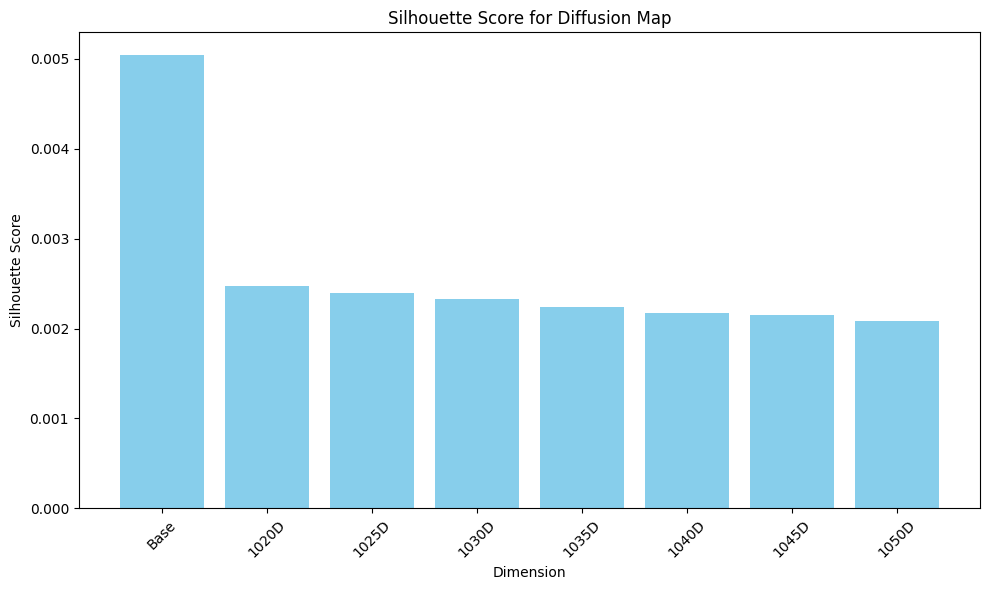

  Dimension  Silhouette Score
0      Base          0.005043
1     1020D          0.002469
2     1025D          0.002391
3     1030D          0.002326
4     1035D          0.002238
5     1040D          0.002178
6     1045D          0.002152
7     1050D          0.002086


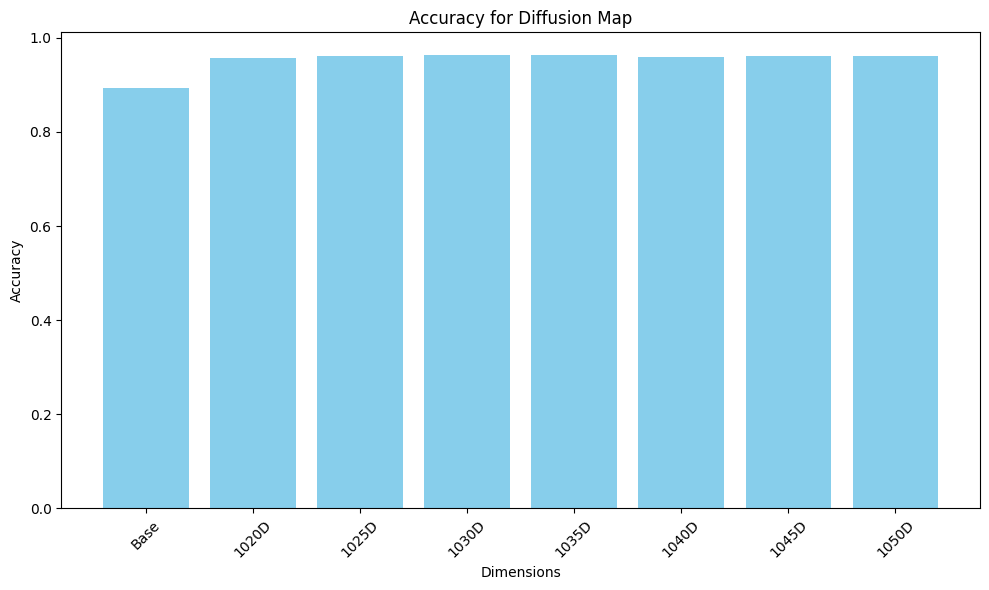

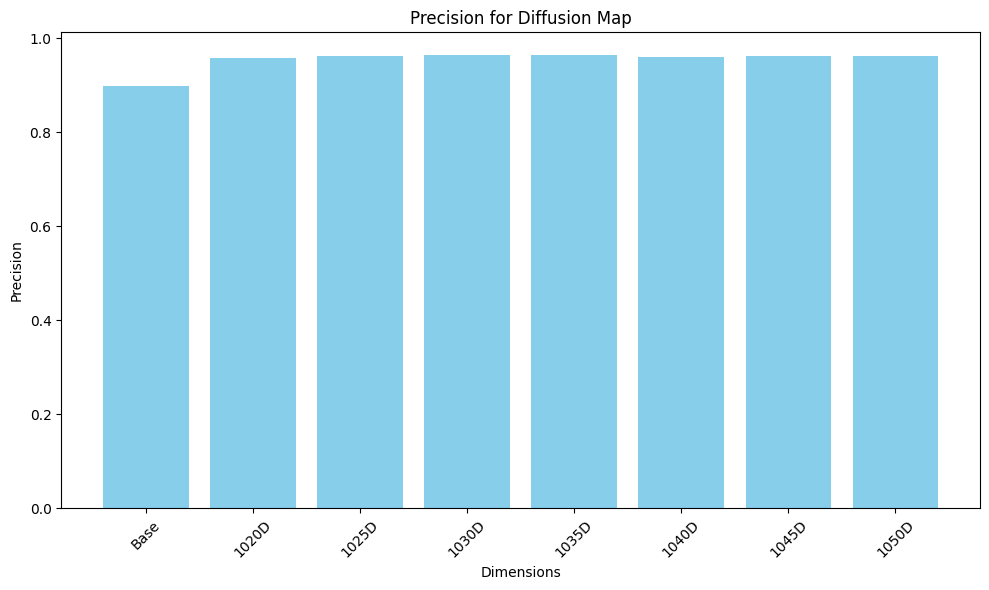

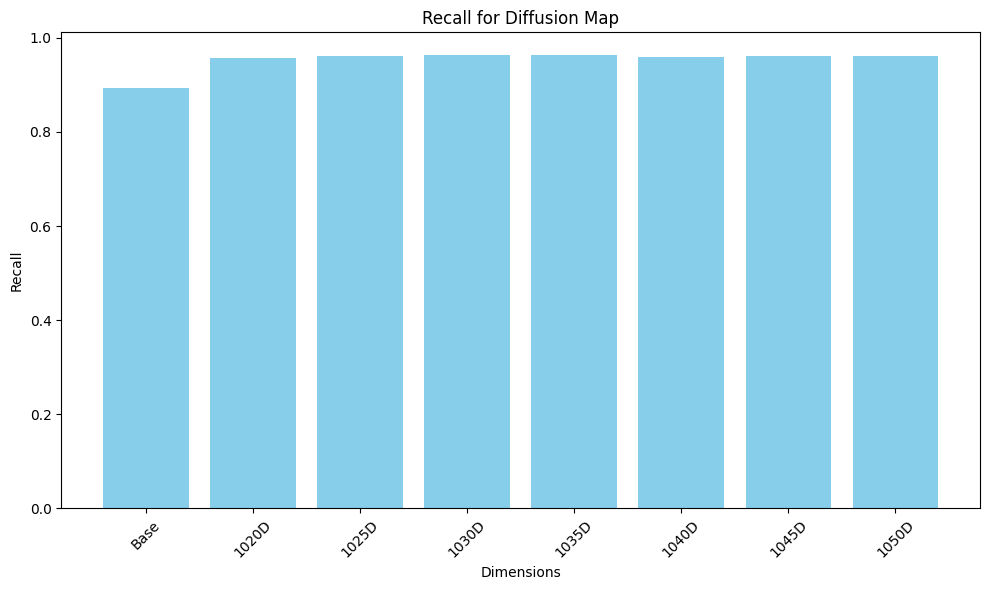

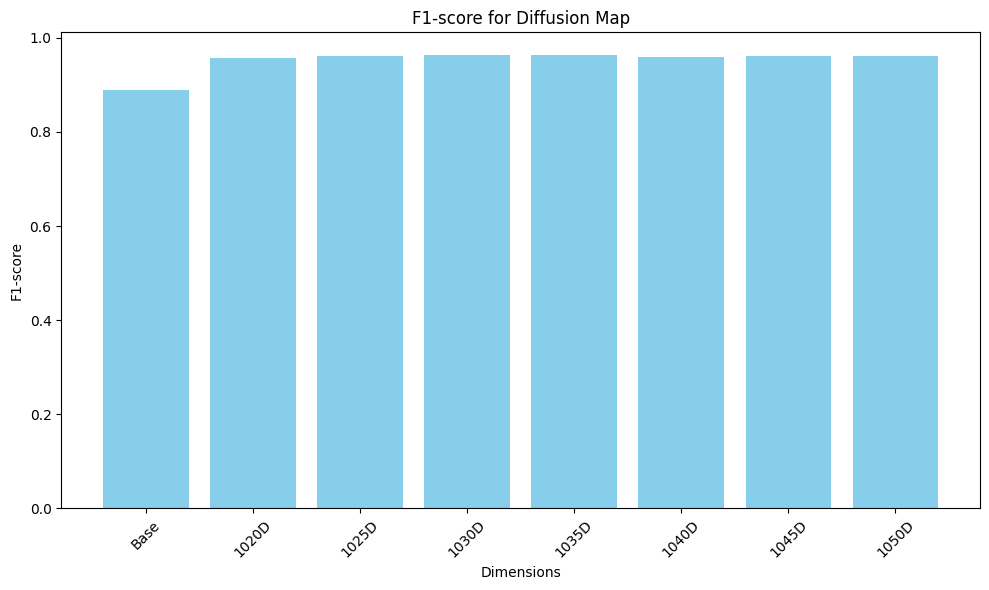

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.892708   0.898061  0.892708  0.889456
1      1020D  0.957812   0.958679  0.957812  0.957487
2      1025D  0.961458   0.962025  0.961458  0.961237
3      1030D  0.963021   0.963673  0.963021  0.962859
4      1035D  0.963542   0.964063  0.963542  0.963428
5      1040D  0.959896   0.960594  0.959896  0.959655
6      1045D  0.960938   0.961701  0.960938  0.960715
7      1050D  0.961979   0.962685  0.961979  0.961721


In [ ]:
# Array with the dimensions we want to explore
dimensions = [1020, 1025, 1030, 1035, 1040, 1045, 1050]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, diffusion_map_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for Diffusion Map')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for Diffusion Map')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for Diffusion Map')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for Diffusion Map')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for Diffusion Map')
plot_classification_results(df_results, 'Precision', 'Precision for Diffusion Map')
plot_classification_results(df_results, 'Recall', 'Recall for Diffusion Map')
plot_classification_results(df_results, 'F1-score', 'F1-score for Diffusion Map')
print(df_results)

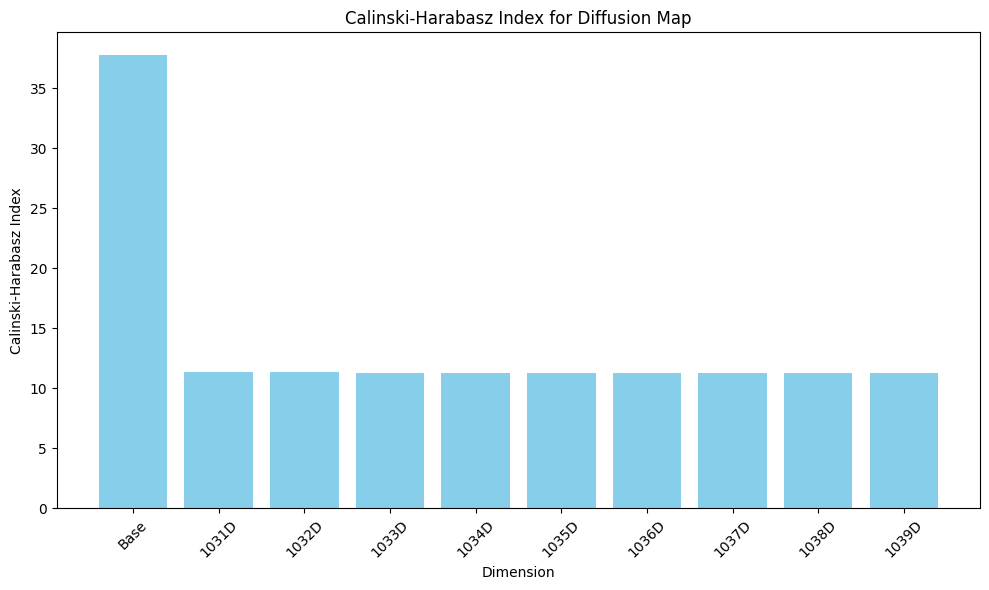

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1     1031D                11.318127
2     1032D                11.312977
3     1033D                11.307702
4     1034D                11.302437
5     1035D                11.298344
6     1036D                11.293811
7     1037D                11.288480
8     1038D                11.283409
9     1039D                11.278437


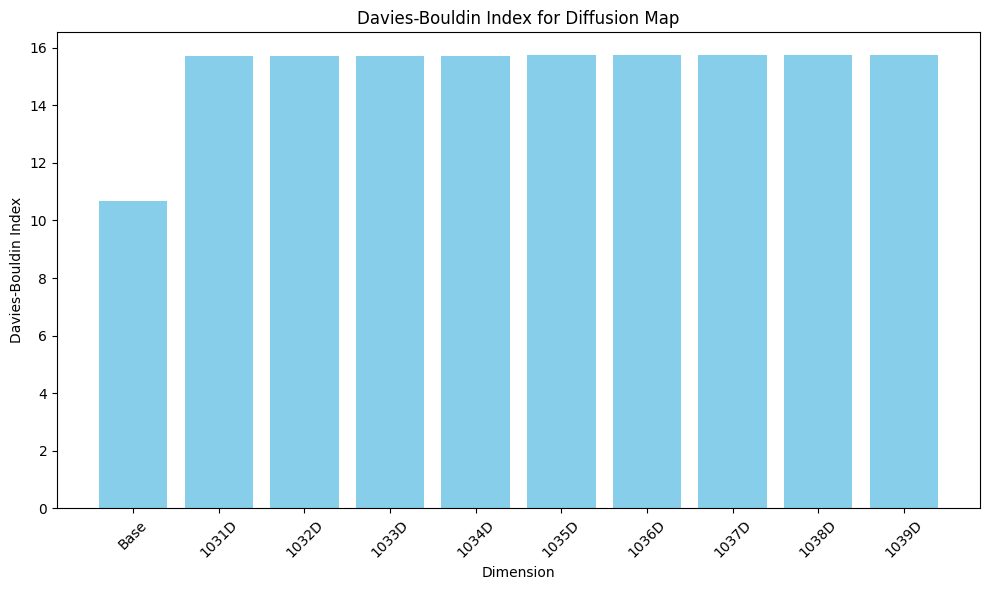

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1     1031D             15.717540
2     1032D             15.722002
3     1033D             15.726443
4     1034D             15.730574
5     1035D             15.734240
6     1036D             15.737519
7     1037D             15.741900
8     1038D             15.745677
9     1039D             15.749440


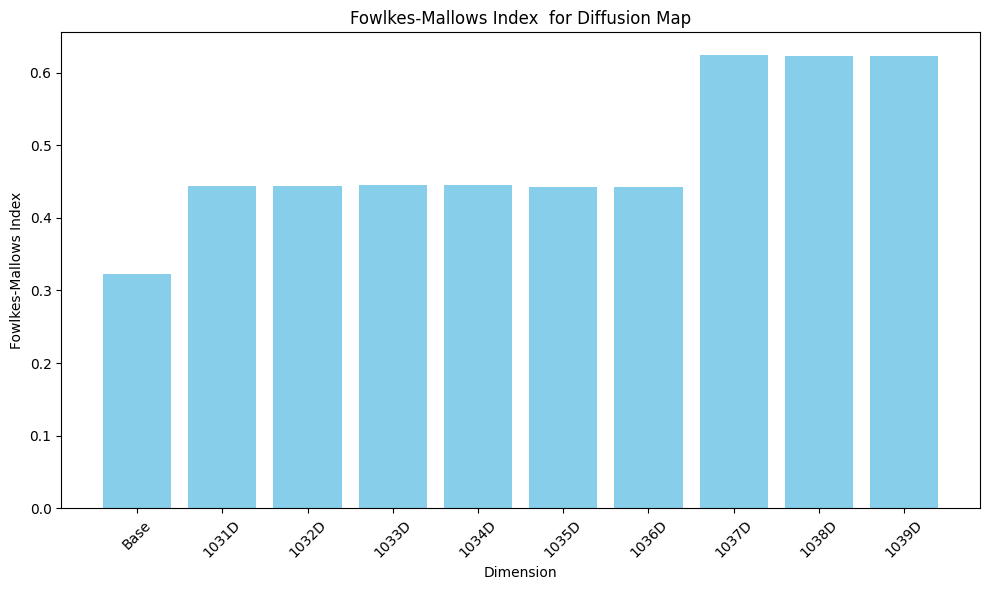

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1     1031D               0.444351
2     1032D               0.444351
3     1033D               0.445077
4     1034D               0.445077
5     1035D               0.441741
6     1036D               0.441741
7     1037D               0.624126
8     1038D               0.622848
9     1039D               0.622848


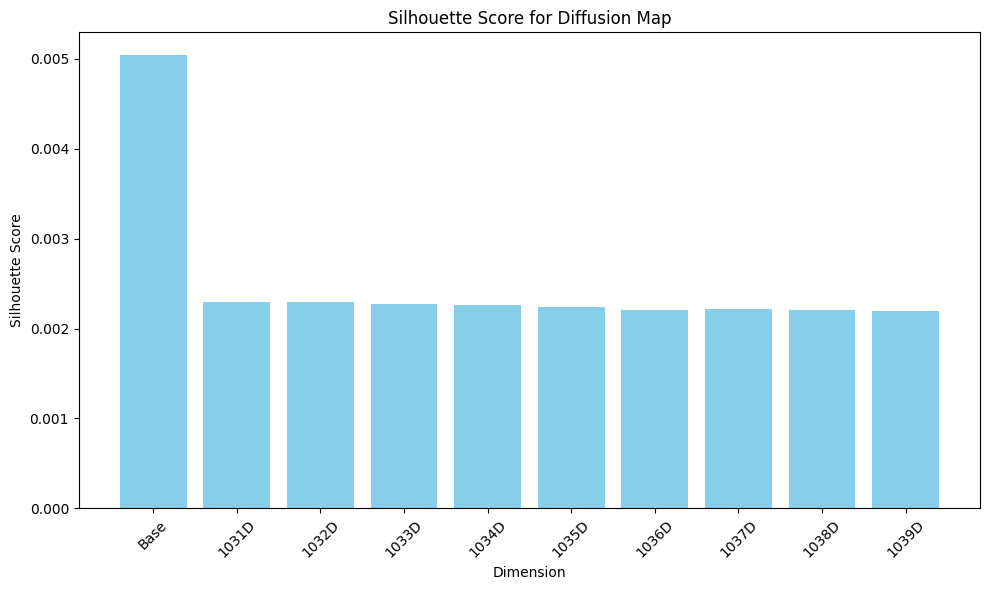

  Dimension  Silhouette Score
0      Base          0.005043
1     1031D          0.002297
2     1032D          0.002299
3     1033D          0.002274
4     1034D          0.002257
5     1035D          0.002238
6     1036D          0.002212
7     1037D          0.002217
8     1038D          0.002202
9     1039D          0.002190


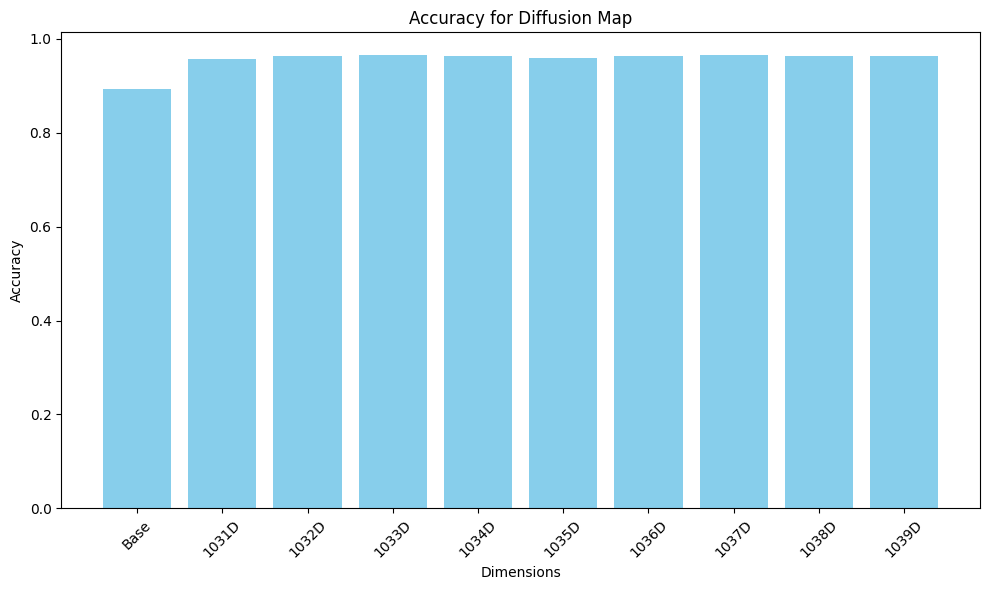

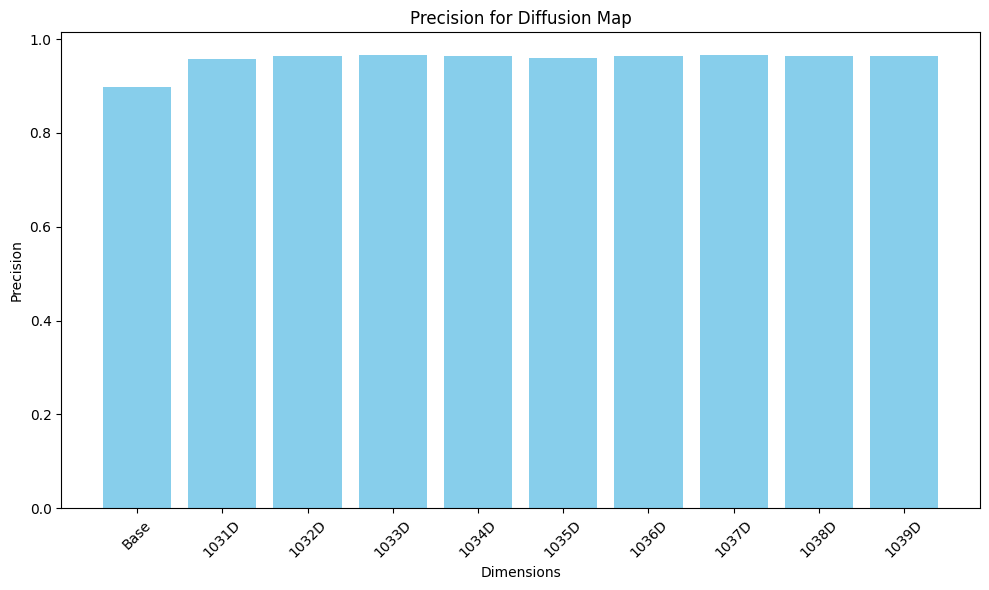

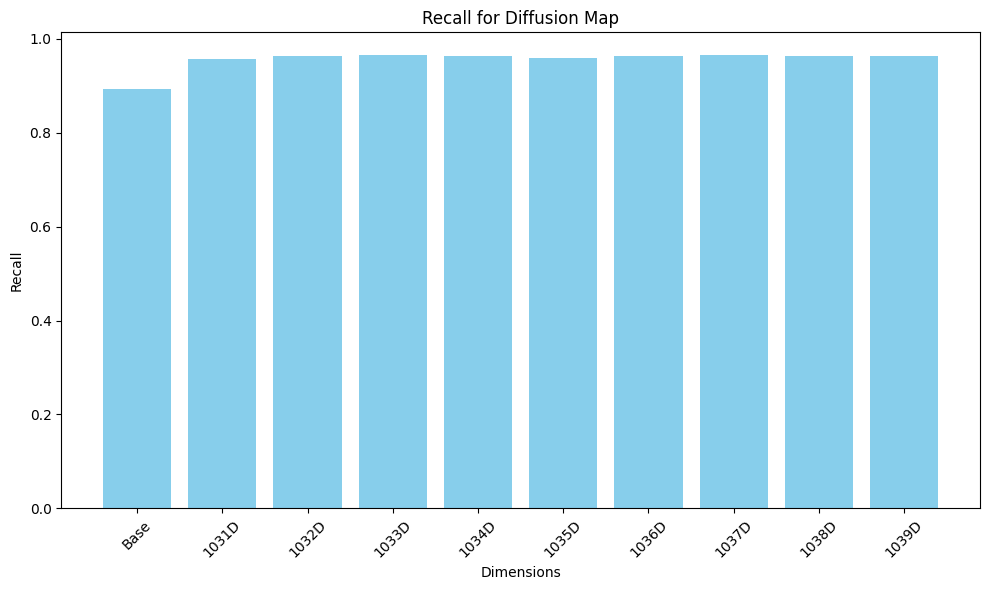

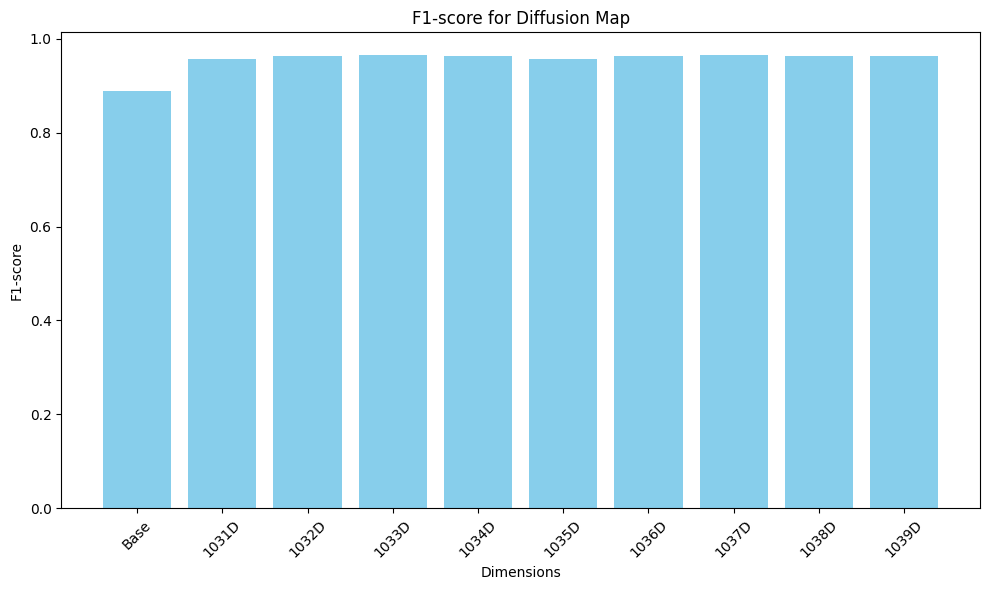

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.892708   0.898061  0.892708  0.889456
1      1031D  0.956771   0.957708  0.956771  0.956573
2      1032D  0.962500   0.963076  0.962500  0.962315
3      1033D  0.965625   0.966146  0.965625  0.965493
4      1034D  0.963021   0.963733  0.963021  0.962834
5      1035D  0.958333   0.959112  0.958333  0.958018
6      1036D  0.964063   0.964621  0.964063  0.963892
7      1037D  0.965625   0.966252  0.965625  0.965450
8      1038D  0.963542   0.964321  0.963542  0.963341
9      1039D  0.962500   0.963055  0.962500  0.962338


In [ ]:
# Array with the dimensions we want to explore
dimensions = [1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, diffusion_map_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for Diffusion Map')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for Diffusion Map')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for Diffusion Map')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for Diffusion Map')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for Diffusion Map')
plot_classification_results(df_results, 'Precision', 'Precision for Diffusion Map')
plot_classification_results(df_results, 'Recall', 'Recall for Diffusion Map')
plot_classification_results(df_results, 'F1-score', 'F1-score for Diffusion Map')
print(df_results)

# Diffusion Map Parameter Tuning

In [ ]:
params = ['default', 'epsilon = bgh_generous']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize Diffusion Map default epsilon = bgh
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Initialize Diffusion Map epsilon = bgh_generous
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, epsilon = 'bgh_generous')

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

                Parameter  Accuracy  Precision    Recall  F1-score
0                    Base  0.892708   0.898061  0.892708  0.889456
1                 default  0.961979   0.962805  0.961979  0.961791
2  epsilon = bgh_generous  0.871875   0.884903  0.871875  0.867250


In [ ]:
params = ['neighbor_params = {algorithm: ball_tree}', 'neighbor_params = {algorithm: kd_tree}', 'neighbor_params = {algorithm: brute}']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize Diffusion Map neighbor_params = {algorithm: ball_tree}
neighbor_params = {'algorithm': 'ball_tree'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Initialize Diffusion Map neighbor_params = {algorithm: kd_tree}
neighbor_params = {'algorithm': 'kd_tree'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Initialize Diffusion Map neighbor_params = {algorithm: brute}
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

                                  Parameter  Accuracy  Precision    Recall  \
0                                      Base  0.892708   0.898061  0.892708   
1  neighbor_params = {algorithm: ball_tree}  0.963021   0.963580  0.963021   
2    neighbor_params = {algorithm: kd_tree}  0.959375   0.960236  0.959375   
3      neighbor_params = {algorithm: brute}  0.964063   0.964899  0.964063   

   F1-score  
0  0.889456  
1  0.962864  
2  0.959061  
3  0.963900  


In [ ]:
params = ['default', 'alpha = 0.25', 'alpha = 0.75']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize Diffusion Map default alpha = 0.5
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Initialize Diffusion Map alpha = 0.25
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params, alpha = 0.25)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Initialize Diffusion Map alpha = 0.75
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params, alpha = 0.75)

# Fit Diffusion Map to the preprocessed data
X_diffmap = diffmap.fit_transform(X)

# Append to array
X_reduced.append(X_diffmap)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

      Parameter  Accuracy  Precision    Recall  F1-score
0          Base  0.892708   0.898061  0.892708  0.889456
1       default  0.961979   0.962805  0.961979  0.961791
2  alpha = 0.25  0.964063   0.964769  0.964063  0.963919
3  alpha = 0.75  0.960417   0.961251  0.960417  0.960153


# Best Diffusion Map Results

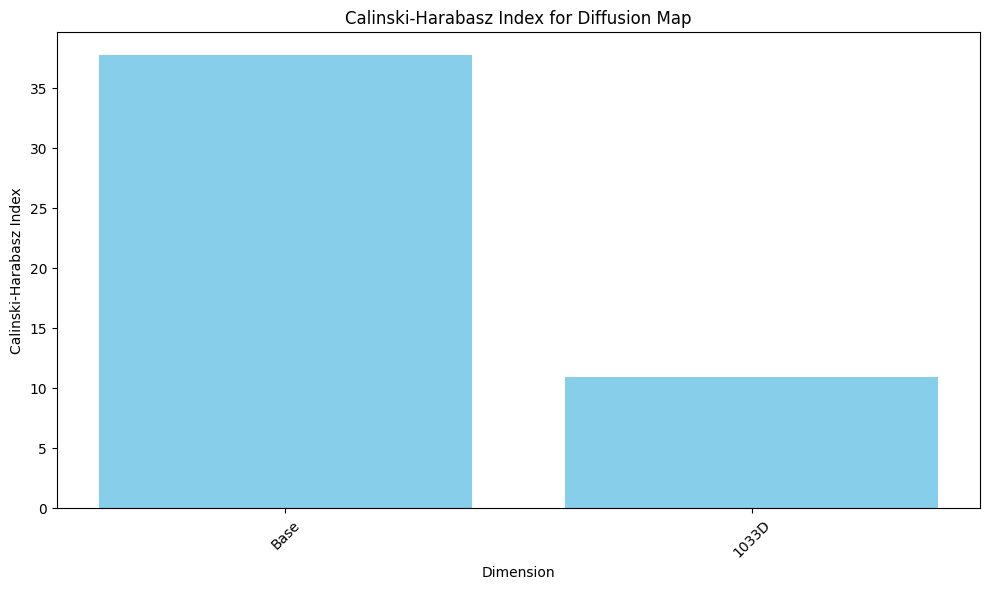

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1     1033D                10.941464


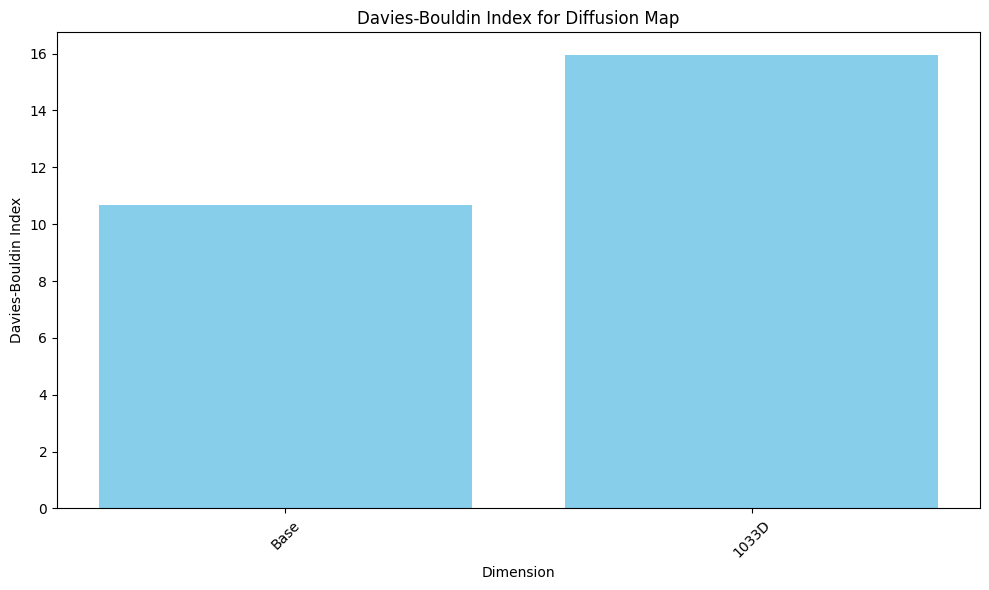

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1     1033D             15.951917


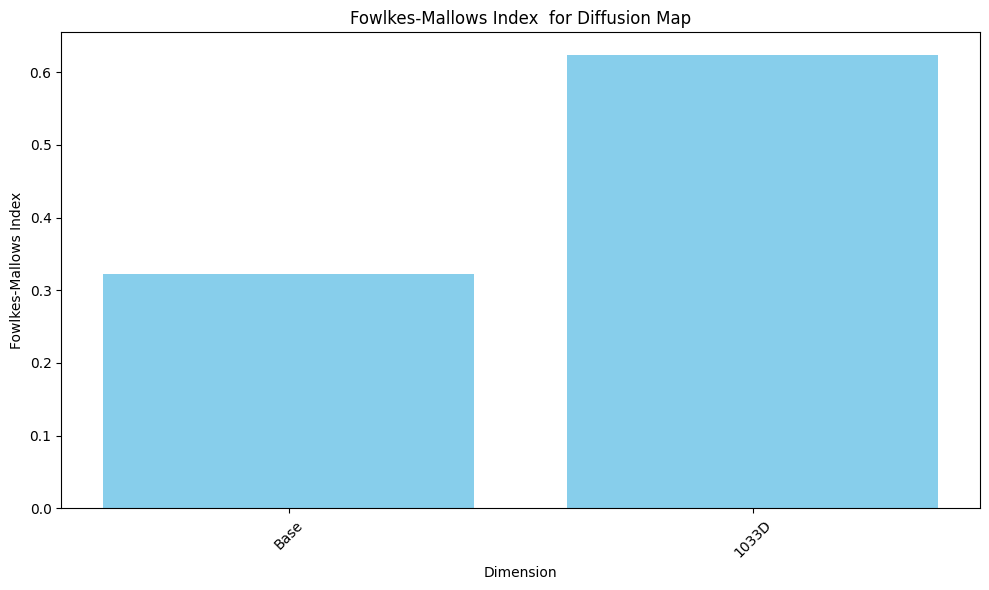

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1     1033D               0.623629


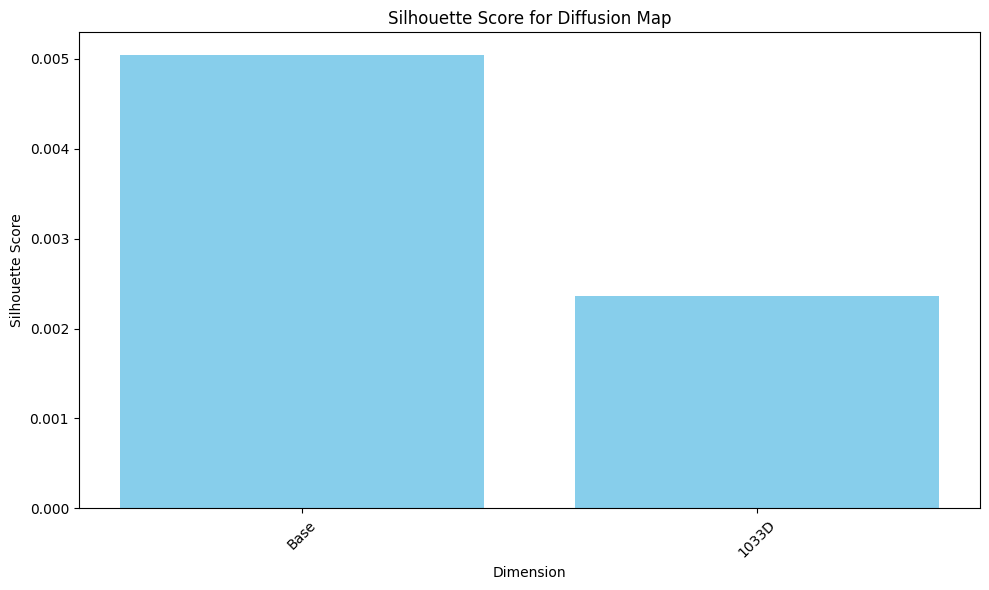

  Dimension  Silhouette Score
0      Base          0.005043
1     1033D          0.002366


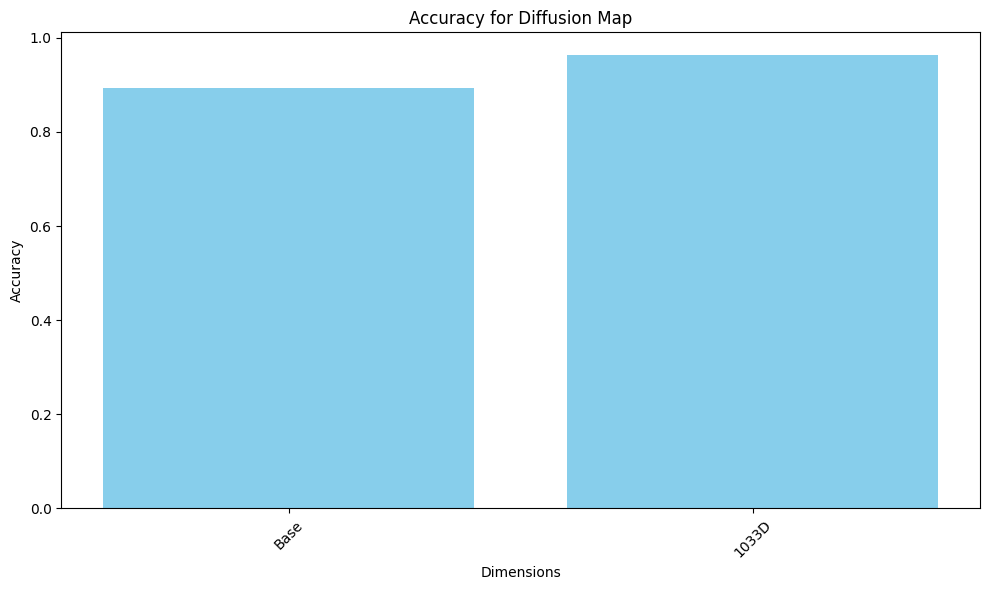

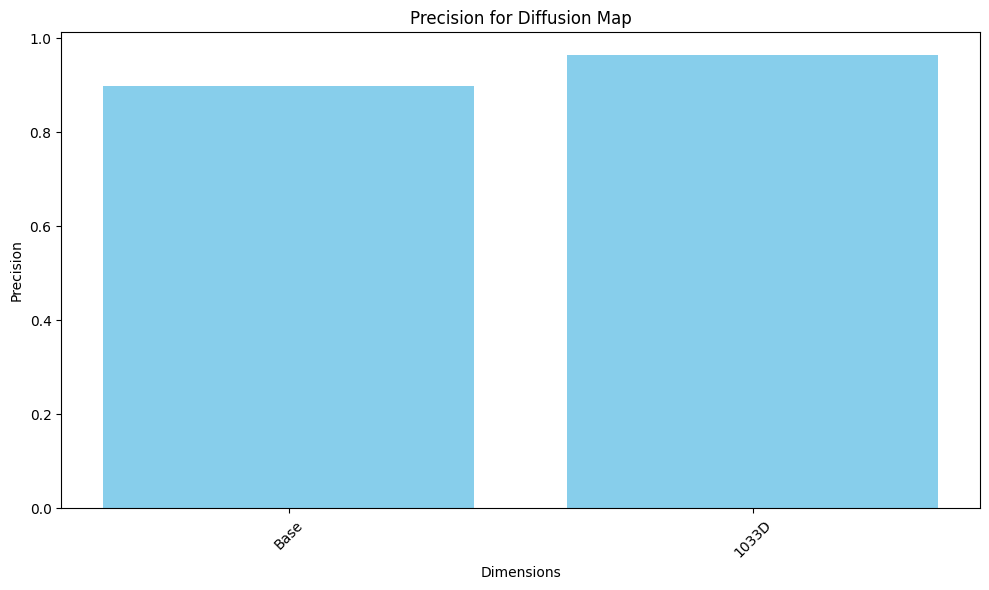

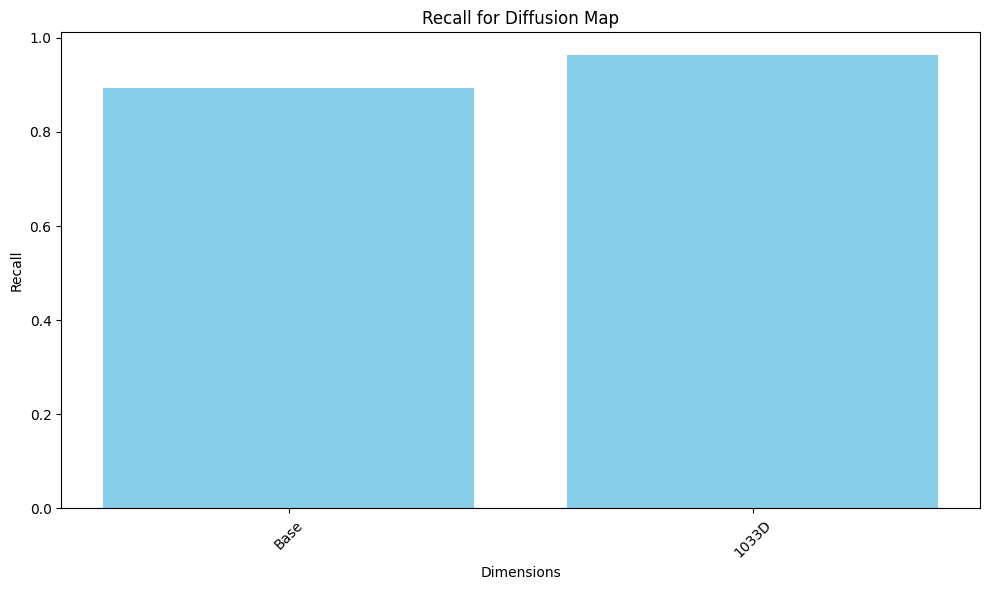

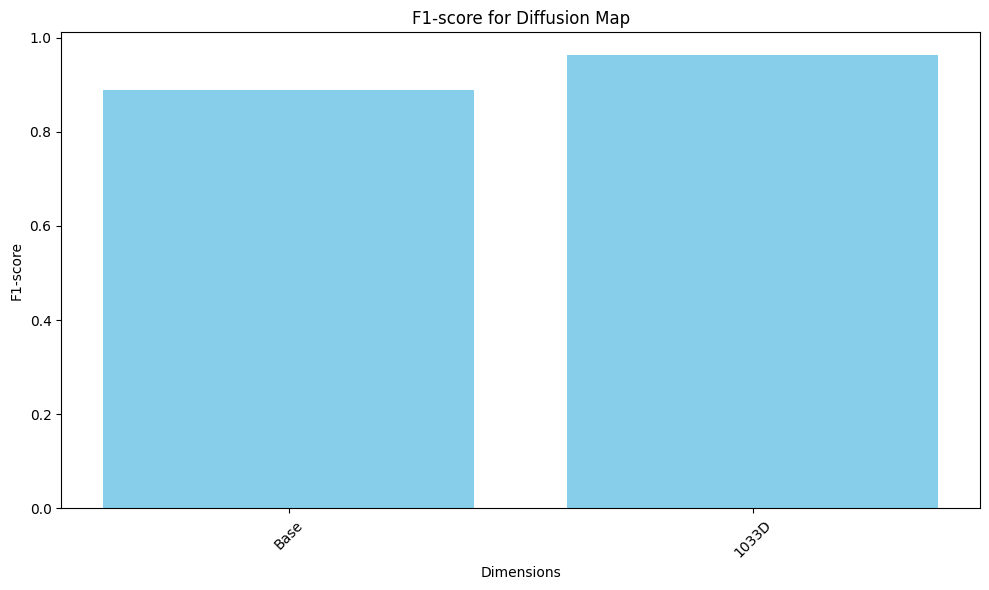

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.892708   0.898061  0.892708  0.889456
1      1033D  0.963542   0.964237  0.963542  0.963328


In [ ]:
# Initialize Diffusion Map
neighbor_params = {'algorithm': 'brute'}
diffmap = diffusion_map.DiffusionMap.from_sklearn(n_evecs = 1033, neighbor_params = neighbor_params, alpha = 0.25)

# Fit Diffusion Map to the preprocessed data
X_reduced = diffmap.fit_transform(X)

# Compute the popular metrics
# Initialize lists to store the results
results_ch = []
results_db = []
results_fm = []
results_sil = []

# Compute metrics for the base case
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X, y)
db_score = davies_bouldin_score(X, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X, y)

results_ch.append(['Base', ch_score])
results_db.append(['Base', db_score])
results_fm.append(['Base', fm_score])
results_sil.append(['Base', sil_score])

name = "1033D"
kmeans = KMeans(n_clusters=len(set(y)), random_state=42).fit(X_reduced)
y_pred = kmeans.labels_

ch_score = calinski_harabasz_score(X_reduced, y)
db_score = davies_bouldin_score(X_reduced, y)
fm_score = fowlkes_mallows_score(y, y_pred)
sil_score = silhouette_score(X_reduced, y)

results_ch.append([name, ch_score])
results_db.append([name, db_score])
results_fm.append([name, fm_score])
results_sil.append([name, sil_score])

# Convert results to DataFrames
df_ch = pd.DataFrame(results_ch, columns=['Dimension', 'Calinski-Harabasz Index'])
df_db = pd.DataFrame(results_db, columns=['Dimension', 'Davies-Bouldin Index'])
df_fm = pd.DataFrame(results_fm, columns=['Dimension', 'Fowlkes-Mallows Index'])
df_sil = pd.DataFrame(results_sil, columns=['Dimension', 'Silhouette Score'])

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for Diffusion Map')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for Diffusion Map')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for Diffusion Map')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for Diffusion Map')
print(df_sil)

# Initialize a list to store the results
classification_results = []

result = evaluate_classification(X, y, 'Base')
classification_results.append(result)

# Evaluate the classification performance on Isomap
name = "1033D"
result = evaluate_classification(X_reduced, y, name)
classification_results.append(result)

df_results = pd.DataFrame(classification_results)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for Diffusion Map')
plot_classification_results(df_results, 'Precision', 'Precision for Diffusion Map')
plot_classification_results(df_results, 'Recall', 'Recall for Diffusion Map')
plot_classification_results(df_results, 'F1-score', 'F1-score for Diffusion Map')
print(df_results)

# t-SNE Results

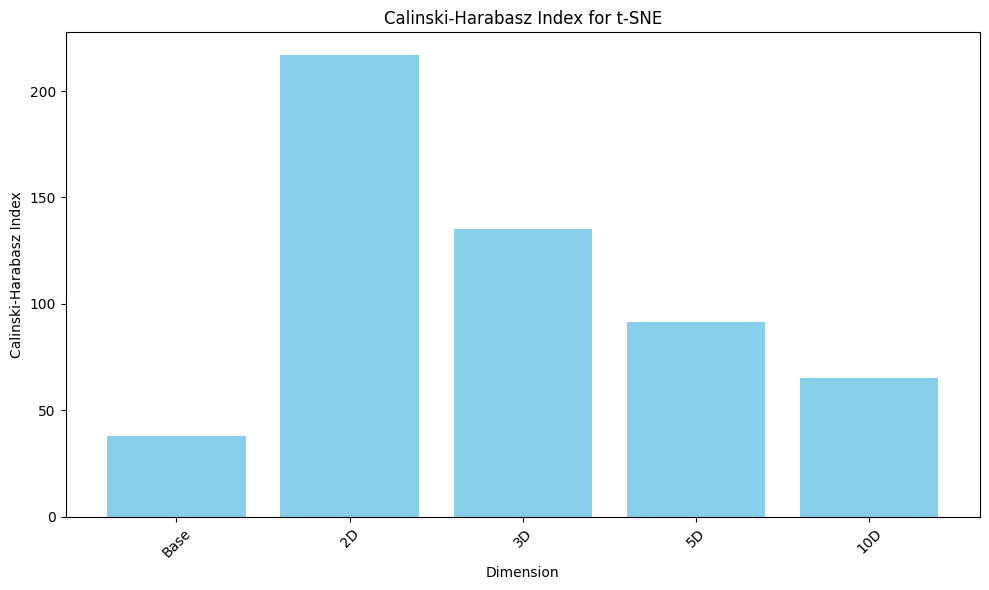

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1        2D               216.729846
2        3D               135.196647
3        5D                91.333166
4       10D                65.305798


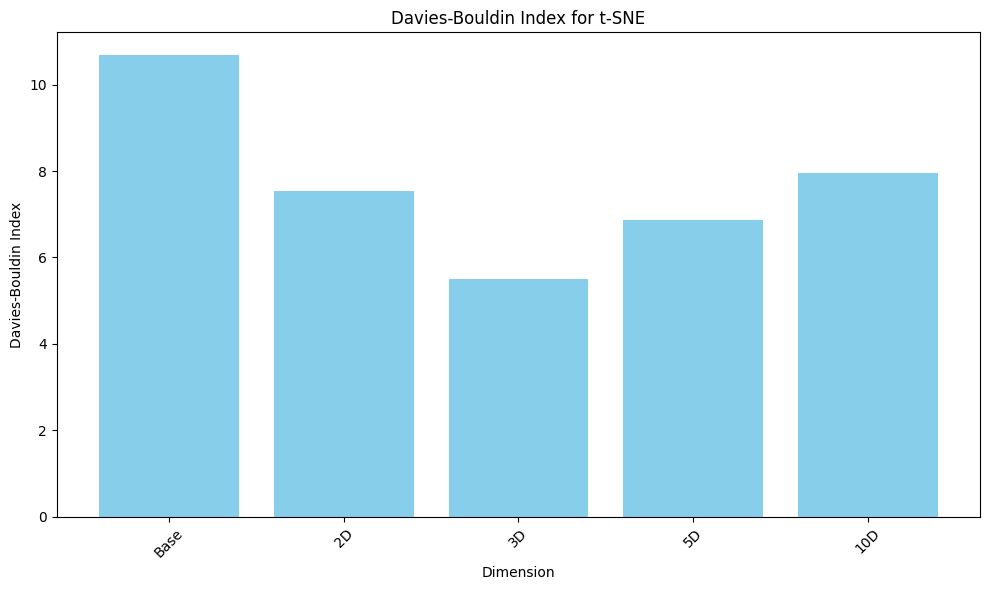

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1        2D              7.541361
2        3D              5.501459
3        5D              6.858822
4       10D              7.962362


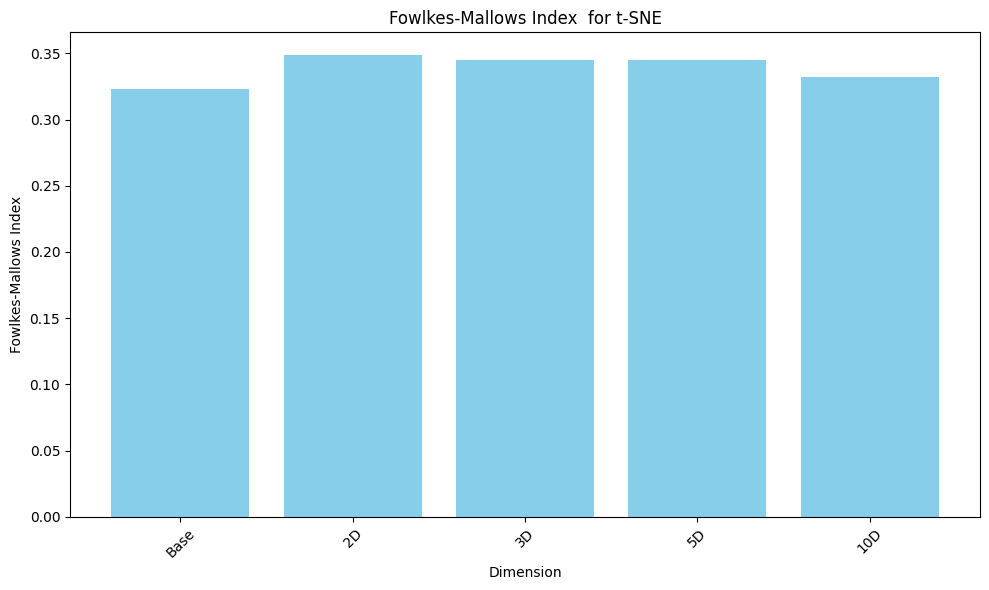

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1        2D               0.348406
2        3D               0.345297
3        5D               0.345028
4       10D               0.332299


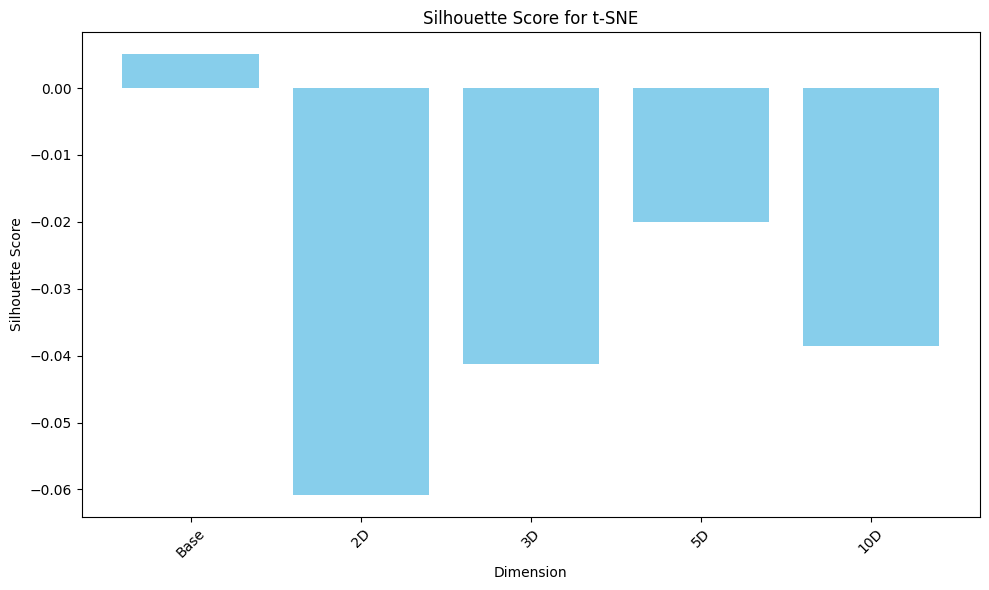

  Dimension  Silhouette Score
0      Base          0.005043
1        2D         -0.060812
2        3D         -0.041318
3        5D         -0.019987
4       10D         -0.038548


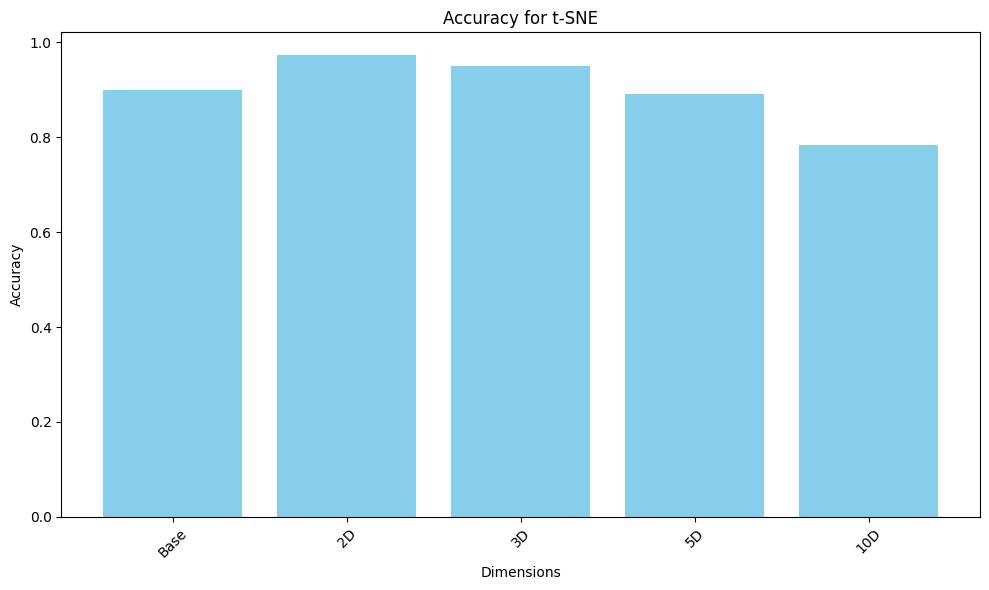

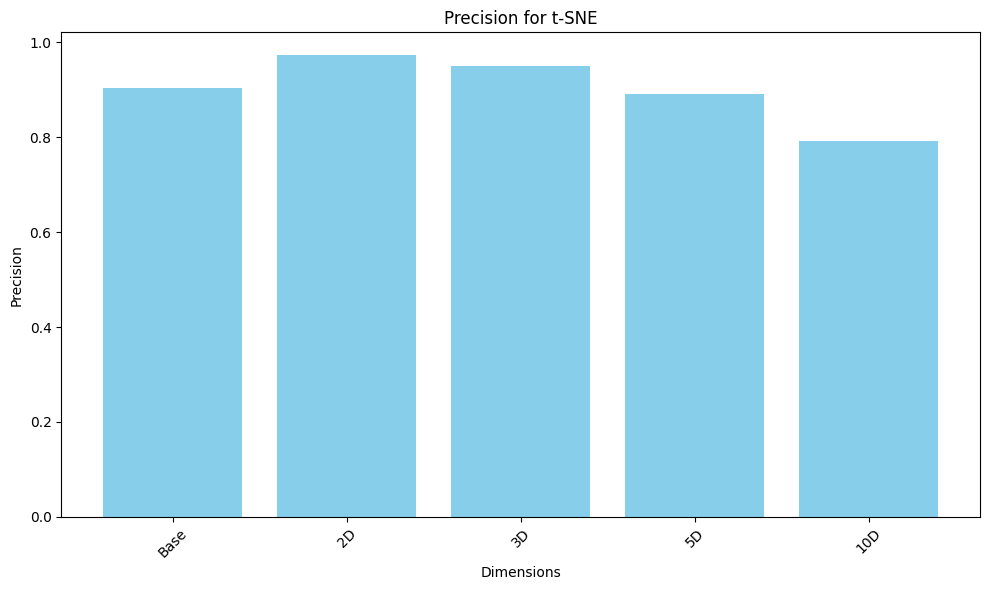

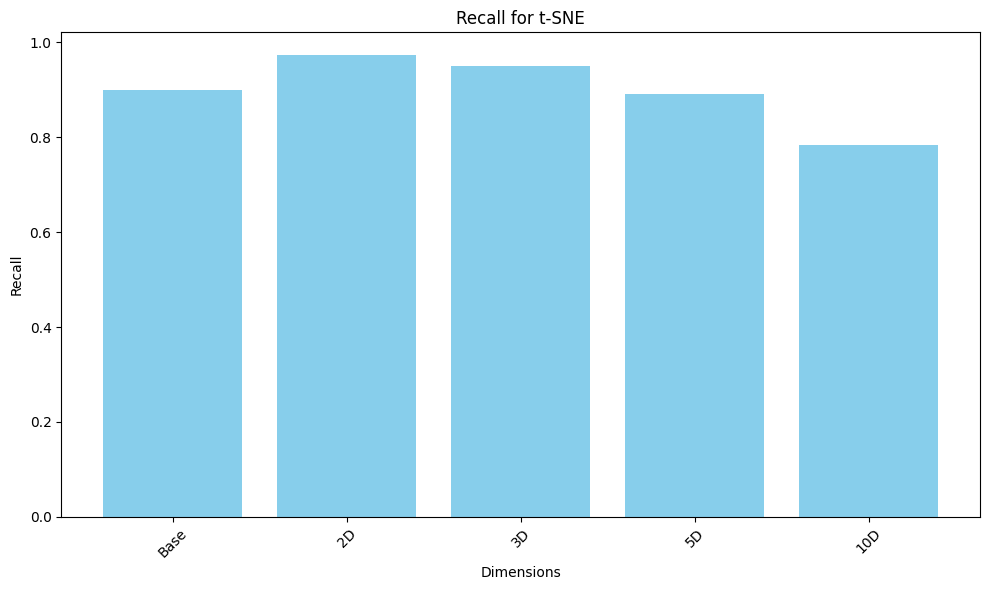

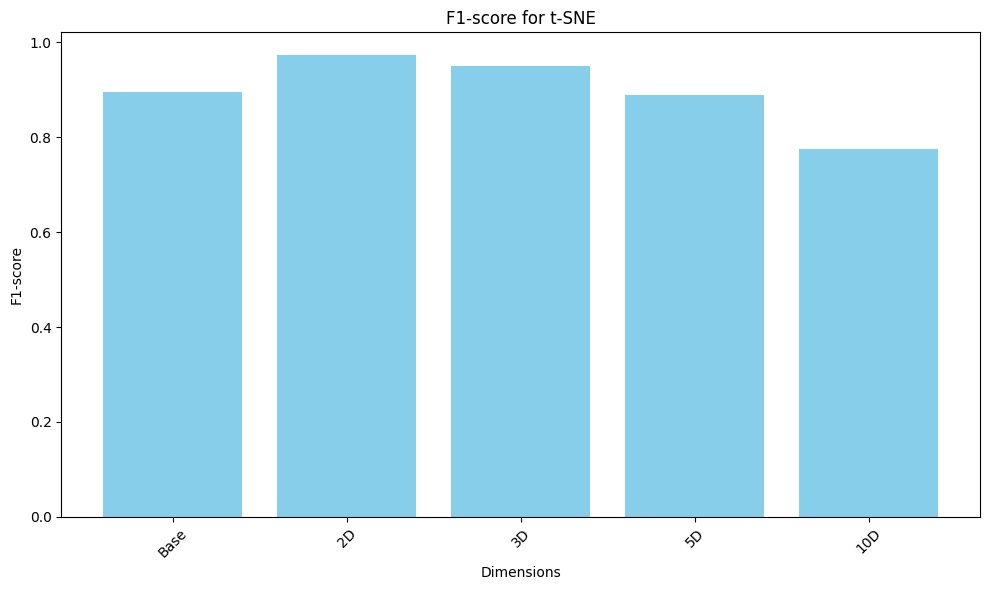

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1         2D  0.972396   0.972472  0.972396  0.972333
2         3D  0.950000   0.950316  0.950000  0.949870
3         5D  0.890104   0.892164  0.890104  0.888475
4        10D  0.784375   0.791790  0.784375  0.774485


In [ ]:
# Array with the dimensions we want to explore
dimensions = [2, 3, 5, 10]

# Reduce our dataset to the specified dimensions
X_reduced = reduce_dimensions(X, dimensions, tsne_embedding)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for t-SNE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for t-SNE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for t-SNE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for t-SNE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for t-SNE')
plot_classification_results(df_results, 'Precision', 'Precision for t-SNE')
plot_classification_results(df_results, 'Recall', 'Recall for t-SNE')
plot_classification_results(df_results, 'F1-score', 'F1-score for t-SNE')
print(df_results)

# t-SNE Prameter Tuning

In [ ]:
params = ['default 2D', 'default 3D', 'method = exact 2D', 'method = exact 3D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize t-SNE with default method = 'barnes_hut' for 2 dimensions
tsne = TSNE(n_components = 2, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with default method = 'barnes_hut' for 3 dimensions
tsne = TSNE(n_components = 3, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with method = 'exact' for 2 dimensions
tsne = TSNE(n_components = 2, learning_rate = 200, init = 'random', random_state = 42, method = 'exact')

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with method = 'exact' for 3 dimensions
tsne = TSNE(n_components = 3, learning_rate = 200, init = 'random', random_state = 42, method = 'exact')

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

           Parameter  Accuracy  Precision    Recall  F1-score
0               Base  0.898958   0.904731  0.898958  0.894862
1         default 2D  0.954167   0.954296  0.954167  0.954134
2         default 3D  0.955729   0.955973  0.955729  0.955641
3  method = exact 2D  0.972396   0.972472  0.972396  0.972333
4  method = exact 3D  0.950000   0.950316  0.950000  0.949870


In [ ]:
params = ['default 2D', 'default 3D', 'init = pca 2D', 'init = pca 3D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize t-SNE with default init = 'random' for 2 dimensions
tsne = TSNE(n_components = 2, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with default init = 'random' for 3 dimensions
tsne = TSNE(n_components = 3, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with init = 'pca' for 2 dimensions
tsne = TSNE(n_components = 2, learning_rate = 200, init = 'pca')

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with init = 'pca' for 3 dimensions
tsne = TSNE(n_components = 3, learning_rate = 200, init = 'pca')

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

       Parameter  Accuracy  Precision    Recall  F1-score
0           Base  0.898958   0.904731  0.898958  0.894862
1     default 2D  0.954167   0.954296  0.954167  0.954134
2     default 3D  0.955729   0.955973  0.955729  0.955641
3  init = pca 2D  0.950000   0.950002  0.950000  0.949888
4  init = pca 3D  0.965625   0.966325  0.965625  0.965446


In [ ]:
params = ['default 2D', 'default 3D', 'perplexity = 10 2D', 'perplexity = 10 3D', 'perplexity = 20 2D', 'perplexity = 20 3D', 'perplexity = 40 2D', 'perplexity = 40 3D', 'perplexity = 50 2D', 'perplexity = 50 3D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize t-SNE with default perplexity = 30 for 2 dimensions
tsne = TSNE(n_components = 2, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with default perplexity = 30 for 3 dimensions
tsne = TSNE(n_components = 3, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with default perplexity = 10 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 10 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 20 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 20, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 20 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 20, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 40 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 40, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 40 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 40, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 50 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 50, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with perplexity = 50 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 50, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

             Parameter  Accuracy  Precision    Recall  F1-score
0                 Base  0.898958   0.904731  0.898958  0.894862
1           default 2D  0.954167   0.954296  0.954167  0.954134
2           default 3D  0.955729   0.955973  0.955729  0.955641
3   perplexity = 10 2D  0.979167   0.979344  0.979167  0.979156
4   perplexity = 10 3D  0.978125   0.978418  0.978125  0.978103
5   perplexity = 20 2D  0.961979   0.962354  0.961979  0.962025
6   perplexity = 20 3D  0.971875   0.972002  0.971875  0.971871
7   perplexity = 40 2D  0.945833   0.945901  0.945833  0.945764
8   perplexity = 40 3D  0.934375   0.935036  0.934375  0.933727
9   perplexity = 50 2D  0.940625   0.940761  0.940625  0.940317
10  perplexity = 50 3D  0.917708   0.918489  0.917708  0.917109


In [ ]:
params = ['default 2D', 'default 3D', 'learning_rate = 100 2D', 'learning_rate = 100 3D', 'learning_rate = 300 2D', 'learning_rate = 300 3D']

# Array with the dimensionality reduction results
X_reduced = []

# Initialize t-SNE with default learning_rate = 200 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with default learning_rate = 200 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with learning_rate = 100 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 100, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with learning_rate = 100 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 10, learning_rate = 100, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with learning_rate = 300 for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 300, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with learning_rate = 300 for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 10, learning_rate = 300, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Compute the classification metrics
df_results = compare_classification_param(X, y, X_reduced, params)

print(df_results)

                Parameter  Accuracy  Precision    Recall  F1-score
0                    Base  0.898958   0.904731  0.898958  0.894862
1              default 2D  0.979167   0.979344  0.979167  0.979156
2              default 3D  0.978125   0.978418  0.978125  0.978103
3  learning_rate = 100 2D  0.969271   0.969357  0.969271  0.969288
4  learning_rate = 100 3D  0.980729   0.980723  0.980729  0.980716
5  learning_rate = 300 2D  0.979167   0.979233  0.979167  0.979066
6  learning_rate = 300 3D  0.977083   0.977357  0.977083  0.977081


# Best t-SNE Results

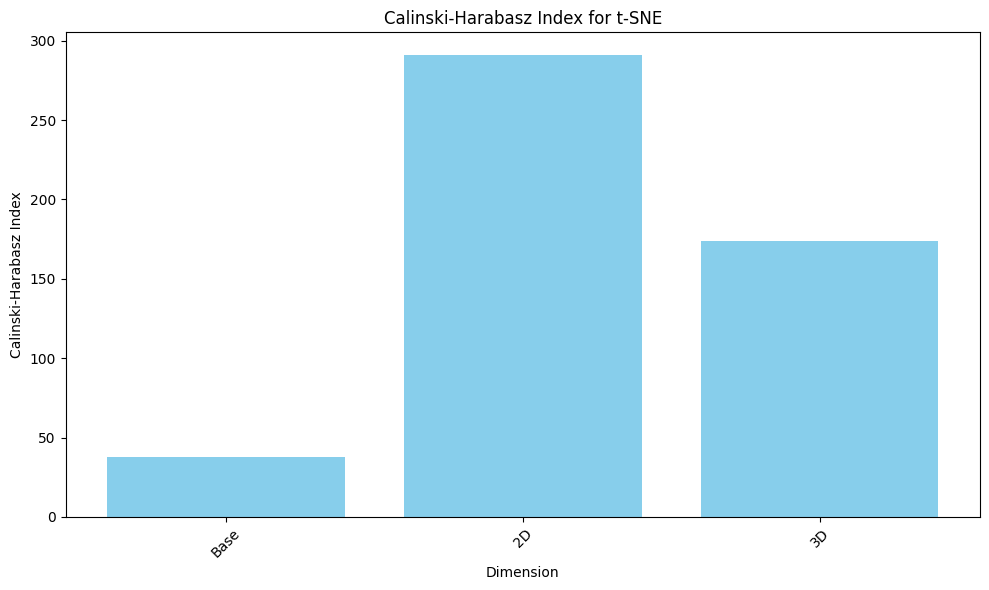

  Dimension  Calinski-Harabasz Index
0      Base                37.762006
1        2D               290.736597
2        3D               173.821009


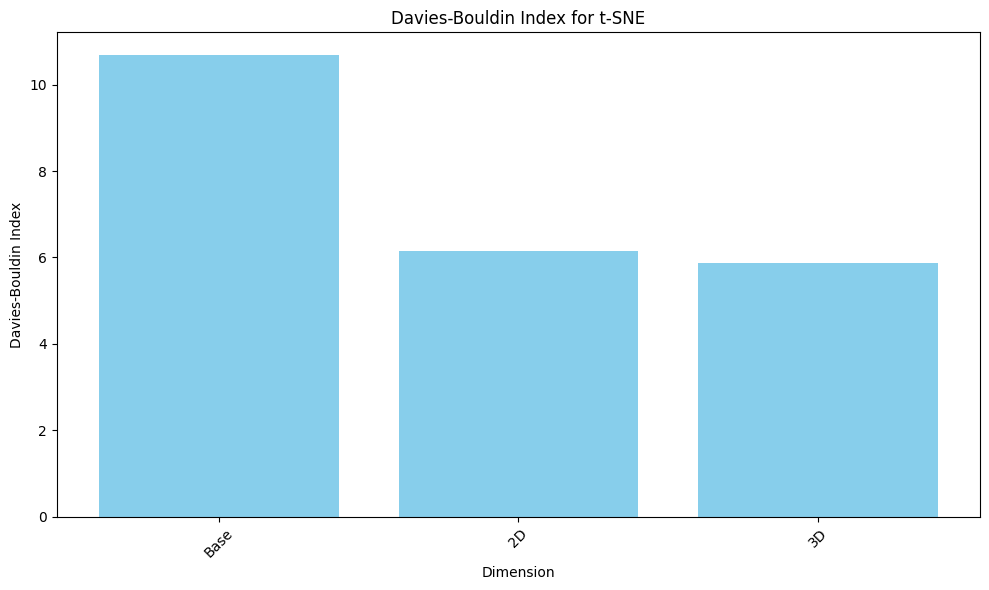

  Dimension  Davies-Bouldin Index
0      Base             10.674452
1        2D              6.145752
2        3D              5.873163


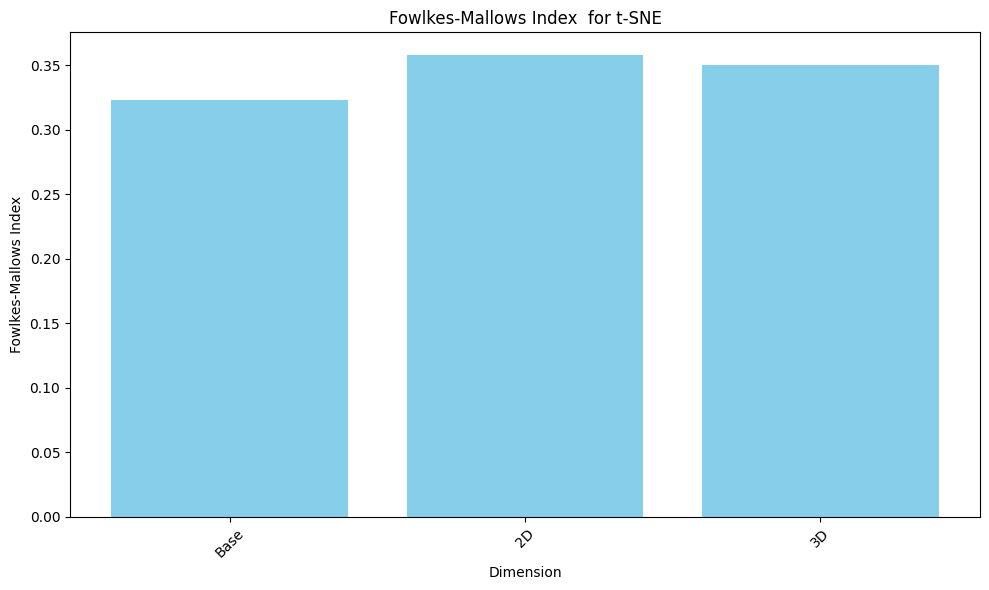

  Dimension  Fowlkes-Mallows Index
0      Base               0.322841
1        2D               0.357505
2        3D               0.349943


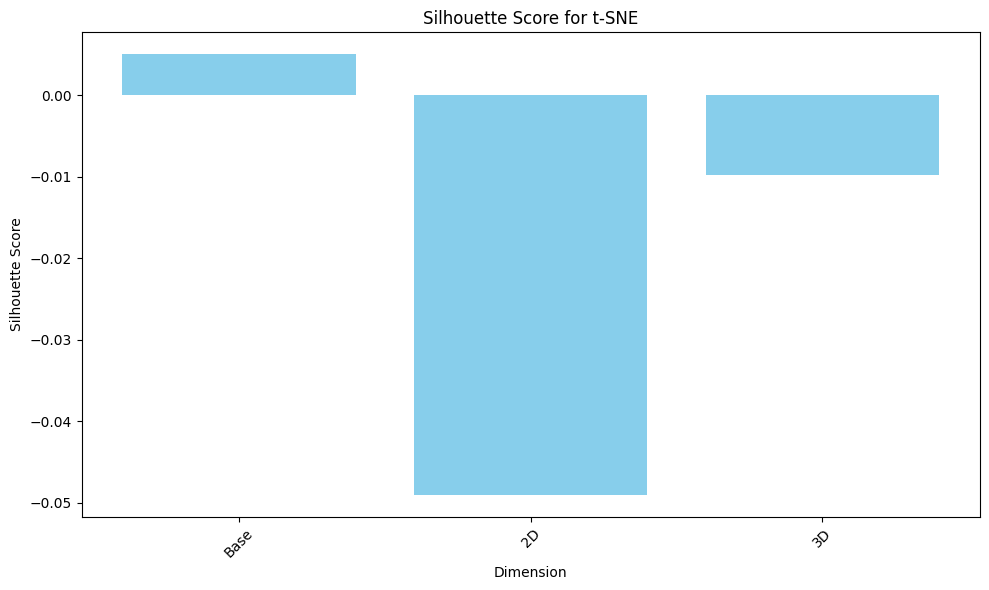

  Dimension  Silhouette Score
0      Base          0.005043
1        2D         -0.049042
2        3D         -0.009785


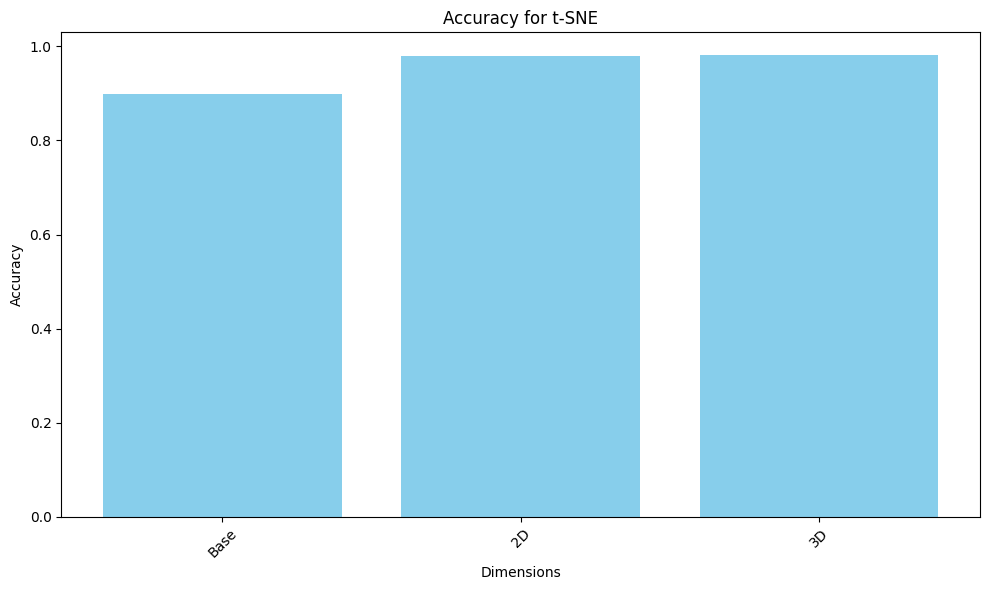

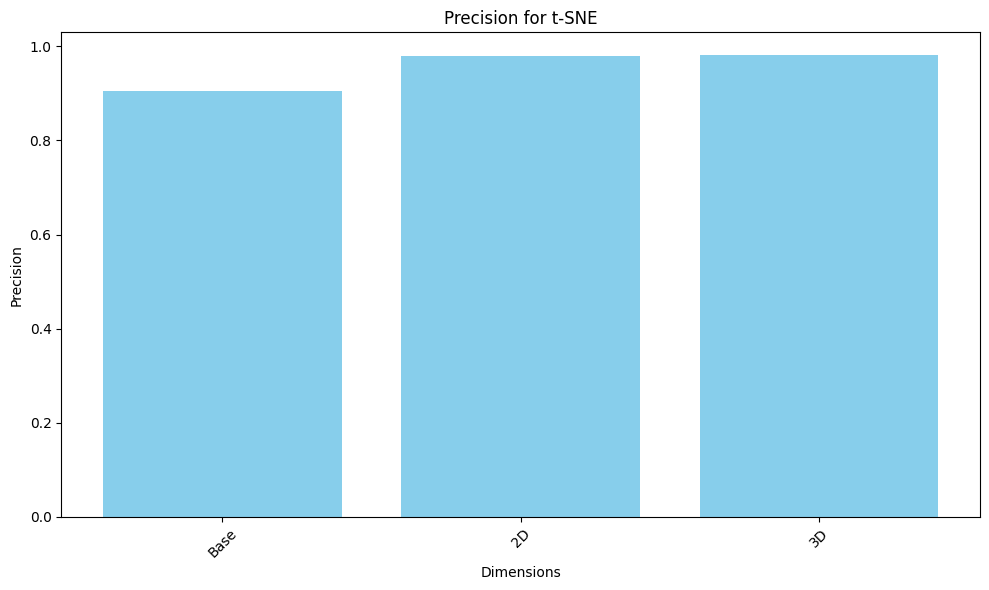

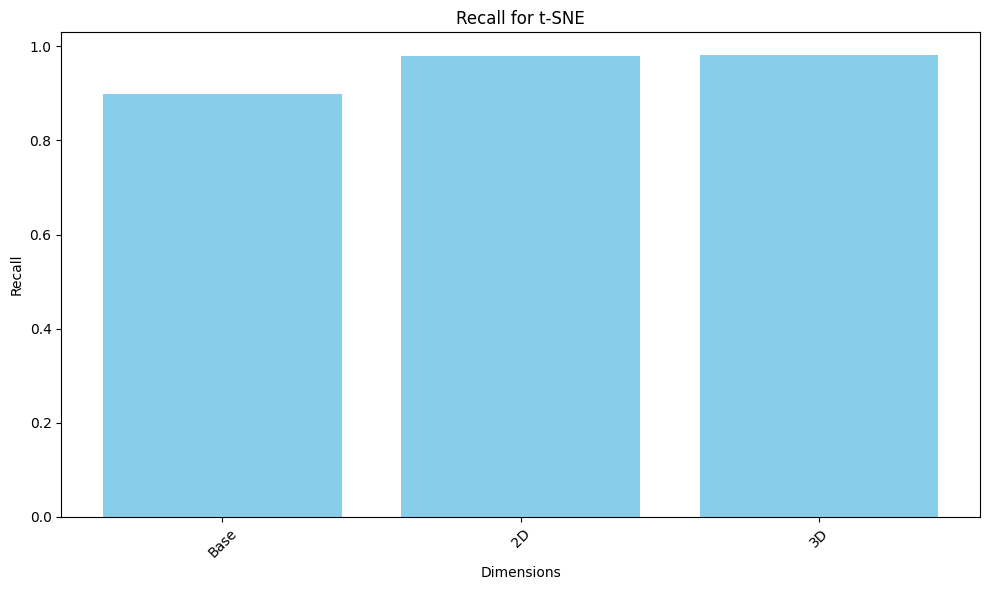

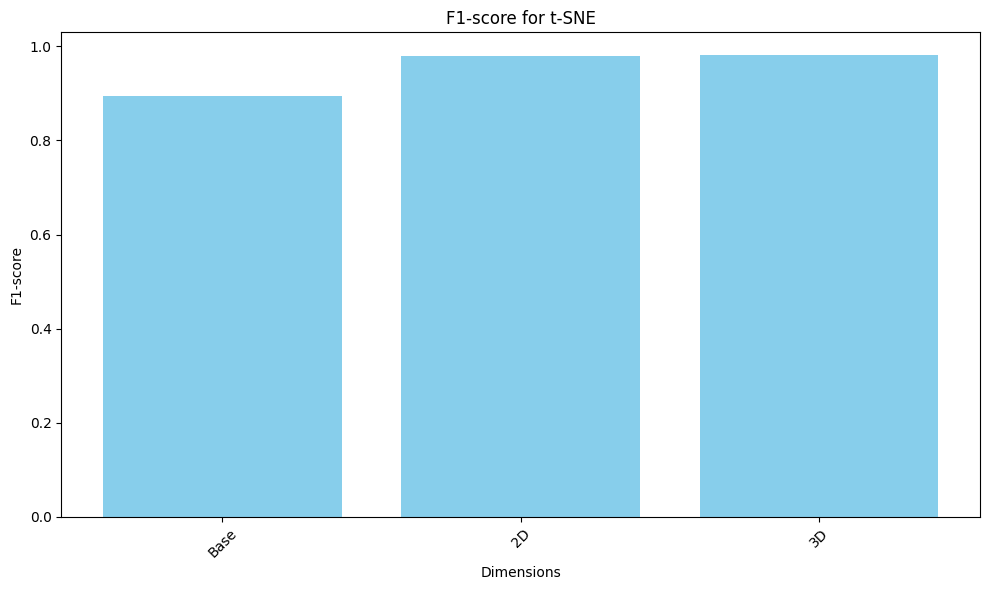

  Dimensions  Accuracy  Precision    Recall  F1-score
0       Base  0.898958   0.904731  0.898958  0.894862
1         2D  0.979167   0.979344  0.979167  0.979156
2         3D  0.980729   0.980723  0.980729  0.980716


In [ ]:
# Array with the dimensions we want to explore
dimensions = [2, 3]

# Array with the dimensionality reduction results
X_reduced = []

# Initialize t-SNE with best parameters for 2 dimensions
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate = 200, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Initialize t-SNE with best parameters for 3 dimensions
tsne = TSNE(n_components = 3, perplexity = 10, learning_rate = 100, init = 'random', random_state = 42)

# Fit t-SNE to the preprocessed data
X_tsne = tsne.fit_transform(X)

# Append to array
X_reduced.append(X_tsne)

# Compute the popular metrics
df_ch, df_db, df_fm, df_sil = compute_metrics(X, y, X_reduced, dimensions)

# Display the popular metrics
plot_metrics(df_ch, 'Calinski-Harabasz Index', 'Calinski-Harabasz Index for t-SNE')
print(df_ch)

plot_metrics(df_db, 'Davies-Bouldin Index', 'Davies-Bouldin Index for t-SNE')
print(df_db)

plot_metrics(df_fm, 'Fowlkes-Mallows Index', 'Fowlkes-Mallows Index  for t-SNE')
print(df_fm)

plot_metrics(df_sil, 'Silhouette Score', 'Silhouette Score for t-SNE')
print(df_sil)

# Compute the classification metrics
df_results = compare_classification(X, y, X_reduced, dimensions)

# Display the classification metrics
plot_classification_results(df_results, 'Accuracy', 'Accuracy for t-SNE')
plot_classification_results(df_results, 'Precision', 'Precision for t-SNE')
plot_classification_results(df_results, 'Recall', 'Recall for t-SNE')
plot_classification_results(df_results, 'F1-score', 'F1-score for t-SNE')
print(df_results)

# Best t-SNE Results Embedding

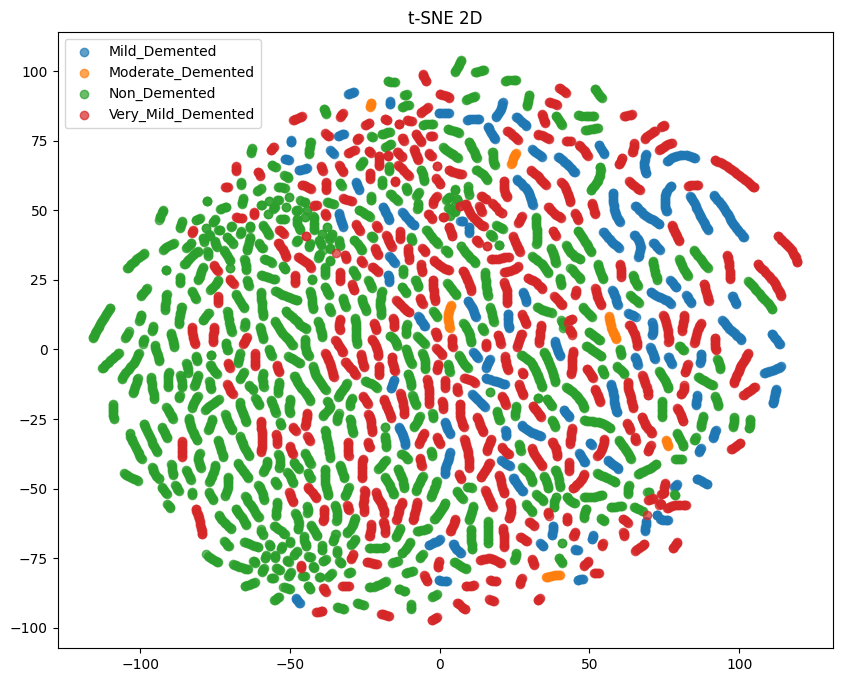

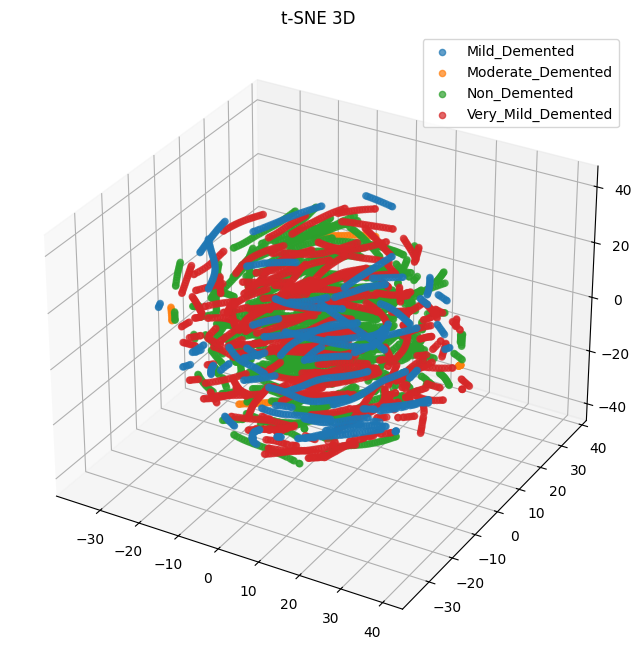

In [ ]:
# Function to plot 2D embedding
def plot_embedding_2d(X, y, title):
    plt.figure(figsize=(10, 8))
    for class_name, class_label in class_labels.items():
        plt.scatter(X[y == class_label, 0], X[y == class_label, 1], label=class_name, alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

# Function to plot 3D embedding
def plot_embedding_3d(X, y, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for class_name, class_label in class_labels.items():
        ax.scatter(X[y == class_label, 0], X[y == class_label, 1], X[y == class_label, 2], label=class_name, alpha=0.7)
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_embedding_2d(X_reduced[0], y, 't-SNE 2D')
plot_embedding_3d(X_reduced[1], y, 't-SNE 3D')